# Read the full data and detect outliers

There are two available datasets, with or without water velocity. 

The data without water velocity **has more observations (104)**, but across the entire corridor, while the data with water velocity has fewer
observations (only about 20), **but is in the exact same data structure** that we will finally use for the analysis.

Here, larger sample size makes analysis more robust and results more encouraging, so **i will use the data without water velocity first.**


In [607]:
# read the full data without velocity columns
import pandas as pd
data = pd.read_excel("../data/processed_data/full_data_without_velocity.xlsx")
print(data.info())
data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 104 entries, 0 to 103
Data columns (total 56 columns):
 #   Column                                 Non-Null Count  Dtype  
---  ------                                 --------------  -----  
 0   StationID                              104 non-null    object 
 1   Al                                     104 non-null    int64  
 2   As                                     104 non-null    float64
 3   Bi                                     104 non-null    float64
 4   Ca                                     104 non-null    int64  
 5   Cd                                     104 non-null    float64
 6   Co                                     104 non-null    float64
 7   Cr                                     104 non-null    float64
 8   Cu                                     104 non-null    float64
 9   Fe                                     104 non-null    int64  
 10  Hg                                     104 non-null    float64
 11  K     

StationID    Al     As      Bi     Ca      Cd     Co      Cr       Cu  \
0        S1  1501  2.096  25.800  43640  0.4436  2.096   3.674   0.0000   
1        S3  4491  0.000   2.143  33160  0.2120  4.599   7.663   0.5824   
2        S4  2666  2.188  31.790  40140  0.5341  2.991   5.672   4.0580   
3        A5  2283  2.233  20.110  41360  0.2387  2.702   8.566   9.5820   
4        S5  6711  4.298  27.480  43960  1.0240  6.032  11.520  13.4800   

      Fe  ...  Other Trichoptera     Amphipoda     Dreissena         Acari  \
0   5352  ...       3.203427e-16  3.203427e-16  3.203427e-16  3.203427e-16   
1  34600  ...       4.516960e-01  3.203427e-16  3.203427e-16  7.951802e-01   
2   7506  ...       4.087463e+00  2.321928e+00  1.874469e+00  2.321928e+00   
3   8410  ...       5.300336e+00  7.862933e-01  4.362134e+00  3.203427e-16   
4  11920  ...       3.203427e-16  3.203427e-16  2.762698e-01  3.203427e-16   

       Hydrozoa     Hirudinea   Turbellaria    Gastropoda   Sphaeriidae  \
0  3.203427e-16  3.203427e-16  3.203427e-16  3.203427e-16  3.203427e-16   
1  4.516960e-01  3.203427e-16  3.203427e-16  7.951802e-01  3.203427e-16   
2  1.874469e+00  3.203427e-16  3.203427e-16  3.203427e-16  1.222392e+00   
3  3.203427e-16  3.203427e-16  3.203427e-16  3.203427e-16  3.203427e-16   
4  3.203427e-16  5.502416e-01  5.502416e-01  1.803435e+00  1.803435e+00   

   stress_level  
0     -2.446806  
1      0.505028  
2     -2.047317  
3     -1.810714  
4      0.943809  

[5 rows x 56 columns]

### Visualize the data geographically

To visualize the data geographically, there needs to create a column of geometric coordinates, which is not only for visualization, 
but can be used for spatial analysis later on.

In [608]:
# create the geomotric coordinates column
import geopandas as gpd
from shapely.geometry import Point

data["geo_coordinates"] = data.apply(lambda row: Point(row["Longitude"], row["Latitude"]), axis=1)
data_gdf = gpd.GeoDataFrame(data, geometry="geo_coordinates", crs="EPSG:4326")

In [609]:
# a decorator to quickly add annotations for the lake names
def add_corridor_labels_and_grid(plot_func):
    def wrapper(*args, **kwargs):
        ax = kwargs.get('ax', None)
        if ax is None and len(args) > 0:
            ax = args[0]
        result = plot_func(*args, **kwargs)
        if ax is not None:
            ax.text(-82.85, 42.42, 'Lake Saint Clair', fontsize=8, color='gray', weight='bold', alpha=0.5)
            ax.text(-83.07, 42.2, 'Detroit River', fontsize=8, color='gray', weight='bold', alpha=0.5)
            ax.text(-82.9, 42.9, 'Staint Clair River', fontsize=8, color='gray', weight='bold', alpha=0.5)
            ax.legend(fontsize=8, loc='upper left')
            ax.grid(True, linestyle='--', alpha=0.5)
        return result
    return wrapper

/var/folders/s5/r1s56_ps46lbbv1370hjn_vr0000gn/T/ipykernel_1507/3543563251.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=8, loc='upper left')


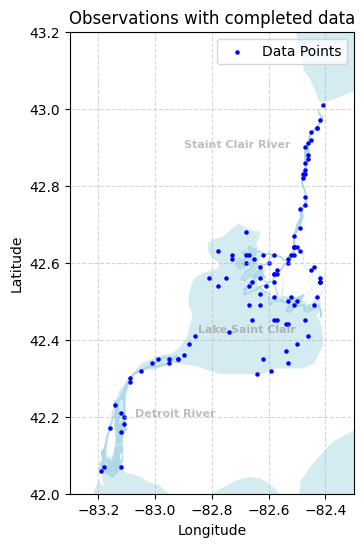

In [610]:
from PyModules import Visualization
import matplotlib.pyplot as plt

# create the canvas with corridor zones
fig, ax = plt.subplots(figsize=(10, 6))

@add_corridor_labels_and_grid
def plot_rivers_lakes(ax):
    Visualization.plot_rivers_lakes(ax=ax)

plot_rivers_lakes(ax=ax)

# add the data points onto the canvas
data_gdf.plot(ax=ax, color='blue', markersize=5, label='Data Points')
ax.set_title('Observations with completed data')
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
ax.legend()
plt.savefig("../results/preliminary_results/merged_104_completed_observations.png", dpi=300)
plt.show()

# Taxa data exploration: outliers and dominant taxa

Based on the chapter 4 of the book "Analysing Ecological Data" by Zuur, et al. (2004),
**outliers need to be detected and gave suitable treatment before the analysis**.

Especially for the **zoobenthic data**, which has the sample size and sampling quality less than ideal,
might raise a high demand for limited transformation.

## Make the 57 columns into 4 tidy groups

There are chemical elements, environmental variables, taxa, and location columns and other columns in the data.

The first 3 groups are the main focuses of the analysis, location waits for spatial visualization and analysis, other columns are 
potentially useful for other purposes.

In [611]:
# Define the 4 column groups, avoid running multiple times to mess up the column names
chemical_cols = [
    'Al', 'As', 'Bi', 'Ca', 'Cd', 'Co', 'Cr', 'Cu', 'Fe', 'Hg', 'K', 'Mg', 'Mn', 'Na', 'Ni', 'Pb', 'Sb', 'V', 'Zn',
    '%OC', '1245-TCB', '1234-TCB', 'QCB', 'HCB', 'OCS', "p,p'-DDE", "p,p'-DDD", 'mirex', 'Heptachlor Epoxide', 'total PCB'
]
environmental_cols = [
    'Total Organic Carbon (LOI %)', 'Water Depth (m)', 'Water Temperature (¬∞C)',
    'Dissolved Oxygen Concentration (mg/L)', 'Median Particle Size (Phi)',
]
taxa_cols = [
    'Oligochaeta', 'Nematoda', 'Chironomidae', 'Ceratopogonidae', 'Hexagenia', 'Caenis', 'Hydropsychidae',
    'Other Trichoptera', 'Amphipoda', 'Dreissena', 'Acari', 'Hydrozoa', 'Hirudinea', 'Turbellaria', 'Gastropoda', 'Sphaeriidae'
]
loc_cols = [
    "Location", "Latitude", "Longitude", "geo_coordinates"
]

# Create MultiIndex for columns
new_columns = []
for col in data.columns:
    if col in chemical_cols:
        new_columns.append(('chemical', col))
    elif col in environmental_cols:
        new_columns.append(('environmental', col))
    elif col in taxa_cols:
        new_columns.append(('taxa', col))
    elif col in loc_cols:
        new_columns.append(('location', col))
    else:
        new_columns.append(('ID', col))

data.columns = pd.MultiIndex.from_tuples(new_columns)
data.head()

ID chemical                                                        \
  StationID       Al     As      Bi     Ca      Cd     Co      Cr       Cu   
0        S1     1501  2.096  25.800  43640  0.4436  2.096   3.674   0.0000   
1        S3     4491  0.000   2.143  33160  0.2120  4.599   7.663   0.5824   
2        S4     2666  2.188  31.790  40140  0.5341  2.991   5.672   4.0580   
3        A5     2283  2.233  20.110  41360  0.2387  2.702   8.566   9.5820   
4        S5     6711  4.298  27.480  43960  1.0240  6.032  11.520  13.4800   

          ...          taxa                                            \
      Fe  ...     Amphipoda     Dreissena         Acari      Hydrozoa   
0   5352  ...  3.203427e-16  3.203427e-16  3.203427e-16  3.203427e-16   
1  34600  ...  3.203427e-16  3.203427e-16  7.951802e-01  4.516960e-01   
2   7506  ...  2.321928e+00  1.874469e+00  2.321928e+00  1.874469e+00   
3   8410  ...  7.862933e-01  4.362134e+00  3.203427e-16  3.203427e-16   
4  11920  ...  3.203427e-16  2.762698e-01  3.203427e-16  3.203427e-16   

                                                                    ID  \
      Hirudinea   Turbellaria    Gastropoda   Sphaeriidae stress_level   
0  3.203427e-16  3.203427e-16  3.203427e-16  3.203427e-16    -2.446806   
1  3.203427e-16  3.203427e-16  7.951802e-01  3.203427e-16     0.505028   
2  3.203427e-16  3.203427e-16  3.203427e-16  1.222392e+00    -2.047317   
3  3.203427e-16  3.203427e-16  3.203427e-16  3.203427e-16    -1.810714   
4  5.502416e-01  5.502416e-01  1.803435e+00  1.803435e+00     0.943809   

               location  
        geo_coordinates  
0  POINT (-82.41 43.01)  
1  POINT (-82.43 42.95)  
2  POINT (-82.45 42.92)  
3  POINT (-82.46 42.88)  
4  POINT (-82.46 42.87)  

[5 rows x 57 columns]

Oligochaeta: 5 outliers, portion: 4.81%
Nematoda: 0 outliers, portion: 0.00%
Chironomidae: 2 outliers, portion: 1.92%
Ceratopogonidae: 9 outliers, portion: 8.65%
Hexagenia: 9 outliers, portion: 8.65%
Caenis: 13 outliers, portion: 12.50%
Hydropsychidae: 19 outliers, portion: 18.27%
Other Trichoptera: 11 outliers, portion: 10.58%
Amphipoda: 11 outliers, portion: 10.58%
Dreissena: 9 outliers, portion: 8.65%
Acari: 6 outliers, portion: 5.77%
Hydrozoa: 19 outliers, portion: 18.27%
Hirudinea: 15 outliers, portion: 14.42%
Turbellaria: 6 outliers, portion: 5.77%
Gastropoda: 8 outliers, portion: 7.69%
Sphaeriidae: 4 outliers, portion: 3.85%


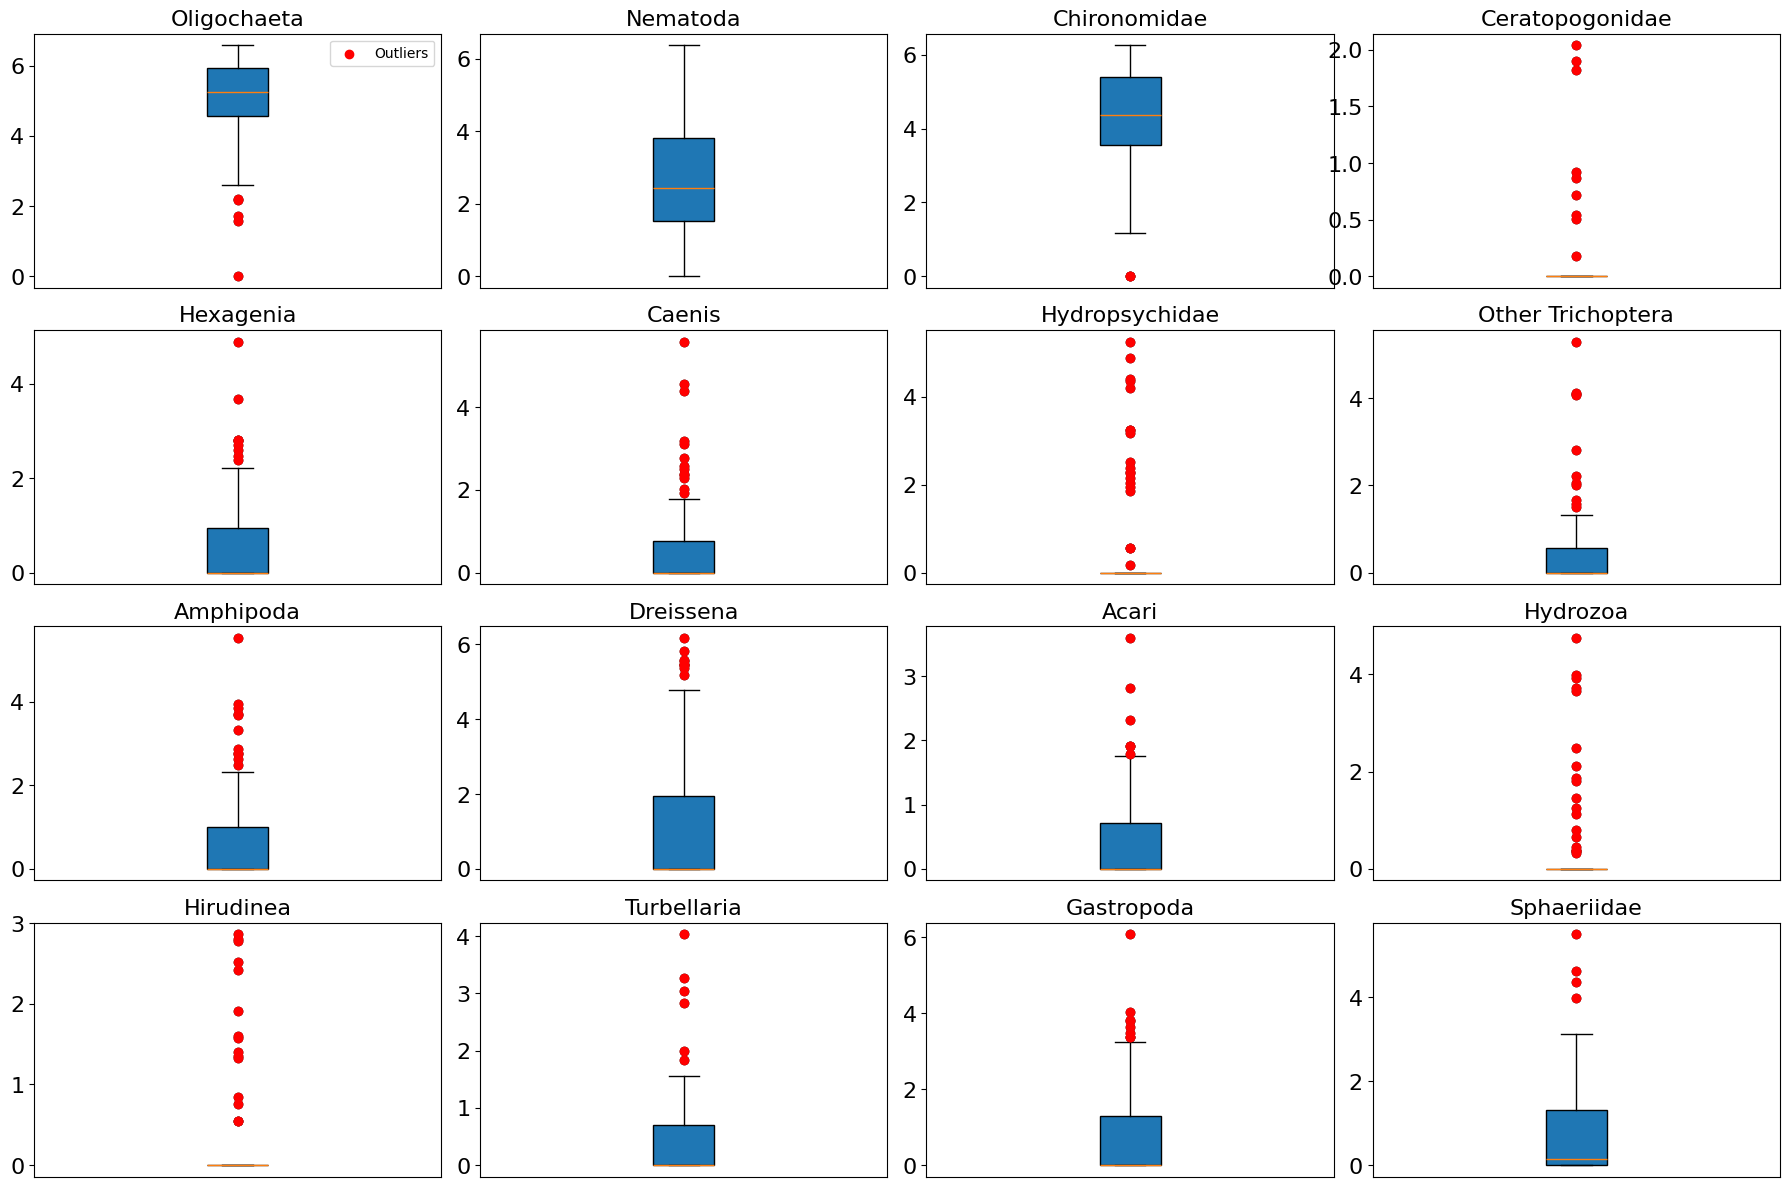

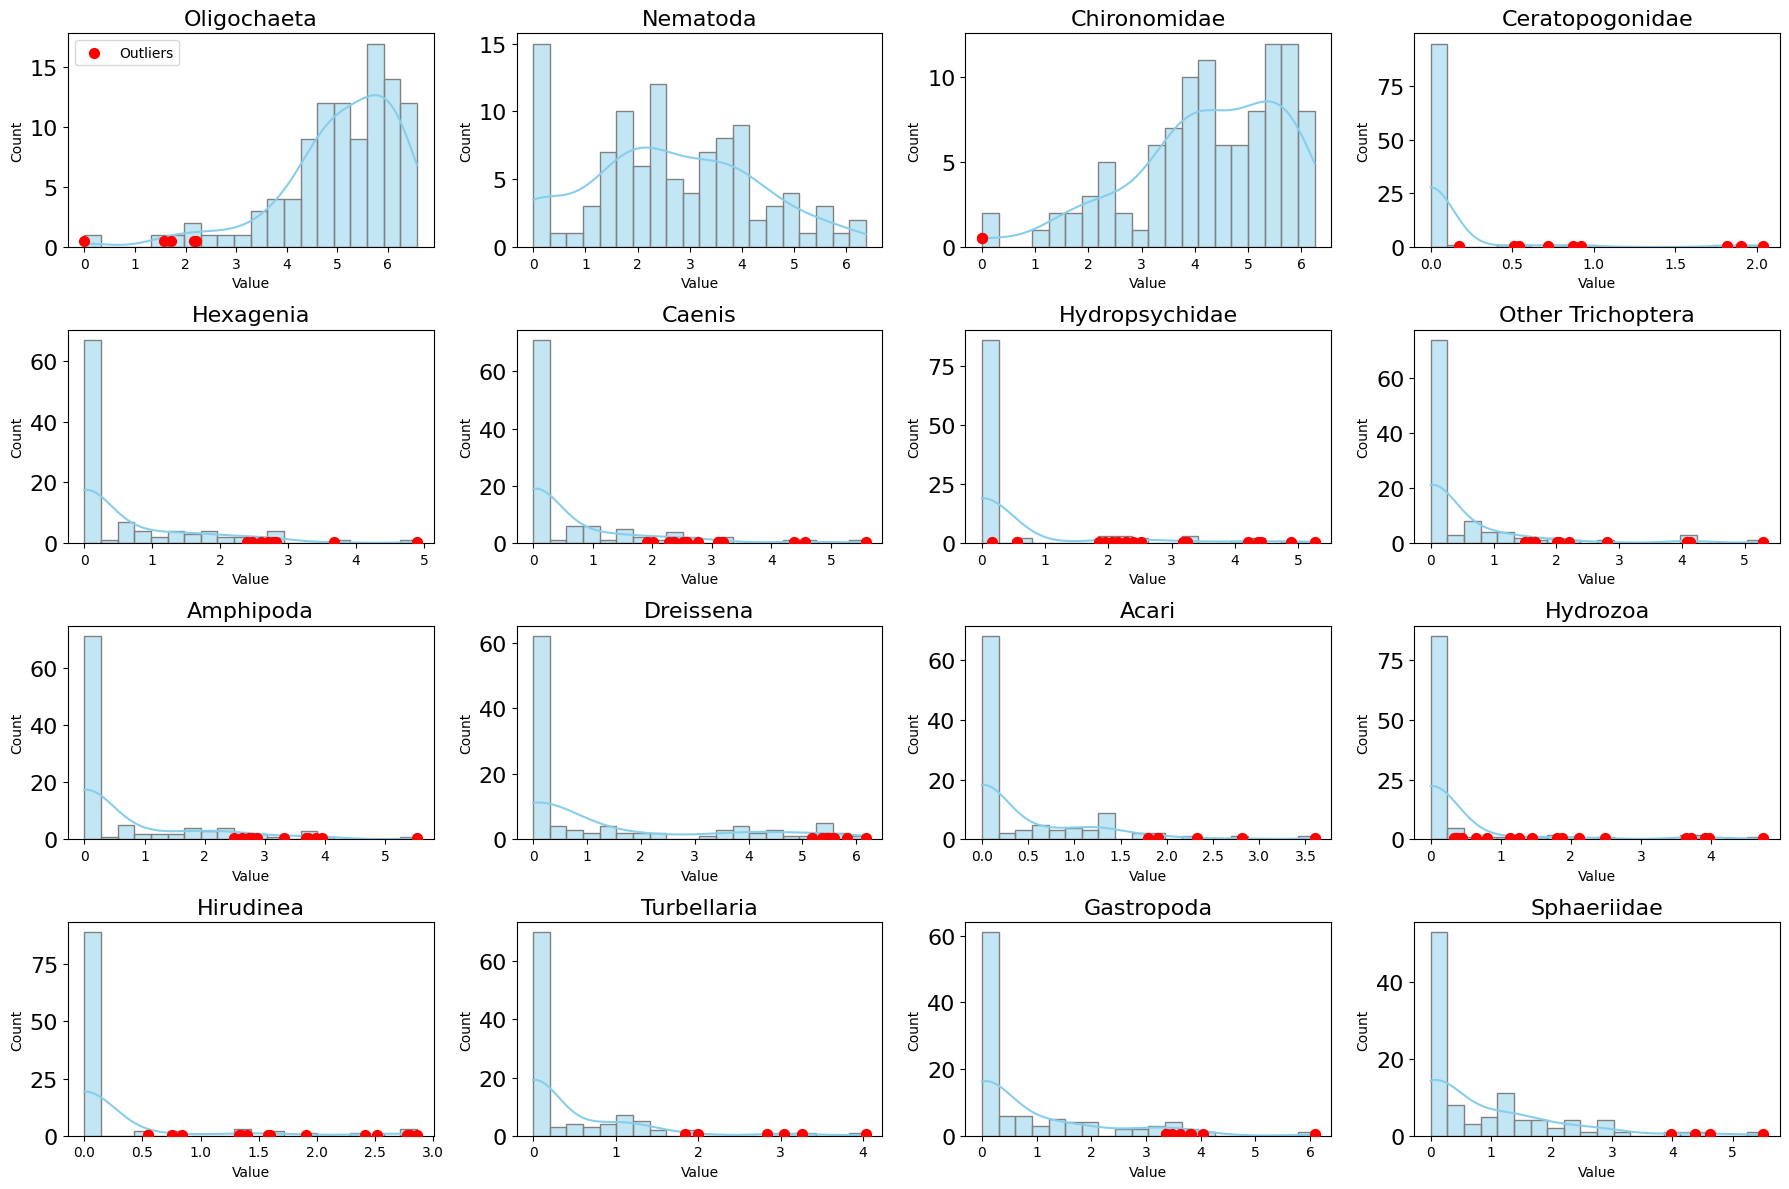

In [612]:
# Detect possible outliers in the taxa columns using the IQR method and visualize with boxplots
import matplotlib.pyplot as plt
import seaborn as sns

taxa_df = data['taxa']
outlier_indices = {}

fig, axes = plt.subplots(nrows=4, ncols=4, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(taxa_df.columns):
    Q1 = taxa_df[col].quantile(0.25)
    Q3 = taxa_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = taxa_df[(taxa_df[col] < lower_bound) | (taxa_df[col] > upper_bound)][col]
    if not outliers.empty:
        outlier_indices[col] = outliers.index.tolist()
    # Boxplot
    axes[i].boxplot(taxa_df[col], vert=True, patch_artist=True)
    axes[i].set_title(col, fontsize=16)
    # Mark outliers
    axes[i].scatter([1]*len(outliers), outliers, color='red', zorder=3, label='Outliers' if i == 0 else "")
    axes[i].set_xticks([])
    axes[i].tick_params(axis='y', labelsize=16)
    # Print outlier stats
    print(f"{col}: {len(outliers)} outliers, portion: {len(outliers)/len(taxa_df):.2%}")
    
# Add legend only to the first subplot
axes[0].legend()
plt.tight_layout()
plt.savefig("../results/preliminary_results/raw_taxa_outliers_boxplots.png", dpi=300)
plt.show()

# Plot histogram and density for each taxa variable, marking outliers
fig, axes_hist = plt.subplots(nrows=4, ncols=4, figsize=(18, 12))
axes_hist = axes_hist.flatten()

for idx, col in enumerate(taxa_cols):
    ax_hist = axes_hist[idx]
    values = taxa_df[col]
    # Plot histogram and KDE
    sns.histplot(values, bins=20, kde=True, ax=ax_hist, color='skyblue', edgecolor='gray')
    # Mark outliers
    if col in outlier_indices:
        outlier_vals = values.loc[outlier_indices[col]]
        ax_hist.scatter(outlier_vals, [0.5]*len(outlier_vals), color='red', s=50, label='Outliers', zorder=5)
    ax_hist.set_title(col, fontsize=16)
    ax_hist.tick_params(axis='y', labelsize=16)
    ax_hist.set_xlabel('Value')
    ax_hist.set_ylabel('Count')
    if idx == 0:
        ax_hist.legend()
plt.tight_layout()
plt.savefig("../results/preliminary_results/raw_taxa_outliers_histograms.png", dpi=300)
plt.show()

Oligochaeta: 7 outliers, portion: 6.73%
Nematoda: 0 outliers, portion: 0.00%
Chironomidae: 7 outliers, portion: 6.73%
Ceratopogonidae: 9 outliers, portion: 8.65%
Hexagenia: 1 outliers, portion: 0.96%
Caenis: 5 outliers, portion: 4.81%
Hydropsychidae: 19 outliers, portion: 18.27%
Other Trichoptera: 7 outliers, portion: 6.73%
Amphipoda: 1 outliers, portion: 0.96%
Dreissena: 0 outliers, portion: 0.00%
Acari: 1 outliers, portion: 0.96%
Hydrozoa: 19 outliers, portion: 18.27%
Hirudinea: 15 outliers, portion: 14.42%
Turbellaria: 4 outliers, portion: 3.85%
Gastropoda: 0 outliers, portion: 0.00%
Sphaeriidae: 0 outliers, portion: 0.00%


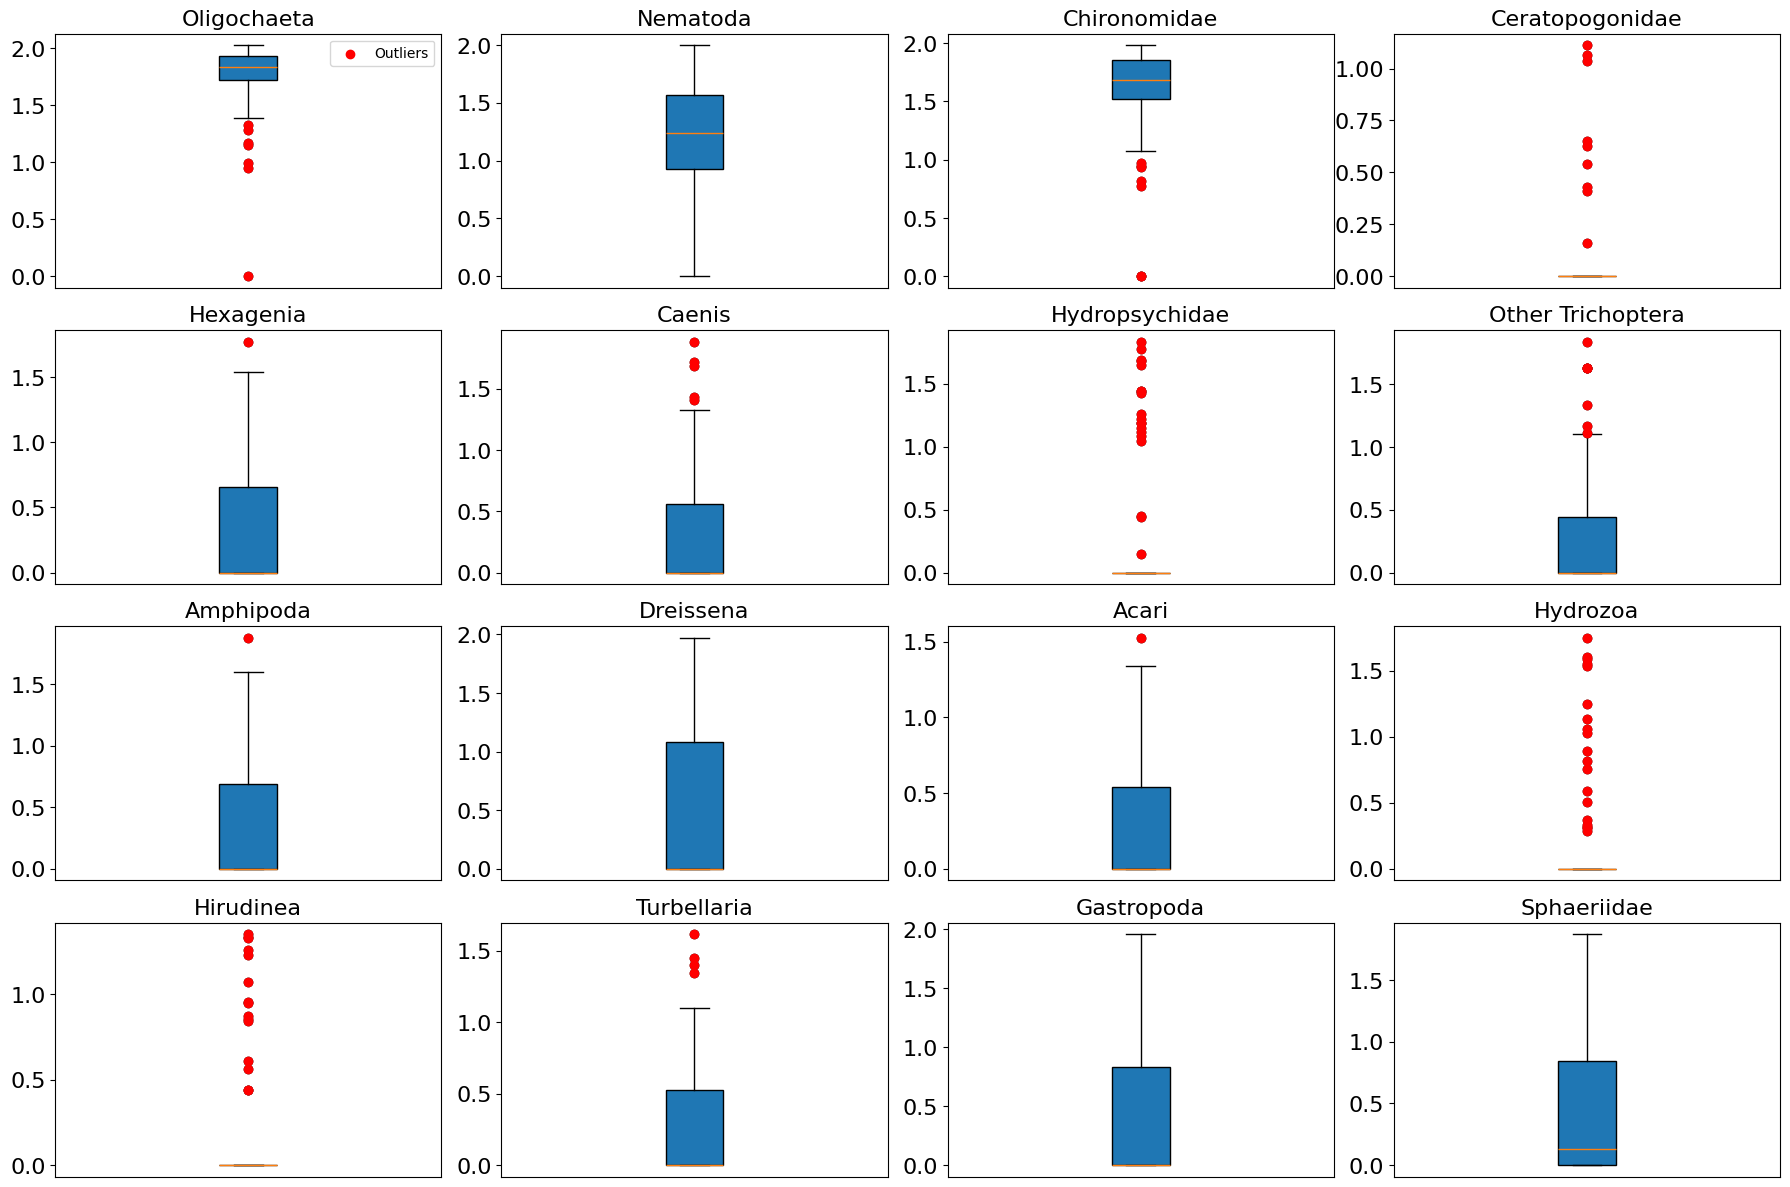

In [613]:
# Log-transform all taxa columns
import numpy as np

taxa_log_df = np.log1p(taxa_df.iloc[:, :])

# Detect possible outliers in the log-transformed taxa data using the IQR method and visualize with boxplots
taxa_log_outlier_indices = {}

fig, axes_log = plt.subplots(nrows=4, ncols=4, figsize=(18, 12))
axes_log = axes_log.flatten()

for i, col in enumerate(taxa_log_df.columns):
    Q1 = taxa_log_df[col].quantile(0.25)
    Q3 = taxa_log_df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = taxa_log_df[(taxa_log_df[col] < lower_bound) | (taxa_log_df[col] > upper_bound)][col]
    if not outliers.empty:
        taxa_log_outlier_indices[col] = outliers.index.tolist()
    # Boxplot
    axes_log[i].boxplot(taxa_log_df[col], vert=True, patch_artist=True)
    axes_log[i].set_title(col, fontsize=16)
    axes_log[i].tick_params(axis='y', labelsize=16)
    # Mark outliers
    axes_log[i].scatter([1]*len(outliers), outliers, color='red', zorder=3, label='Outliers' if i == 0 else "")
    axes_log[i].set_xticks([])
    print(f"{col}: {len(outliers)} outliers, portion: {len(outliers)/len(taxa_log_df):.2%}")

axes_log[0].legend()
plt.tight_layout()
plt.show()

# Plot histogram and density for each log-transformed taxa variable, marking outliers
fig, axes_hist = plt.subplots(nrows=4, ncols=4, figsize=(18, 12))
axes_hist = axes_hist.flatten()

for idx, col in enumerate(taxa_log_df.columns):
    ax_hist = axes_hist[idx]
    values = taxa_log_df[col]
    sns.histplot(values, bins=20, kde=True, ax=ax_hist, color='skyblue', edgecolor='gray')
    # Mark outliers if any
    if col in taxa_log_outlier_indices:
        outlier_idx = taxa_log_outlier_indices[col]
        outlier_vals = values.loc[outlier_idx]
        ax_hist.scatter(outlier_vals, [0.5]*len(outlier_vals), color='red', s=60, label='Outliers', zorder=5)
    ax_hist.set_title(f'Histogram of Log-Transformed {col}')
    ax_hist.set_xlabel('Log-Transformed Value')
    ax_hist.set_ylabel('Count')
    if idx == 0:
        ax_hist.legend()
plt.tight_layout()
plt.show()

After logarithemic transformation, the taxa data have less outliers but some variables still have the same amount of outliers as before, 
which is highly possible due to the large amount of zeros in the raw data.

Variables like this only account for 4 out of the 16 taxa variables, so I choose to convert them into categorical variables,
**based on the advice from the book "Analysing Ecological Data" by Zuur, et al. (2004).**

## Store the log-transformed taxa data in the complete data frame

In [614]:
# make only logarithmic transformation, not binary transformation
taxa_log_df.columns = pd.MultiIndex.from_product([["log_transformed_taxa"], taxa_log_df.columns])
print(f"Before concatenation, the original data has {data.shape[1]} columns.")
data = pd.concat([data, taxa_log_df], axis=1)
print(f"After concatenation, the original data has {data.shape[1]} columns.")
data.head()

Before concatenation, the original data has 57 columns.
After concatenation, the original data has 73 columns.


ID chemical                                                        \
  StationID       Al     As      Bi     Ca      Cd     Co      Cr       Cu   
0        S1     1501  2.096  25.800  43640  0.4436  2.096   3.674   0.0000   
1        S3     4491  0.000   2.143  33160  0.2120  4.599   7.663   0.5824   
2        S4     2666  2.188  31.790  40140  0.5341  2.991   5.672   4.0580   
3        A5     2283  2.233  20.110  41360  0.2387  2.702   8.566   9.5820   
4        S5     6711  4.298  27.480  43960  1.0240  6.032  11.520  13.4800   

          ... log_transformed_taxa                                  \
      Fe  ...       Hydropsychidae Other Trichoptera     Amphipoda   
0   5352  ...         3.203427e-16      3.203427e-16  3.203427e-16   
1  34600  ...         3.203427e-16      3.727325e-01  3.203427e-16   
2   7506  ...         3.203427e-16      1.626779e+00  1.200545e+00   
3   8410  ...         1.679362e+00      1.840603e+00  5.801427e-01   
4  11920  ...         3.203427e-16      3.203427e-16  3.203427e-16   

                                                                         \
      Dreissena         Acari      Hydrozoa     Hirudinea   Turbellaria   
0  3.203427e-16  3.203427e-16  3.203427e-16  3.203427e-16  3.203427e-16   
1  3.203427e-16  5.851054e-01  3.727325e-01  3.203427e-16  3.203427e-16   
2  1.055868e+00  1.200545e+00  1.055868e+00  3.203427e-16  3.203427e-16   
3  1.679362e+00  3.203427e-16  3.203427e-16  3.203427e-16  3.203427e-16   
4  2.439416e-01  3.203427e-16  3.203427e-16  4.384108e-01  4.384108e-01   

                               
     Gastropoda   Sphaeriidae  
0  3.203427e-16  3.203427e-16  
1  5.851054e-01  3.203427e-16  
2  3.203427e-16  7.985843e-01  
3  3.203427e-16  3.203427e-16  
4  1.030845e+00  1.030845e+00  

[5 rows x 73 columns]

## Convert the very skewedly distributed taxa variables into categorical variables

To the transformed taxa variables, if a transformed one has a large proportion of zeros and any values larger than 0 become outliers, 
then it is considered as a very skewedly distributed taxa variable, and I will convert it into a categorical variable.

In the transformed taxa data, there are 4 variables met the criteria, which are 
- *Ceratopogonidae*
- *Hydropsychidae*
- *Hydrozoa*
- *Hirudinea*

They will be converted into categorical variables, (0, 1).

$10^{-5}$ is a well seperating threshold for the 4 taxa variables to distinguish between zeros and non-zeros, 
so I will use it to convert the variables into categorical variables.

In [615]:
# convert the multiindex back to single index for easier access
taxa_log_df.columns = taxa_log_df.columns.get_level_values(1)
taxa_log_df.head()

Oligochaeta      Nematoda  Chironomidae  Ceratopogonidae     Hexagenia  \
0     1.875421  1.276748e+00      1.897983     3.203427e-16  3.203427e-16   
1     2.000646  3.727325e-01      1.597175     3.203427e-16  3.203427e-16   
2     1.778815  3.203427e-16      1.842113     3.203427e-16  3.203427e-16   
3     1.281568  3.203427e-16      1.637628     3.203427e-16  3.203427e-16   
4     1.876422  1.784195e+00      1.652628     4.108123e-01  3.203427e-16   

         Caenis  Hydropsychidae  Other Trichoptera     Amphipoda  \
0  3.203427e-16    3.203427e-16       3.203427e-16  3.203427e-16   
1  3.203427e-16    3.203427e-16       3.727325e-01  3.203427e-16   
2  7.985843e-01    3.203427e-16       1.626779e+00  1.200545e+00   
3  3.203427e-16    1.679362e+00       1.840603e+00  5.801427e-01   
4  5.127659e-01    3.203427e-16       3.203427e-16  3.203427e-16   

      Dreissena         Acari      Hydrozoa     Hirudinea   Turbellaria  \
0  3.203427e-16  3.203427e-16  3.203427e-16  3.203427e-16  3.203427e-16   
1  3.203427e-16  5.851054e-01  3.727325e-01  3.203427e-16  3.203427e-16   
2  1.055868e+00  1.200545e+00  1.055868e+00  3.203427e-16  3.203427e-16   
3  1.679362e+00  3.203427e-16  3.203427e-16  3.203427e-16  3.203427e-16   
4  2.439416e-01  3.203427e-16  3.203427e-16  4.384108e-01  4.384108e-01   

     Gastropoda   Sphaeriidae  
0  3.203427e-16  3.203427e-16  
1  5.851054e-01  3.203427e-16  
2  3.203427e-16  7.985843e-01  
3  3.203427e-16  3.203427e-16  
4  1.030845e+00  1.030845e+00

In [616]:
# Calculate the number of samples in the log-transformed Ceratopogonidae variable that are effectively zero
ceratopogonidae_threshold = 1e-5
print(f"In the log-transformed Ceratopogonidae variable, {(taxa_log_df['Ceratopogonidae'] < ceratopogonidae_threshold).sum()} out of {len(taxa_log_df)} samples are effectively zero (less than {ceratopogonidae_threshold}), indicating a highly skewed distribution dominated by zeros.")
hydropsychidae_threshold = 1e-5
print(f"In the log-transformed Hydropsychidae variable, {(taxa_log_df['Hydropsychidae'] < hydropsychidae_threshold).sum()} out of {len(taxa_log_df)} samples are effectively zero (less than {hydropsychidae_threshold}), indicating a highly skewed distribution dominated by zeros.")
hydrozoa_threshold = 1e-5
print(f"In the log-transformed Hydrozoa variable, {(taxa_log_df['Hydrozoa'] < hydrozoa_threshold).sum()} out of {len(taxa_log_df)} samples are effectively zero (less than {hydrozoa_threshold}), indicating a highly skewed distribution dominated by zeros.")
hirudines_threshold = 1e-5
print(f"In the log-transformed Hirudinea variable, {(taxa_log_df['Hirudinea'] < hirudines_threshold).sum()} out of {len(taxa_log_df)} samples are effectively zero (less than {hirudines_threshold}), indicating a highly skewed distribution dominated by zeros.")
rare_taxa_thresholds = 1e-5

In the log-transformed Ceratopogonidae variable, 95 out of 104 samples are effectively zero (less than 1e-05), indicating a highly skewed distribution dominated by zeros.
In the log-transformed Hydropsychidae variable, 85 out of 104 samples are effectively zero (less than 1e-05), indicating a highly skewed distribution dominated by zeros.
In the log-transformed Hydrozoa variable, 85 out of 104 samples are effectively zero (less than 1e-05), indicating a highly skewed distribution dominated by zeros.
In the log-transformed Hirudinea variable, 89 out of 104 samples are effectively zero (less than 1e-05), indicating a highly skewed distribution dominated by zeros.


In [617]:
# Convert specified taxa columns to categorical (0/1) based on nonzero values
for col in ["Ceratopogonidae", "Hydropsychidae", "Hydrozoa", "Hirudinea"]:
    taxa_log_df.loc[:, col] = (taxa_log_df[col] >= rare_taxa_thresholds).astype(int)
    print(f"After conversion, the {col} has binary values {taxa_log_df[col].value_counts()}")

After conversion, the Ceratopogonidae has binary values Ceratopogonidae
0.0    95
1.0     9
Name: count, dtype: int64
After conversion, the Hydropsychidae has binary values Hydropsychidae
0.0    85
1.0    19
Name: count, dtype: int64
After conversion, the Hydrozoa has binary values Hydrozoa
0.0    85
1.0    19
Name: count, dtype: int64
After conversion, the Hirudinea has binary values Hirudinea
0.0    89
1.0    15
Name: count, dtype: int64


### Add the transformed taxa data to the original data

It is not replacing the original taxa data, but adding a new group of columns to it, considering the data frame is not too large, it is 
feasible.

This will make the data frame have 16 more columns, which are the log-transformed taxa variables and the binary categorical variables.

In [618]:
# Set MultiIndex for taxa_log_df columns with higher level "log_bi_transformed_taxa"
taxa_log_df.columns = pd.MultiIndex.from_product([["log_bi_transformed_taxa"], taxa_log_df.columns])
taxa_log_df.head()

log_bi_transformed_taxa                                             \
              Oligochaeta      Nematoda Chironomidae Ceratopogonidae   
0                1.875421  1.276748e+00     1.897983             0.0   
1                2.000646  3.727325e-01     1.597175             0.0   
2                1.778815  3.203427e-16     1.842113             0.0   
3                1.281568  3.203427e-16     1.637628             0.0   
4                1.876422  1.784195e+00     1.652628             1.0   

                                                                              \
      Hexagenia        Caenis Hydropsychidae Other Trichoptera     Amphipoda   
0  3.203427e-16  3.203427e-16            0.0      3.203427e-16  3.203427e-16   
1  3.203427e-16  3.203427e-16            0.0      3.727325e-01  3.203427e-16   
2  3.203427e-16  7.985843e-01            0.0      1.626779e+00  1.200545e+00   
3  3.203427e-16  3.203427e-16            1.0      1.840603e+00  5.801427e-01   
4  3.203427e-16  5.127659e-01            0.0      3.203427e-16  3.203427e-16   

                                                                              \
      Dreissena         Acari Hydrozoa Hirudinea   Turbellaria    Gastropoda   
0  3.203427e-16  3.203427e-16      0.0       0.0  3.203427e-16  3.203427e-16   
1  3.203427e-16  5.851054e-01      1.0       0.0  3.203427e-16  5.851054e-01   
2  1.055868e+00  1.200545e+00      1.0       0.0  3.203427e-16  3.203427e-16   
3  1.679362e+00  3.203427e-16      0.0       0.0  3.203427e-16  3.203427e-16   
4  2.439416e-01  3.203427e-16      0.0       1.0  4.384108e-01  1.030845e+00   

                 
    Sphaeriidae  
0  3.203427e-16  
1  3.203427e-16  
2  7.985843e-01  
3  3.203427e-16  
4  1.030845e+00

In [619]:
# Concatenate the transformed taxa data to the original data along columns
print(f"Before concatenation, the original data has {data.shape[1]} columns.")
data = pd.concat([data, taxa_log_df], axis=1)
print(f"After concatenation, the combined data has {data.shape[1]} columns.")
data.head()

Before concatenation, the original data has 73 columns.
After concatenation, the combined data has 89 columns.


ID chemical                                                        \
  StationID       Al     As      Bi     Ca      Cd     Co      Cr       Cu   
0        S1     1501  2.096  25.800  43640  0.4436  2.096   3.674   0.0000   
1        S3     4491  0.000   2.143  33160  0.2120  4.599   7.663   0.5824   
2        S4     2666  2.188  31.790  40140  0.5341  2.991   5.672   4.0580   
3        A5     2283  2.233  20.110  41360  0.2387  2.702   8.566   9.5820   
4        S5     6711  4.298  27.480  43960  1.0240  6.032  11.520  13.4800   

          ... log_bi_transformed_taxa                                  \
      Fe  ...          Hydropsychidae Other Trichoptera     Amphipoda   
0   5352  ...                     0.0      3.203427e-16  3.203427e-16   
1  34600  ...                     0.0      3.727325e-01  3.203427e-16   
2   7506  ...                     0.0      1.626779e+00  1.200545e+00   
3   8410  ...                     1.0      1.840603e+00  5.801427e-01   
4  11920  ...                     0.0      3.203427e-16  3.203427e-16   

                                                                              \
      Dreissena         Acari Hydrozoa Hirudinea   Turbellaria    Gastropoda   
0  3.203427e-16  3.203427e-16      0.0       0.0  3.203427e-16  3.203427e-16   
1  3.203427e-16  5.851054e-01      1.0       0.0  3.203427e-16  5.851054e-01   
2  1.055868e+00  1.200545e+00      1.0       0.0  3.203427e-16  3.203427e-16   
3  1.679362e+00  3.203427e-16      0.0       0.0  3.203427e-16  3.203427e-16   
4  2.439416e-01  3.203427e-16      0.0       1.0  4.384108e-01  1.030845e+00   

                 
    Sphaeriidae  
0  3.203427e-16  
1  3.203427e-16  
2  7.985843e-01  
3  3.203427e-16  
4  1.030845e+00  

[5 rows x 89 columns]

## Use Octave transformation as in the dissertation

Logarithmic and Octave transformations both compress the data to eliminate the dominance of some taxa, like very abundant taxa.

They may have different extent of compression, depending on the later clustering analysis with different distance metrics. 

Here, **I implement both** transformations and store them in the same data frame with different upper level column names, ready for 
easy access.

In [620]:
# the funtion to apply octave transformation on a dataframe
import numpy as np

def octave_transform(df):
    """
    Convert raw taxon counts to octave‑transformed relative abundances.

    Parameters
    ----------
    df : pandas.DataFrame
        Each row corresponds to a site or sample; each column corresponds
        to counts of a taxon at that site.

    Returns
    -------
    pandas.DataFrame
        DataFrame of octave‑transformed values (log2[100×(proportion+0.01)]).
    """
    # total number of organisms at each site
    row_sums = df.sum(axis=1)
    
    # Avoid division by zero: if a row has zero total organisms, replace sum with NaN
    row_sums = row_sums.replace(0, np.nan)

    # Calculate the relative proportion of each taxon
    proportions = df.div(row_sums, axis=0)

    # Replace NaN proportions (arising from zero row sums) with zero
    proportions = proportions.fillna(0)

    # Apply octave transformation: log2(100 × (proportion + 0.01)
    octave_values = np.log2(100 * (proportions + 0.01))

    return octave_values

In [621]:
# Visualize original and octave-transformed taxa data with paired boxplots for each taxon

octave_taxa = octave_transform(taxa_df)

fig, axes = plt.subplots(4, 4, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(taxa_cols):
    ax = axes[i]
    # Prepare data for paired boxplot
    box_data = [
        data["taxa"][col].values,
        octave_taxa[col].values
    ]
    ax.boxplot(box_data, tick_labels=["Original", "Octave"], patch_artist=True)
    ax.set_title(col, fontsize=16)
    ax.set_ylabel("Value")
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.tick_params(axis='y', labelsize=16)
    ax.tick_params(axis='x', labelsize=16)
    ax.set_ylabel('')  # If you have an Axes object named ax

plt.tight_layout()
plt.savefig("../results/preliminary_results/octave_transformed_taxa_boxplots.png", dpi=300)
plt.show()

In [622]:
# merge the octave-transformed taxa data into the original data frame
octave_taxa.columns = pd.MultiIndex.from_product([["octave_transformed_taxa"], octave_taxa.columns])
print(f"Before concatenation, the original data has {data.shape[1]} columns.")
data = pd.concat([data, octave_taxa], axis = 1)
print(f"After concatenation, the original data has {data.shape[1]} columns.")
data.head()

Before concatenation, the original data has 89 columns.
After concatenation, the original data has 105 columns.


ID chemical                                                        \
  StationID       Al     As      Bi     Ca      Cd     Co      Cr       Cu   
0        S1     1501  2.096  25.800  43640  0.4436  2.096   3.674   0.0000   
1        S3     4491  0.000   2.143  33160  0.2120  4.599   7.663   0.5824   
2        S4     2666  2.188  31.790  40140  0.5341  2.991   5.672   4.0580   
3        A5     2283  2.233  20.110  41360  0.2387  2.702   8.566   9.5820   
4        S5     6711  4.298  27.480  43960  1.0240  6.032  11.520  13.4800   

          ... octave_transformed_taxa                                  \
      Fe  ...          Hydropsychidae Other Trichoptera     Amphipoda   
0   5352  ...            3.203427e-15      3.203427e-15  3.203427e-15   
1  34600  ...            3.523769e-15      2.138077e+00  3.523769e-15   
2   7506  ...            1.922056e-15      4.108302e+00  3.354661e+00   
3   8410  ...            4.408451e+00      4.677425e+00  2.216503e+00   
4  11920  ...            2.242399e-15      2.242399e-15  2.242399e-15   

                                                                         \
      Dreissena         Acari      Hydrozoa     Hirudinea   Turbellaria   
0  3.203427e-15  3.203427e-15  3.203427e-15  3.203427e-15  3.203427e-15   
1  3.523769e-15  2.804993e+00  2.138077e+00  3.523769e-15  3.523769e-15   
2  3.079099e+00  3.354661e+00  3.079099e+00  1.922056e-15  1.922056e-15   
3  4.408451e+00  2.242399e-15  2.242399e-15  2.242399e-15  2.242399e-15   
4  1.216577e+00  2.242399e-15  2.242399e-15  1.862702e+00  1.862702e+00   

                               
     Gastropoda   Sphaeriidae  
0  3.203427e-15  3.203427e-15  
1  2.804993e+00  3.523769e-15  
2  1.922056e-15  2.550633e+00  
3  2.242399e-15  2.242399e-15  
4  3.269402e+00  3.269402e+00  

[5 rows x 105 columns]

Now, there are 4 types of taxa data:
- Original taxa data
- Log-transformed taxa data
- Log-transformed and binary-transformed(to extremely skewed) taxa data
- Octave-transformed taxa data ($log_2(100×(proportion+0.01))$)

# Transform the sedimentary chemical data

Now process the sedimentary chemical data, which is used to assess the human impact(stress level) at the sampled sites.

The purpose of transformation here is to eliminate the dominance of some chemical elements due to their high values of measurement units,
which make them have more variation to be explained in PCA than the other elements.

**My goal here is to make these toxic elements have equal or more weight in the PCA**, so that other nonpollutant/semi-pollutant elements 
contribute less to the PCA scores. **The scores decide whether a site is highly impacted or not, the higher the score, the more disturbed the site is.**

In [623]:
# encapsulate the outliers detection work into a function
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import math

def detect_outliers_iqr(df, taxa_cols=None, max_cols=4):
    """
    Detect outliers in taxa columns using the IQR method, visualize boxplots and histograms,
    and return the indices of detected outliers.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing numeric taxon abundance values (one column per taxon).
    taxa_cols : list of str, optional
        Column names to consider as taxa.  If None, all numeric columns are used.
    max_cols : int, optional
        Maximum number of subplots per row for the grid of plots.

    Returns
    -------
    dict
        A dictionary mapping each taxon column to a list of row indices where outliers were detected.
    """

    # Select only the taxa columns (default to numeric columns)
    if taxa_cols is None:
        taxa_df = df.select_dtypes(include=[np.number])
        taxa_cols = taxa_df.columns
    else:
        taxa_df = df[taxa_cols]

    n_taxa = len(taxa_cols)

    # Compute number of rows and columns for subplot grid
    n_cols = min(max_cols, n_taxa)
    n_rows = int(math.ceil(n_taxa / n_cols))

    # Dictionary to store indices of outliers
    outlier_indices = {}

    # Create boxplot figure
    fig, axes = plt.subplots(nrows=n_rows, ncols=n_cols,
                             figsize=(4.5 * n_cols, 3 * n_rows))
    axes = np.ravel(axes)

    # Loop over taxa columns
    for i, col in enumerate(taxa_cols):
        # Calculate IQR bounds
        Q1 = taxa_df[col].quantile(0.25)
        Q3 = taxa_df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        # Identify outliers for this taxon
        outliers = taxa_df[(taxa_df[col] < lower_bound) | (taxa_df[col] > upper_bound)][col]
        if not outliers.empty:
            outlier_indices[col] = outliers.index.tolist()

        # Boxplot
        ax_box = axes[i]
        ax_box.boxplot(taxa_df[col], vert=True, patch_artist=True)
        ax_box.set_title(col, fontsize=16)
        ax_box.set_xticks([])
        ax_box.tick_params(axis='y', labelsize=16)
        ax_box.tick_params(axis='x', labelsize=16)
        ax_box.set_ylabel('')

        # Mark outliers on boxplot
        ax_box.scatter([1] * len(outliers), outliers,
                       color='red', zorder=3, label='Outliers' if i == 0 else "")

        # Print outlier stats
        print(f"{col}: {len(outliers)} outliers, portion: {len(outliers)/len(taxa_df):.2%}")

    # Add legend to first subplot if outliers exist
    if outlier_indices:
        axes[0].legend()

    plt.tight_layout()
    plt.show()

    # Create histogram/density plots
    fig_hist, axes_hist = plt.subplots(nrows=n_rows, ncols=n_cols,
                                       figsize=(4.5 * n_cols, 3 * n_rows))
    axes_hist = np.ravel(axes_hist)

    for i, col in enumerate(taxa_cols):
        ax_hist = axes_hist[i]
        values = taxa_df[col]

        # Histogram and KDE
        sns.histplot(values, bins=20, kde=True, ax=ax_hist,
                     color='skyblue', edgecolor='gray')

        # Mark outliers on histogram
        if col in outlier_indices:
            outlier_vals = values.loc[outlier_indices[col]]
            ax_hist.scatter(outlier_vals, [0.5] * len(outlier_vals),
                            color='red', s=50, label='Outliers', zorder=5)

        ax_hist.set_title(col, fontsize=16)
        ax_hist.set_xlabel('Value')
        ax_hist.set_ylabel('Count')
        ax_hist.tick_params(axis='y', labelsize=16)
        ax_hist.tick_params(axis='x', labelsize=16)

        # Only show legend in first subplot (if there are outliers)
        if i == 0 and outlier_indices:
            ax_hist.legend()

    plt.tight_layout()
    plt.show()

    return None

Al: 9 outliers, portion: 8.65%
As: 2 outliers, portion: 1.92%
Bi: 0 outliers, portion: 0.00%
Ca: 1 outliers, portion: 0.96%
Cd: 5 outliers, portion: 4.81%
Co: 6 outliers, portion: 5.77%
Cr: 9 outliers, portion: 8.65%
Cu: 9 outliers, portion: 8.65%
Fe: 8 outliers, portion: 7.69%
Hg: 10 outliers, portion: 9.62%
K: 7 outliers, portion: 6.73%
Mg: 1 outliers, portion: 0.96%
Mn: 6 outliers, portion: 5.77%
Na: 2 outliers, portion: 1.92%
Ni: 9 outliers, portion: 8.65%
Pb: 10 outliers, portion: 9.62%
Sb: 0 outliers, portion: 0.00%
V: 8 outliers, portion: 7.69%
Zn: 8 outliers, portion: 7.69%
%OC: 5 outliers, portion: 4.81%
1245-TCB: 11 outliers, portion: 10.58%
1234-TCB: 8 outliers, portion: 7.69%
QCB: 12 outliers, portion: 11.54%
HCB: 16 outliers, portion: 15.38%
OCS: 14 outliers, portion: 13.46%
p,p'-DDE: 5 outliers, portion: 4.81%
p,p'-DDD: 12 outliers, portion: 11.54%
mirex: 12 outliers, portion: 11.54%
Heptachlor Epoxide: 15 outliers, portion: 14.42%
total PCB: 13 outliers, portion: 12.50%


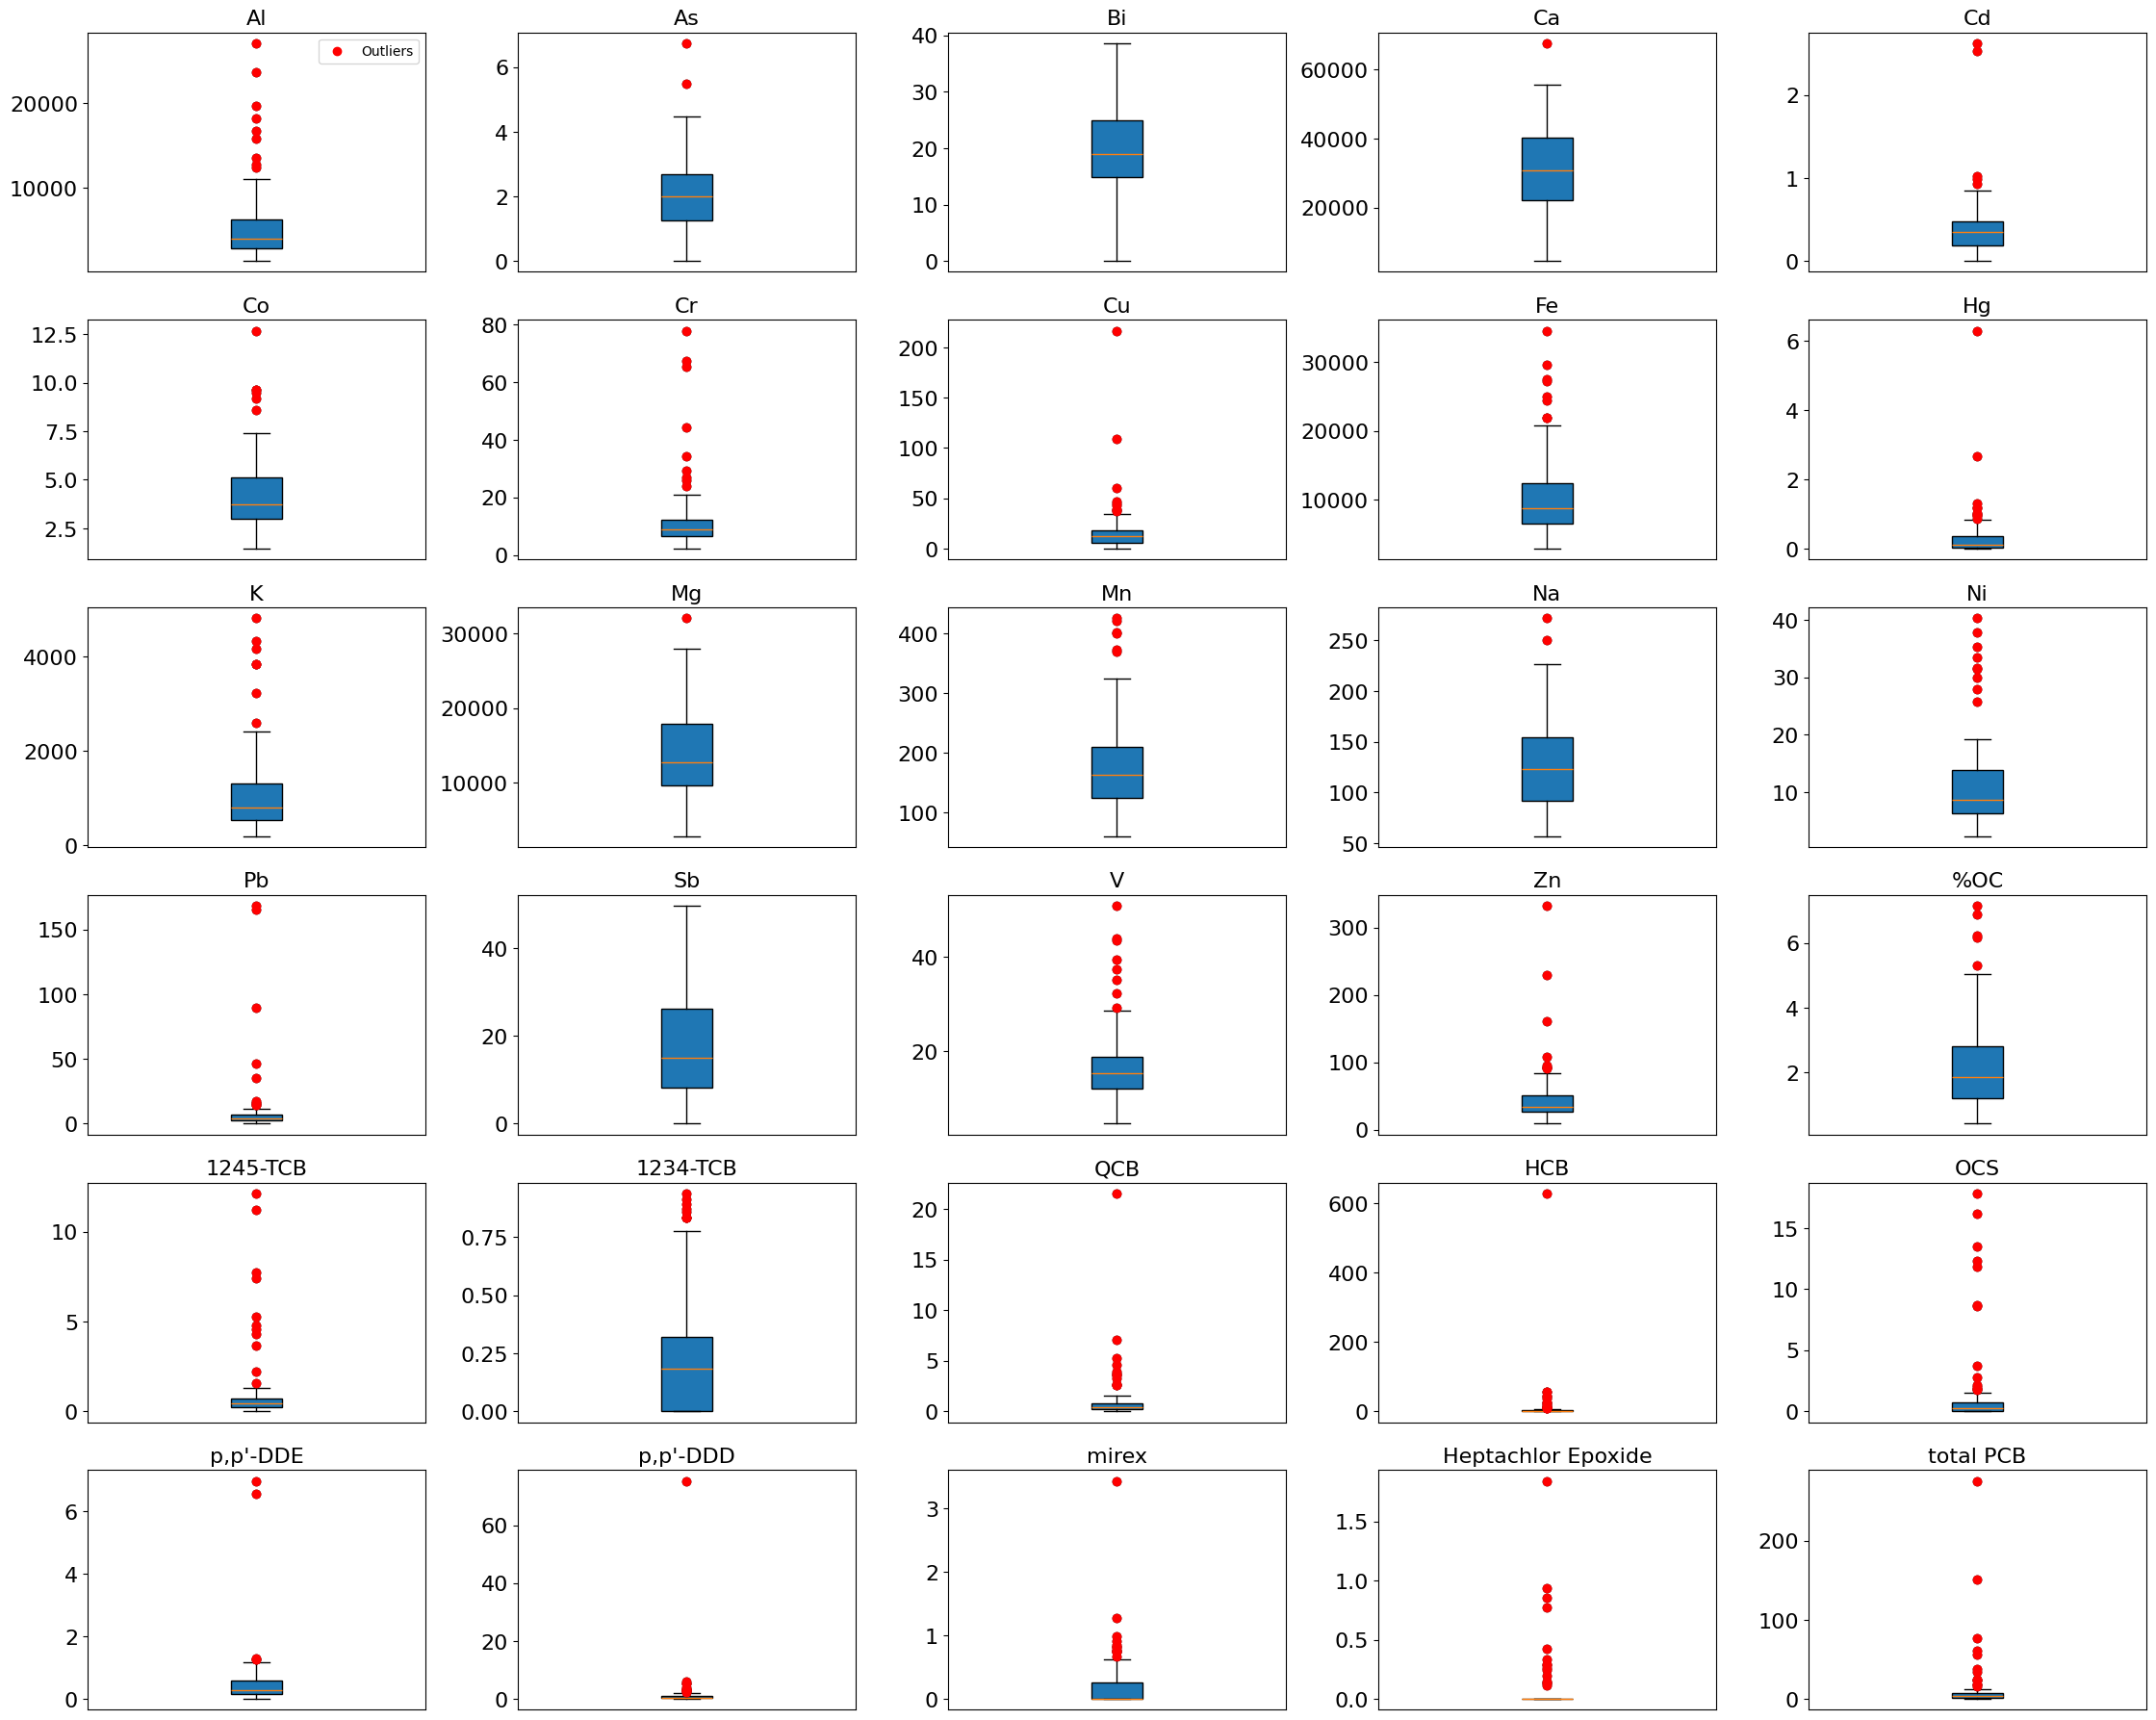

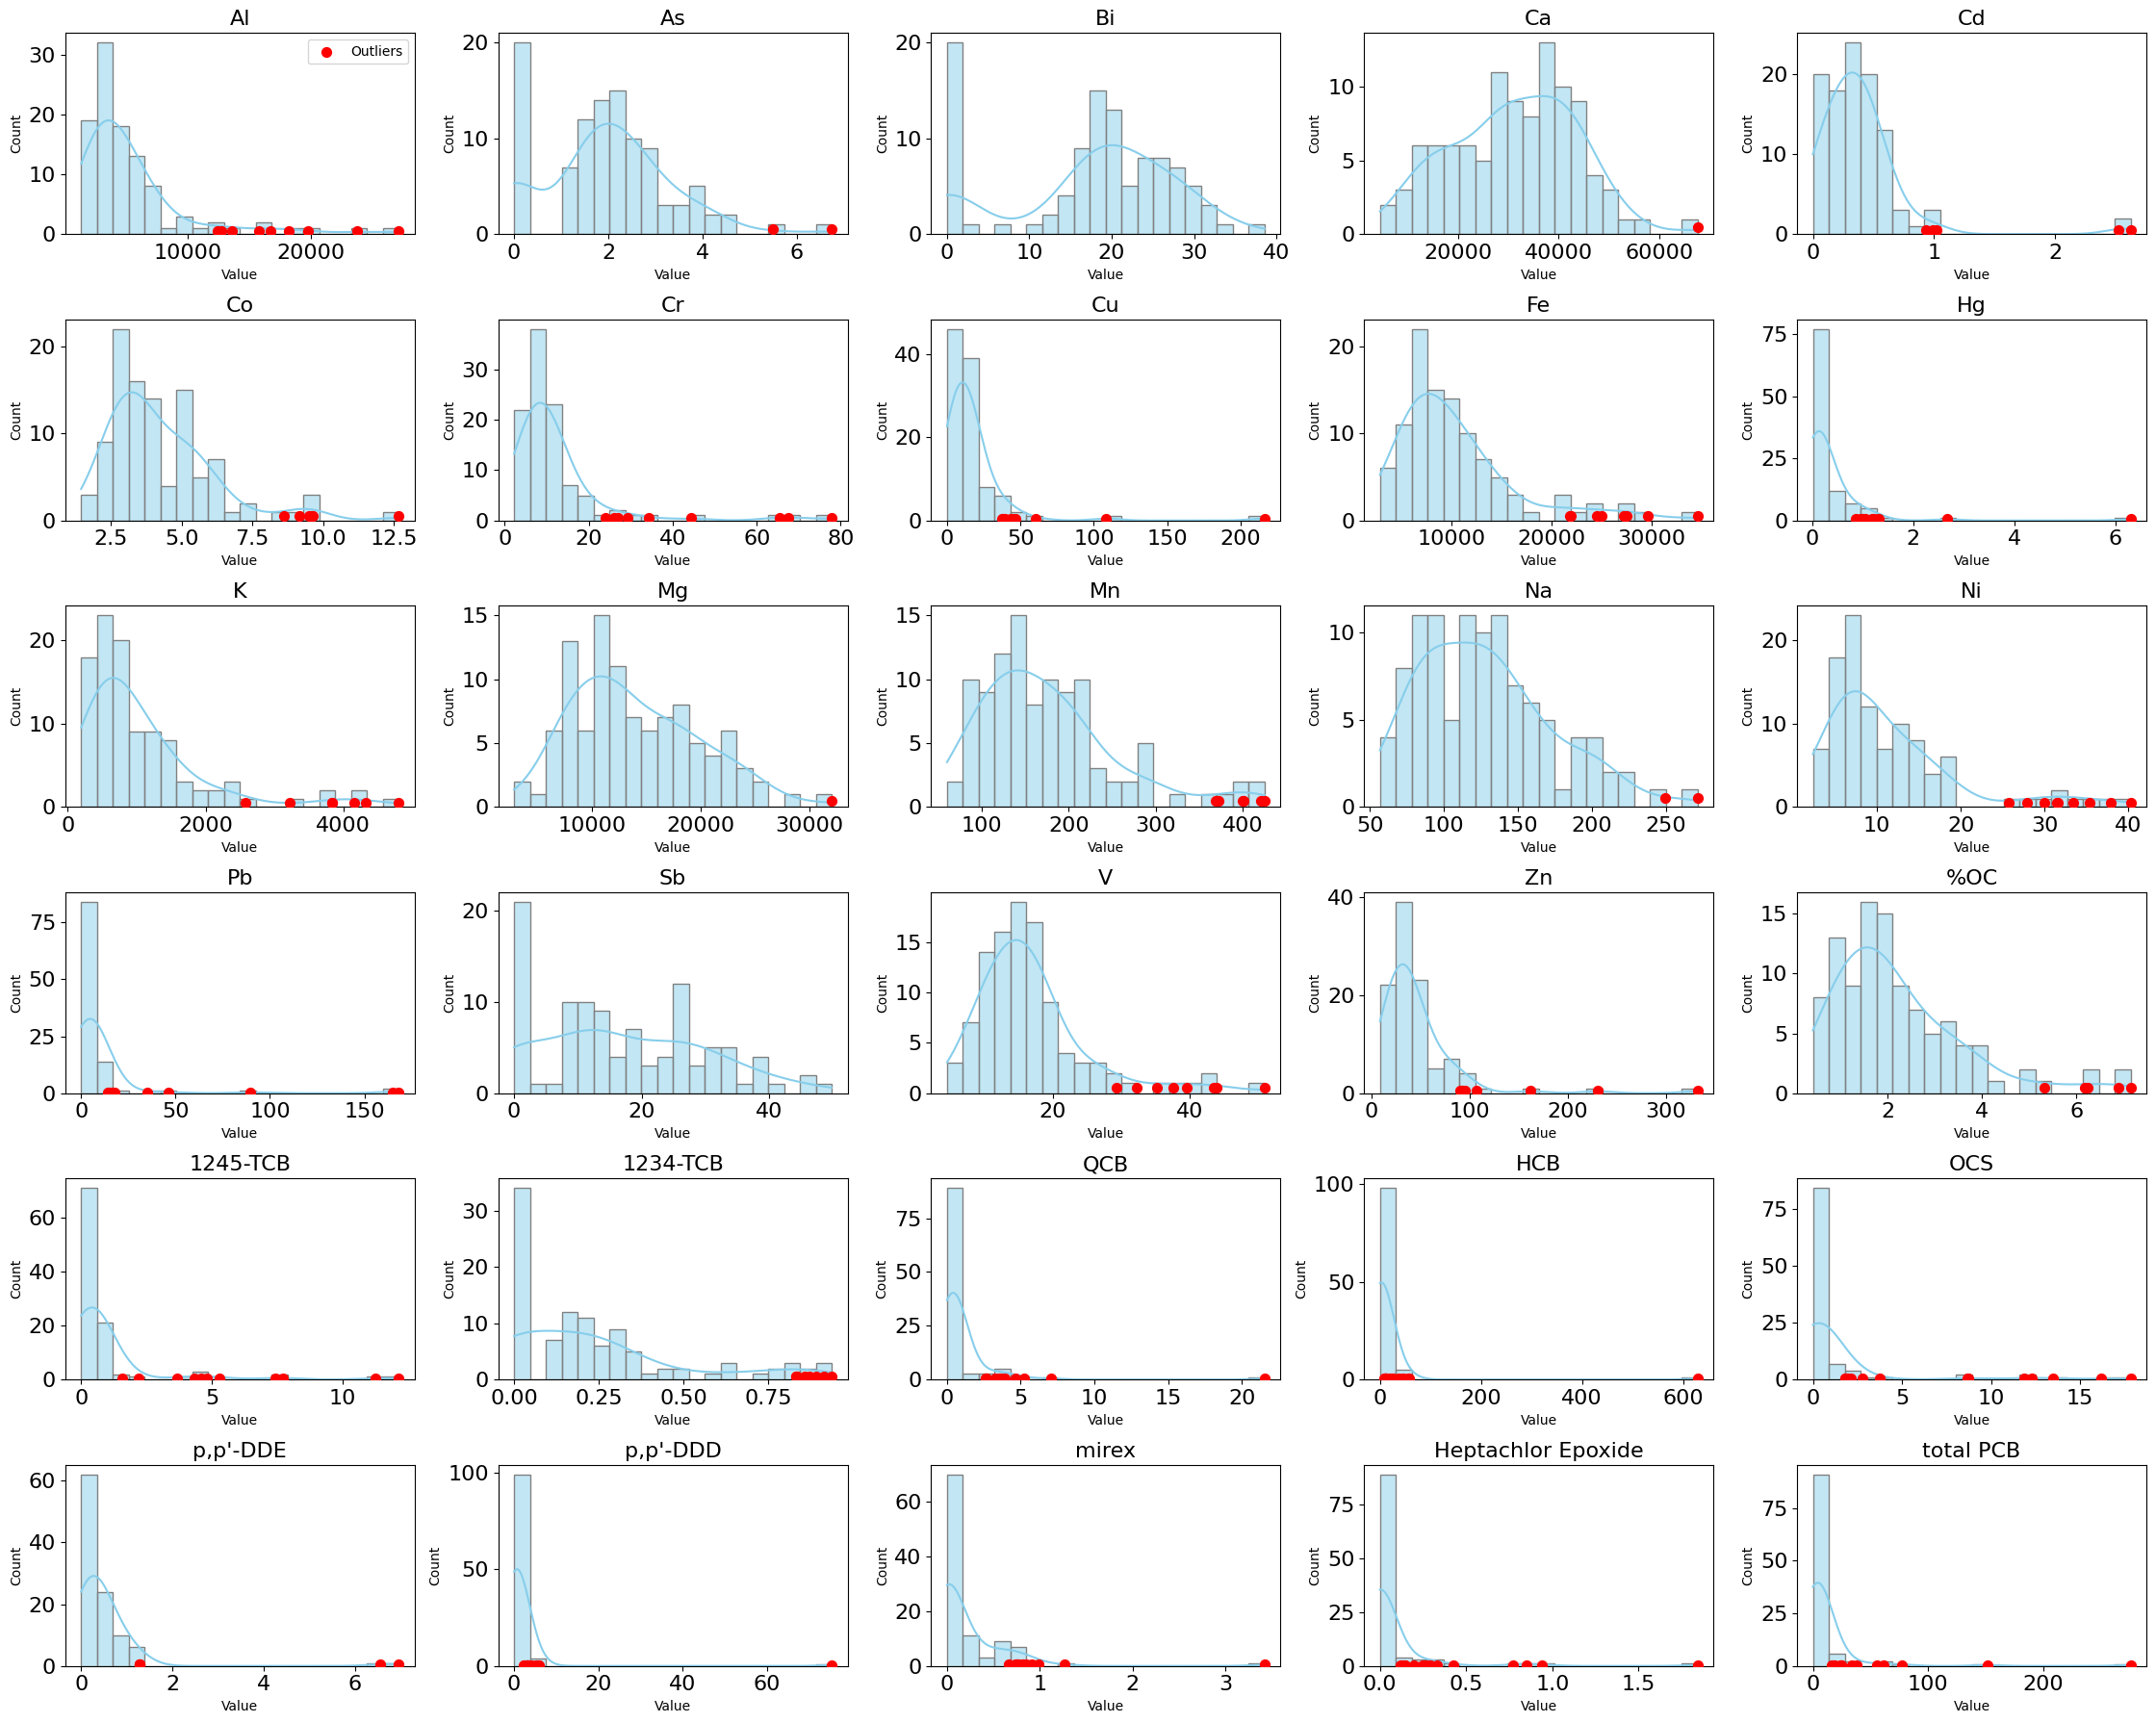

In [624]:
# detect outliers in the chemical data
detect_outliers_iqr(data["chemical"], max_cols=5)

Make logarithmic transformation to the chemical data, and detect outliers in it again.

Al: 2 outliers, portion: 1.92%
As: 21 outliers, portion: 20.19%
Bi: 21 outliers, portion: 20.19%
Ca: 3 outliers, portion: 2.88%
Cd: 2 outliers, portion: 1.92%
Co: 1 outliers, portion: 0.96%
Cr: 5 outliers, portion: 4.81%
Cu: 3 outliers, portion: 2.88%
Fe: 1 outliers, portion: 0.96%
Hg: 5 outliers, portion: 4.81%
K: 0 outliers, portion: 0.00%
Mg: 1 outliers, portion: 0.96%
Mn: 0 outliers, portion: 0.00%
Na: 0 outliers, portion: 0.00%
Ni: 0 outliers, portion: 0.00%
Pb: 6 outliers, portion: 5.77%
Sb: 20 outliers, portion: 19.23%
V: 7 outliers, portion: 6.73%
Zn: 4 outliers, portion: 3.85%
%OC: 0 outliers, portion: 0.00%
1245-TCB: 10 outliers, portion: 9.62%
1234-TCB: 0 outliers, portion: 0.00%
QCB: 12 outliers, portion: 11.54%
HCB: 6 outliers, portion: 5.77%
OCS: 9 outliers, portion: 8.65%
p,p'-DDE: 2 outliers, portion: 1.92%
p,p'-DDD: 10 outliers, portion: 9.62%
mirex: 7 outliers, portion: 6.73%
Heptachlor Epoxide: 15 outliers, portion: 14.42%
total PCB: 5 outliers, portion: 4.81%


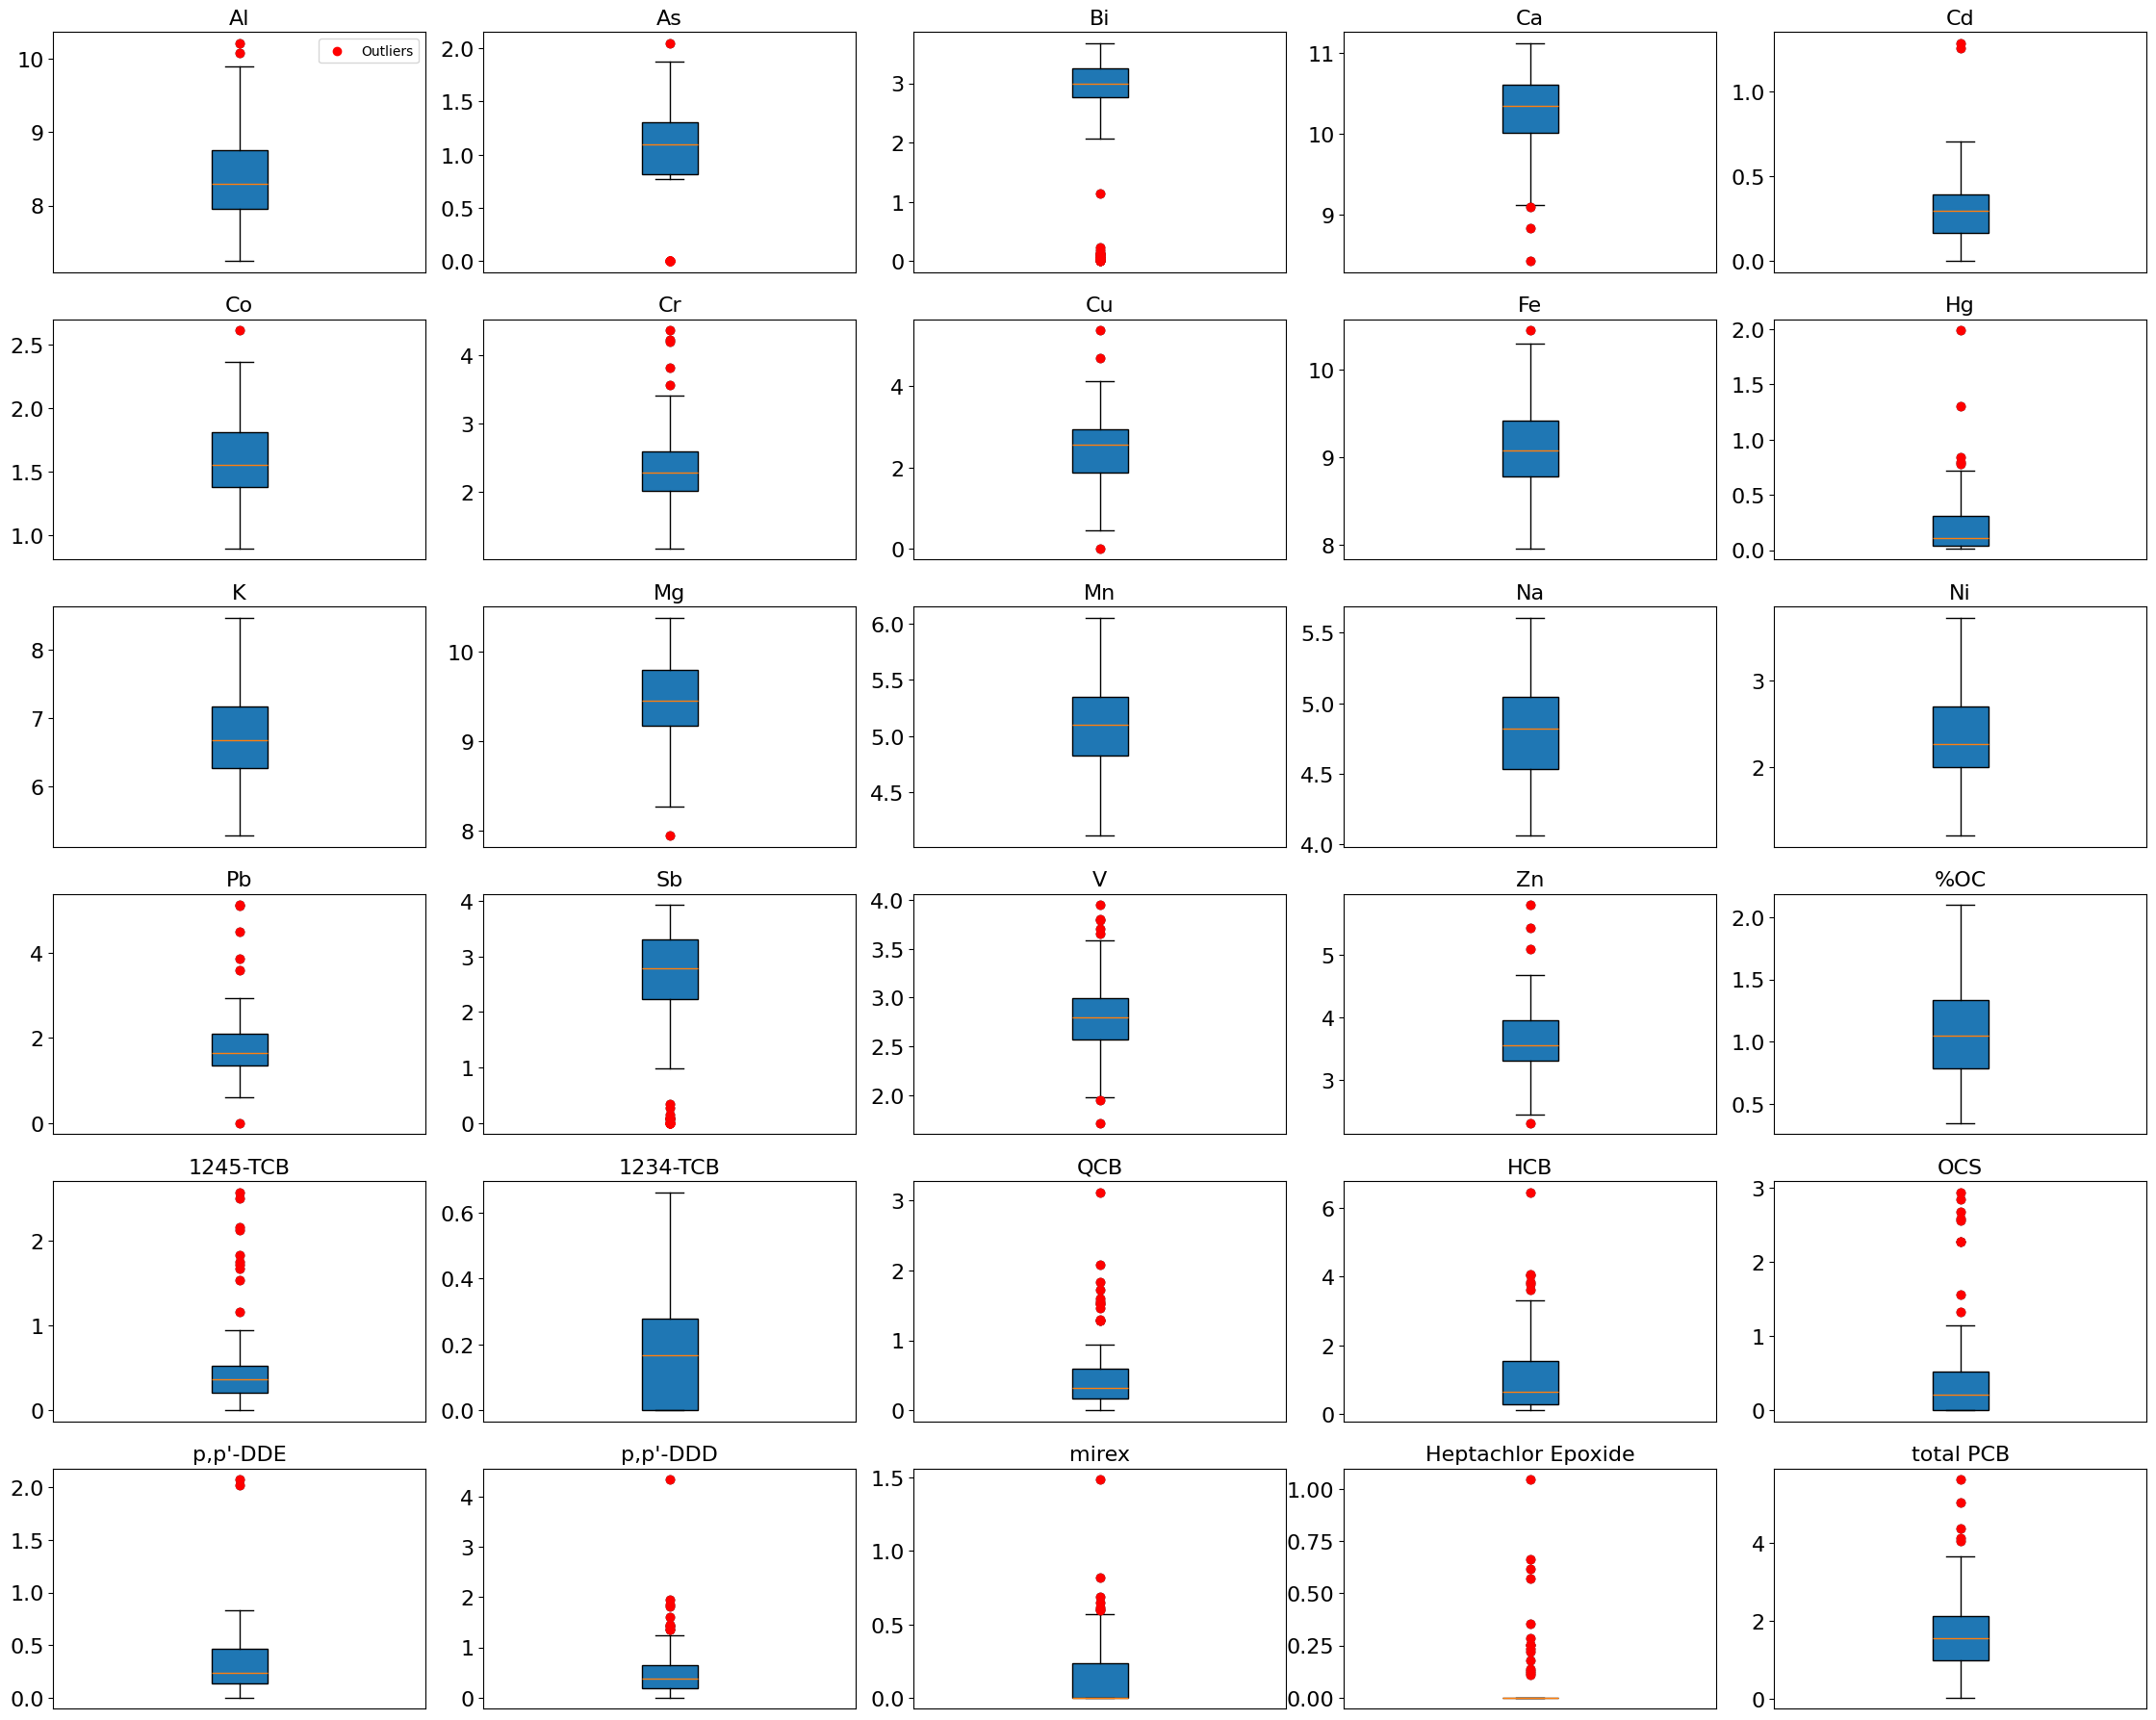

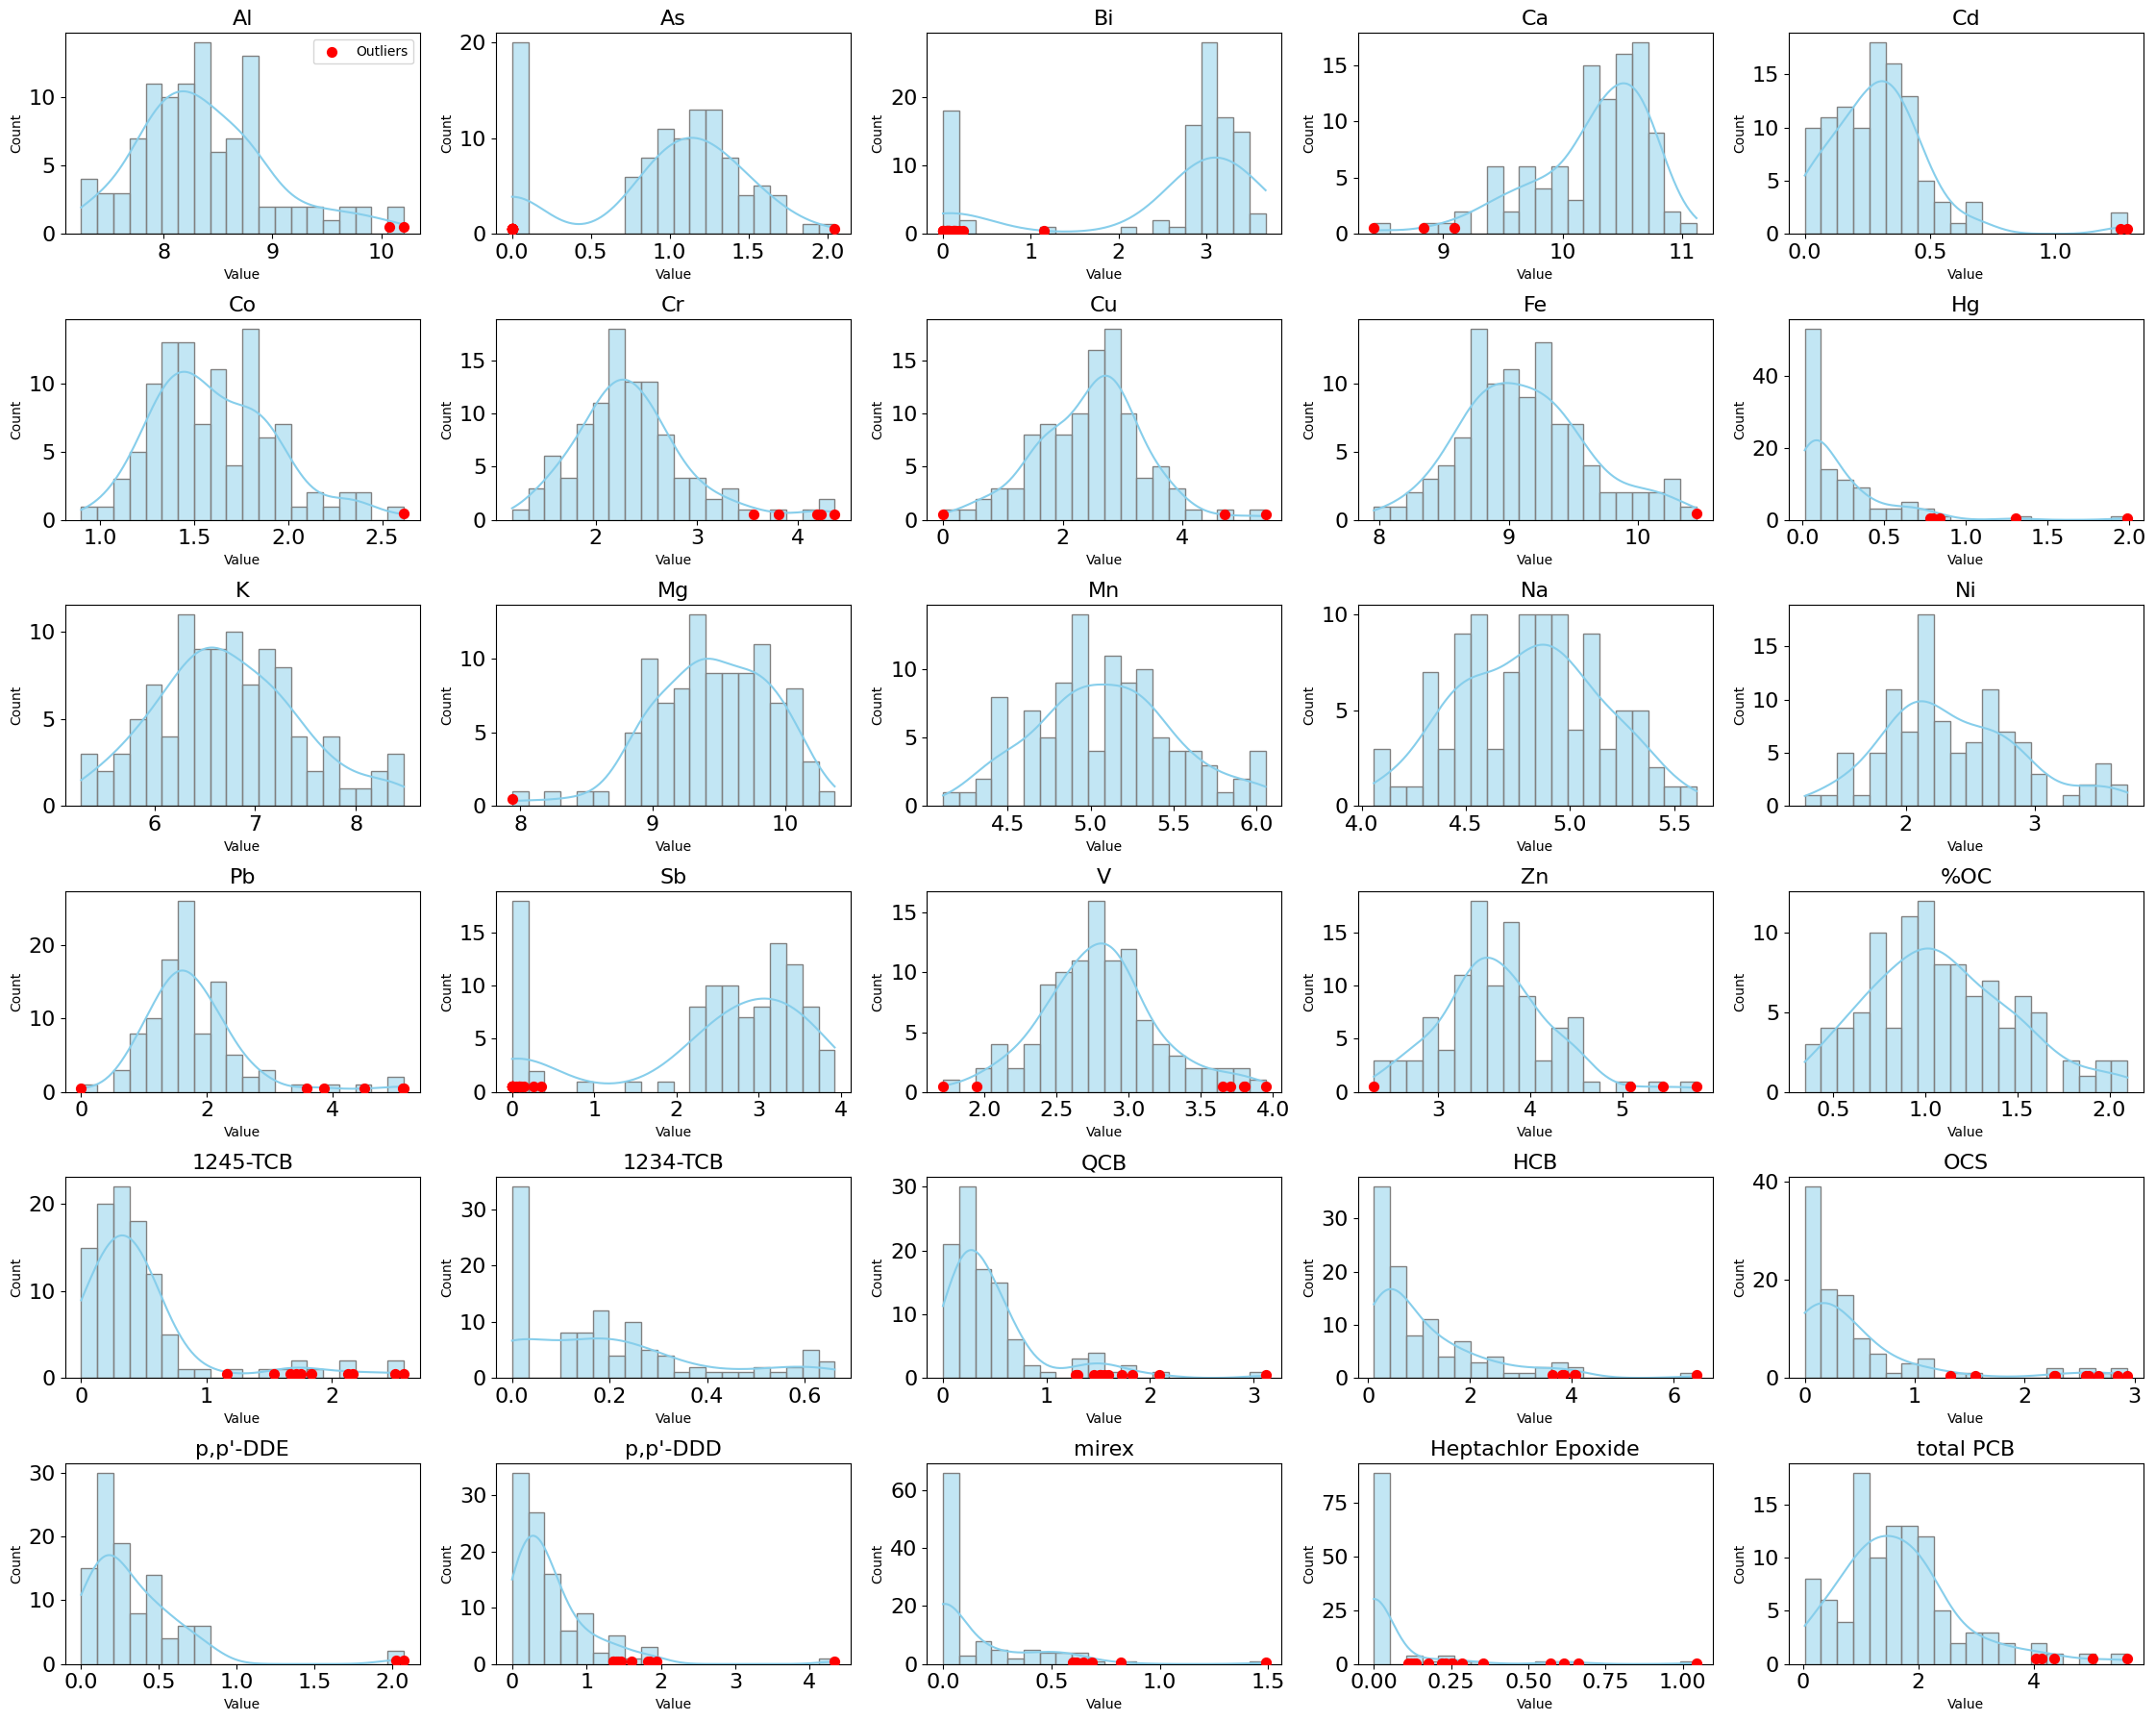

In [625]:
# make logarithmic transformation to the chemical data
chemical_log_df = np.log1p(data["chemical"])
detect_outliers_iqr(chemical_log_df, max_cols=5)

In [626]:
# put the log-transformed chemical data into the original data frame
chemical_log_df.columns = pd.MultiIndex.from_product([["log_transformed_chemical"], chemical_log_df.columns]) # make the multiindex for the chemical log data
print(f"Before concatenation, the original data has {data.shape[1]} columns.")
data = pd.concat([data, chemical_log_df], axis=1) # concatenate the log-transformed chemical data to the original data
print(f"After concatenation, the original data has {data.shape[1]} columns.")
data

Before concatenation, the original data has 105 columns.
After concatenation, the original data has 135 columns.


ID chemical                                                 \
    StationID       Al     As        Bi     Ca      Cd     Co      Cr   
0          S1     1501  2.096  25.80000  43640  0.4436  2.096   3.674   
1          S3     4491  0.000   2.14300  33160  0.2120  4.599   7.663   
2          S4     2666  2.188  31.79000  40140  0.5341  2.991   5.672   
3          A5     2283  2.233  20.11000  41360  0.2387  2.702   8.566   
4          S5     6711  4.298  27.48000  43960  1.0240  6.032  11.520   
..        ...      ...    ...       ...    ...     ...    ...     ...   
99        S98    11130  3.168   0.14670  47800  2.5240  7.337  65.470   
100       S99     2826  1.214  15.12000  14960  0.3079  4.025  12.260   
101      S100     2736  1.238   0.04606  12150  0.3220  5.077  19.000   
102      S101     3464  1.908  14.95000  19420  0.1672  3.153   9.429   
103      S102     3098  2.239  17.68000  38220  0.1922  3.210   9.084   

                     ... log_transformed_chemical                      \
          Cu     Fe  ...                 1245-TCB  1234-TCB       QCB   
0     0.0000   5352  ...                 0.000000  0.000000  0.208224   
1     0.5824  34600  ...                 1.838540  0.402958  3.115436   
2     4.0580   7506  ...                 1.162967  0.156950  1.515888   
3     9.5820   8410  ...                 0.225123  0.167372  0.318925   
4    13.4800  11920  ...                 1.757572  0.126971  1.556923   
..       ...    ...  ...                      ...       ...       ...   
99   60.3900  27240  ...                 0.508757  0.606263  0.297379   
100  12.7200   8958  ...                 0.668780  0.503914  0.262032   
101  19.3900  13880  ...                 0.348398  0.148064  0.448068   
102  10.6700   7921  ...                 0.394434  0.135973  0.113044   
103  11.4300   8784  ...                 0.437816  0.135863  0.112839   

                                                                          \
          HCB       OCS  p,p'-DDE  p,p'-DDD     mirex Heptachlor Epoxide   
0    0.367170  0.423562  0.456384  0.195298  0.000000           0.000000   
1    6.444817  2.587710  0.218020  0.146141  0.118335           0.177433   
2    3.281465  0.000000  0.206159  0.435275  0.000000           0.661468   
3    0.169291  0.450924  0.246599  0.388364  0.000000           0.000000   
4    4.045305  0.000000  0.229330  0.453152  0.259487           0.000000   
..        ...       ...       ...       ...       ...                ...   
99   0.914501  0.168327  0.256087  0.679329  0.000000           0.000000   
100  0.232272  0.000000  0.516827  0.493033  0.179751           0.000000   
101  2.348781  0.364557  0.826511  1.938926  0.242550           0.000000   
102  0.260450  0.427039  0.764929  0.874483  0.616653           0.000000   
103  0.318430  0.149433  0.119010  0.109231  0.000000           0.000000   

               
    total PCB  
0    0.243656  
1    1.582680  
2    2.054938  
3    0.925973  
4    2.380878  
..        ...  
99   4.037824  
100  1.926770  
101  4.131996  
102  2.104875  
103  1.208032  

[104 rows x 135 columns]

## Last step: store all the transformed data locally

This multi-level column indexed data frame can be stored as an excel file to be read later for easy access.

In [627]:
data.columns.levels[0]

Index(['ID', 'chemical', 'environmental', 'location',
       'log_bi_transformed_taxa', 'log_transformed_chemical',
       'log_transformed_taxa', 'octave_transformed_taxa', 'taxa'],
      dtype='object')

In [628]:
# rearrange the column positions to have a more organized view
top_order = ['ID','location','chemical', 'log_transformed_chemical', 
             'taxa', 'log_transformed_taxa', 'log_bi_transformed_taxa',
             'octave_transformed_taxa', 'environmental']
data = data.reindex(columns=top_order, level=0)
data.head()
# usually need to run only one time
data.to_excel("../data/processed_data/multile_indexed_transformed_full_data.xlsx")

# Assess sediment contamination

Based on Jian's thesis, here i will use PCA on the transformed chemical data, and then set criteria to find the PCs that capture the most variation of the pollutants(high loadings on these pollutant variables), and then use these selected PCs to assess the sediment contamination.


First, **a customized PCA function that returns the loadings of all PCs on the original variables is defined, which is used to find the PCs that capture the most 
variation of the pollutants.**

## Read the data that will be used in this section

This data is actually the finally processed data in last section, a full data set with all the transformed taxa and chemical data, ready for PCA.

In [629]:
data = pd.read_excel("../data/processed_data/multile_indexed_transformed_full_data.xlsx", header=[0, 1], index_col=0)
data.head()

ID              location                                           \
  StationID stress_level Location Latitude Longitude       geo_coordinates   
0        S1    -2.446806      SCR    43.01    -82.41  POINT (-82.41 43.01)   
1        S3     0.505028      SCR    42.95    -82.43  POINT (-82.43 42.95)   
2        S4    -2.047317      SCR    42.92    -82.45  POINT (-82.45 42.92)   
3        A5    -1.810714      SCR    42.88    -82.46  POINT (-82.46 42.88)   
4        S5     0.943809      SCR    42.87    -82.46  POINT (-82.46 42.87)   

  chemical                        ... octave_transformed_taxa                \
        Al     As      Bi     Ca  ...                Hydrozoa     Hirudinea   
0     1501  2.096  25.800  43640  ...            3.203427e-15  3.203427e-15   
1     4491  0.000   2.143  33160  ...            2.138077e+00  3.523769e-15   
2     2666  2.188  31.790  40140  ...            3.079099e+00  1.922056e-15   
3     2283  2.233  20.110  41360  ...            2.242399e-15  2.242399e-15   
4     6711  4.298  27.480  43960  ...            2.242399e-15  1.862702e+00   

                                                           environmental  \
    Turbellaria    Gastropoda   Sphaeriidae Total Organic Carbon (LOI %)   
0  3.203427e-15  3.203427e-15  3.203427e-15                         0.41   
1  3.523769e-15  2.804993e+00  3.523769e-15                         1.19   
2  1.922056e-15  1.922056e-15  2.550633e+00                         1.46   
3  2.242399e-15  2.242399e-15  2.242399e-15                         1.10   
4  1.862702e+00  3.269402e+00  3.269402e+00                         2.76   

                                           \
  Water Depth (m) Water Temperature (¬∞C)   
0             4.6                   20.77   
1             3.0                   20.33   
2             4.6                   20.03   
3             5.0                   19.78   
4             1.5                   19.86   

                                                                    
  Dissolved Oxygen Concentration (mg/L) Median Particle Size (Phi)  
0                                 10.03                       1.43  
1                                 10.26                       1.20  
2                                  9.97                       1.10  
3                                  9.03                      -1.30  
4                                  8.50                       1.68  

[5 rows x 135 columns]

In [630]:
# define the customized PCA analysis function to return either loadings or scores
import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

def pca_analysis(df, n_components=None, scale=True, return_loadings=True):
    """
    Perform PCA on a DataFrame of numeric variables and return either:
      - loadings: DataFrame of PCA loadings (correlations between PCs and original variables)
      - scores:  DataFrame of principal‐component scores for each observation

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing the raw numeric variables (one column per variable).
    n_components : int or None, optional
        Number of principal components to compute. If None, all components are returned.
    scale : bool, optional
        If True, standardize variables to zero mean and unit variance before PCA.
    return_loadings : bool, default True
        If True, return the loadings matrix (and append explained variance as last row).
        If False, return the PC scores for each row of `df`.

    Returns
    -------
    pandas.DataFrame
        If return_loadings=True:
            DataFrame of shape (n_features+1)×n_PCs, indexed by feature-names plus
            an 'Explained_Variance' row.
        If return_loadings=False:
            DataFrame of shape n_samples×n_PCs, indexed by `df.index`.
    """
    # 1) select numeric columns
    features = df.select_dtypes(include=["number"])
    
    # 2) optionally standardize
    if scale:
        scaler = StandardScaler()
        X = scaler.fit_transform(features.values)
    else:
        X = features.values
    
    # 3) PCA fit
    pca = PCA(n_components=n_components)
    pca.fit(X)
    
    # 4a) Build loadings DataFrame
    pcs = [f"PC{i+1}" for i in range(pca.components_.shape[0])]
    loadings = pd.DataFrame(
        pca.components_.T,
        index=features.columns,
        columns=pcs
    )
    # append explained variance ratio as a row
    loadings.loc['Explained_Variance'] = pca.explained_variance_ratio_
    
    if return_loadings:
        return loadings
    
    # 4b) Or build scores DataFrame (projections of each sample)
    scores = pca.transform(X)
    scores_df = pd.DataFrame(
        scores,
        index=df.index,
        columns=pcs
    )
    return scores_df

## Set the criteria to filter PCs based on loadings of pollutant

Some of the chemical elements are pollutants and only from anthropogenic sources, so they are the main focus of the PCA.

Some of the elements are partially from natural sources and partially from anthropogenic sources, so they may not that disturbing like the pollutants, but it needs to be considered further.

Currently, I set the criteria to consider all these elements except the natural elements as pollutants, based on the explanation in
the data set that Proj.Jan sent to me. <span style = "color:blue">only the high loadings on these pollutants</span> will make one PC be considered as a pollutant PC, which will be added later, to form the SumReal scores.

In [631]:
# the elements have '1' values are the pollutants, and the elements have '0' values are the nontoxic elements
if_pollutants_dict = {
    "Al": "non-pollutant",  # Earth element (nontoxic)
    "As": "pollutant",      # Trace Metal (pollutant)
    "Bi": "pollutant",
    "Ca": "non-pollutant",
    "Cd": "pollutant",
    "Co": "pollutant",
    "Cr": "pollutant",
    "Cu": "pollutant",
    "Fe": "non-pollutant",
    "Hg": "pollutant",
    "K": "non-pollutant",
    "Mg": "non-pollutant",
    "Mn": "pollutant",
    "Na": "non-pollutant",
    "Ni": "pollutant",
    "Pb": "pollutant",
    "Sb": "pollutant",
    "V": "pollutant",
    "Zn": "pollutant",
    "%OC": "non-pollutant",  # Binding agent (not a pollutant, here labeled nontoxic for simplicity)
    "1245-TCB": "pollutant",  # Hydrocarbon pollutant
    "1234-TCB": "pollutant",
    "QCB": "pollutant",
    "HCB": "pollutant",
    "OCS": "pollutant",
    "p,p'-DDE": "pollutant",  # organochlorine pesticide
    "p,p'-DDD": "pollutant",
    "mirex": "pollutant",
    "Heptachlor Epoxide": "pollutant",
    "total PCB": "pollutant"  # Sum of all PCBs (pollutant)
}

In [632]:
# visualize the loadings of each element across the PCs
import matplotlib.pyplot as plt
import numpy as np

def plot_pca_loadings(loadings, explained_variance_row, group_dict, group_colors=None, figsize=(16, 10), fontsize=8):
    """
    Plot horizontal bar charts of PCA loadings for each principal component,
    coloring each variable by its group label.

    Parameters
    ----------
    loadings : pandas.DataFrame
        DataFrame with variables as index and PCs as columns (e.g. output of pca_analysis).
    group_dict : dict
        Mapping from variable name (loadings.index) to a group label (e.g. 'pollutant' or 'non-pollutant').
    group_colors : dict, optional
        Mapping from group label to a matplotlib color (e.g.
        {'pollutant':'red','non-pollutant':'blue'}). If None, default colors will be assigned.
    figsize : tuple, default (6, 8)
        Size of each PC’s figure.
    fontsize : int, default 8
        Font size for variable labels on the y-axis.
    """
    # Determine all group labels present
    unique_groups = sorted({group_dict.get(var, None) for var in loadings.index})
    
    # Assign colors if none provided
    if group_colors is None:
        base_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        group_colors = {g: base_colors[i % len(base_colors)]
                        for i, g in enumerate(unique_groups)}
    
    # Loop through each PC column
    # Prepare for a grid of subplots: 5 columns, enough rows for all PCs
    n_pcs = len(loadings.columns)
    n_cols = 5
    n_rows = int(np.ceil(n_pcs / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(n_cols * 5, n_rows * 4), squeeze=False)
    unique_groups = sorted({group_dict.get(var, None) for var in loadings.index})

    # Assign colors if none provided
    if group_colors is None:
        base_colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
        group_colors = {g: base_colors[i % len(base_colors)] for i, g in enumerate(unique_groups)}

    for i, pc in enumerate(loadings.columns):
        row, col = divmod(i, n_cols)
        ax = axes[row, col]
        variables = loadings.index.tolist()
        values = loadings[pc].values
        bar_colors = [group_colors[group_dict.get(var, None)] for var in variables]
        x_pos = np.arange(len(variables))
        ax.bar(x_pos, values, color=bar_colors)
        ax.set_xticks(x_pos)
        ax.set_xticklabels(variables, fontsize=fontsize, rotation=90)
        ax.set_ylabel(f'Loading on {pc}', fontsize=16)
        ax.tick_params(axis='y', labelsize=16)
        ax.tick_params(axis='x', labelsize=9)
        ax.set_xlabel('')
        ax.set_title(f'{pc}: explained variance: {explained_variance_row[pc]:.4%}', fontsize=16)
        ax.grid(True, linestyle='--', alpha=0.5)
        # Only add legend to the first subplot
        if i == 0:
            handles = [
                plt.Line2D([0], [0], marker='s', color='w',
                           markerfacecolor=group_colors[g], markersize=10,
                           label=g)
                for g in unique_groups
            ]
            ax.legend(handles=handles, title='Group', loc='best')
        # Remove x-tick labels for all but the last row of subplots
        if row < n_rows - 1:
            ax.set_xticklabels([])
            
            
    # Hide unused axes
    for j in range(i + 1, n_rows * n_cols):
        row, col = divmod(j, n_cols)
        fig.delaxes(axes[row, col])
    plt.tight_layout()
    plt.show()

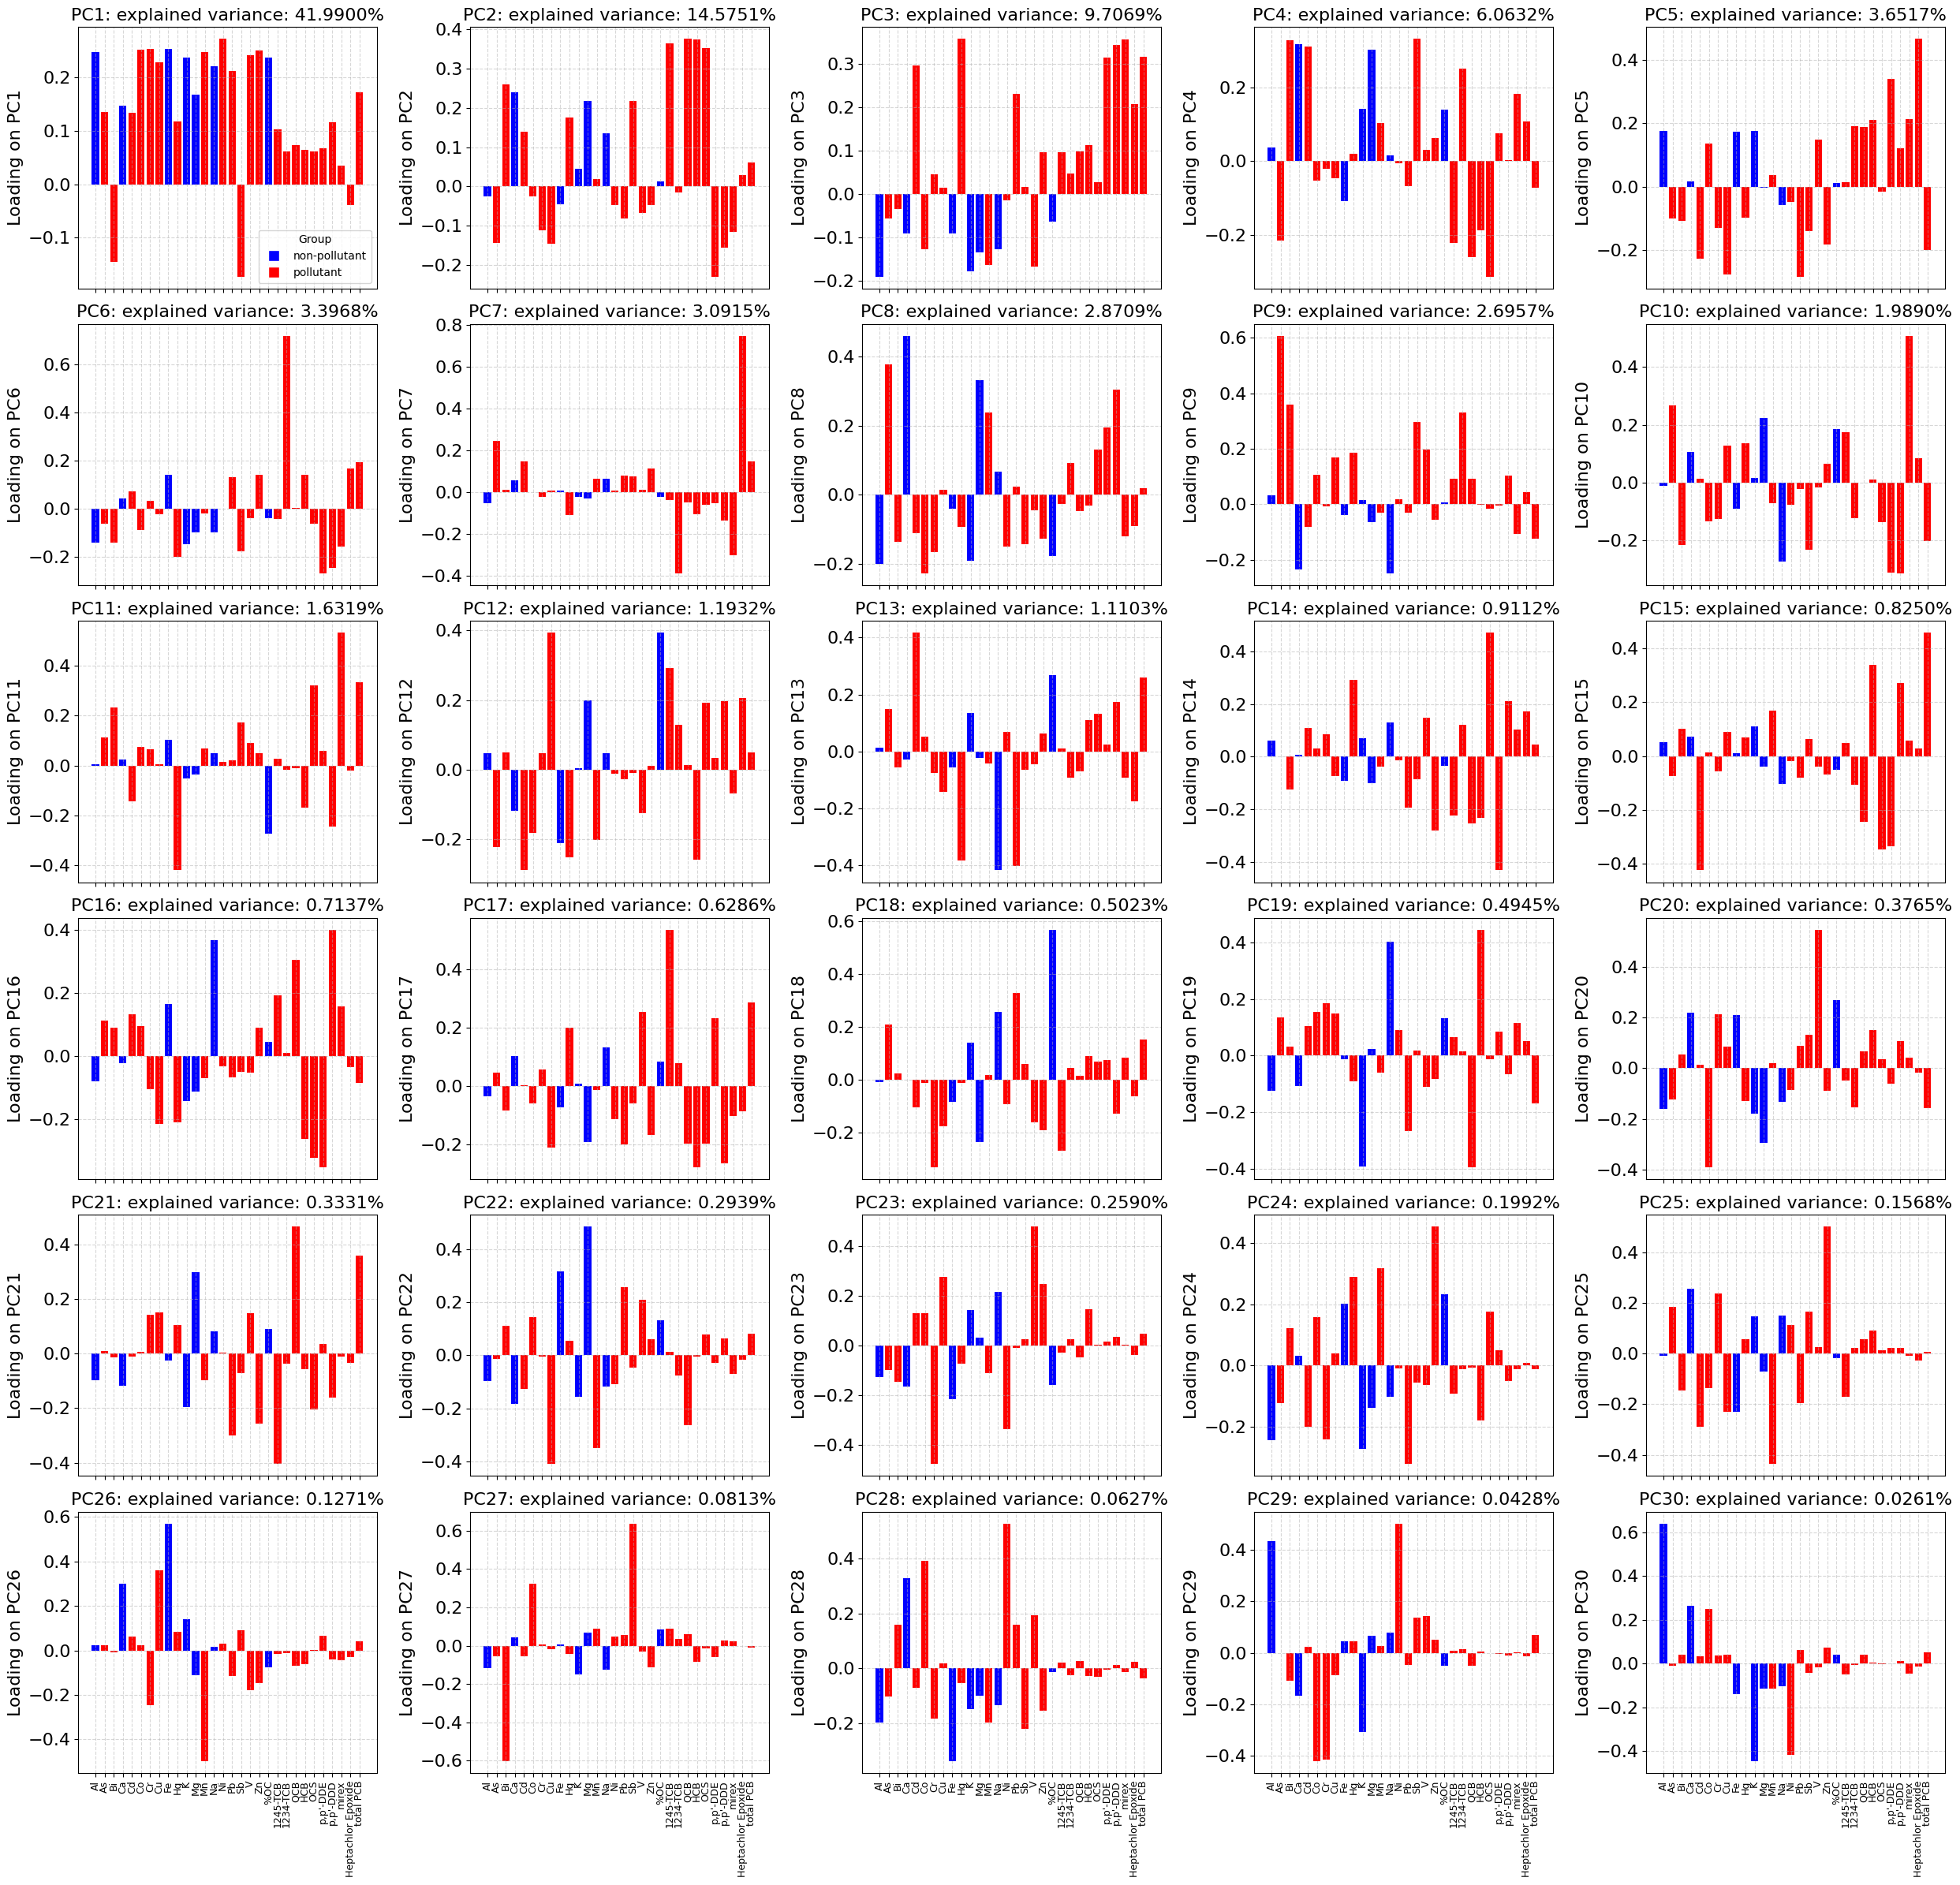

<Figure size 640x480 with 0 Axes>

In [633]:
# Perform PCA on the log-transformed chemical data, get the loadings to find the main chemical components
loadings = pca_analysis(data["log_transformed_chemical"], scale=True)
# extract the explained variance row and drop it from loadings
explained_variance_row = loadings.loc['Explained_Variance']
loadings = loadings.drop('Explained_Variance')
# Plot PCA loadings with custom colors for pollutants and non-pollutants
plot_pca_loadings(loadings, explained_variance_row, if_pollutants_dict, group_colors={"pollutant": 'red', "non-pollutant": 'blue'},)
plt.savefig("../results/preliminary_results/pca_loadings_chemical.png", dpi=300)

After checking the loadings of the PCs on the log-transformed chemical data, I found some PCs are highly loaded on some pollutants with majorly positive 
or negative loadings, which keeps the sum of these PCs meaningful to avoid the cancellation of positive and negative loadings.

On the other hand, there should be siginificant explained variance of these selected PCs, at least 2% of the total variance that each selected PC should explain.

Based on the above criteria, I will select the PCs:
- PC1, PC2, PC3, PC5, PC6, PC7, PC9

These PCs capture more than 2% of the total variance and with majorly positive loadings on the pollutants.

Store these selected PCs in a dictionary. To an observation, add its values on these selected PCs to get the SumReal score, which is the sediment contamination score.

In [634]:
# store the PCs selected for adding SumReal scores
selected_PCs = ['PC1', 'PC2', 'PC3', 'PC5', 'PC6', 'PC7', 'PC9']

# apply the same PCA analysis to the log-transformed taxa data and return the scores
pca_scores = pca_analysis(data["log_transformed_taxa"], scale=True, return_loadings=False)

# map the scores into 0-1 by min-max normalization
pca_scores_normalized = (pca_scores - pca_scores.min()) / (pca_scores.max() - pca_scores.min())
pca_scores_normalized.head()

PC1       PC2       PC3       PC4       PC5       PC6       PC7  \
0  0.069892  0.323338  0.329504  0.497324  0.367483  0.594826  0.526923   
1  0.219748  0.388378  0.229300  0.494445  0.580562  0.552919  0.601147   
2  0.605005  0.563446  0.146841  0.611696  0.842441  0.733408  0.785308   
3  0.683126  0.449020  0.001087  0.567240  0.357477  0.838680  0.228635   
4  0.166664  0.451248  0.745105  0.478300  0.545584  0.377587  0.329551   

        PC8       PC9      PC10      PC11      PC12      PC13      PC14  \
0  0.543033  0.526714  0.428673  0.466144  0.469352  0.624081  0.324750   
1  0.359237  0.521872  0.627204  0.484129  0.678463  0.534298  0.212200   
2  0.573674  0.632251  0.417982  0.536036  0.643335  0.000000  0.144593   
3  0.455928  0.723329  0.444238  0.254767  0.000000  0.349121  0.000000   
4  0.469792  0.555303  0.374261  0.189470  0.498247  0.656147  0.459525   

       PC15      PC16  
0  0.387830  0.469868  
1  0.424244  0.514221  
2  0.414735  1.000000  
3  0.702523  0.289096  
4  0.000000  0.466089

In [635]:
# take out the selected PCs and sum their values along the rows(axis = 1) to get the SumRel scores
data[("SumRel", "stress_level")] = pca_scores[selected_PCs].sum(axis=1)
data[("SumRel", "standardized_stress_level")] = pca_scores_normalized[selected_PCs].sum(axis=1)
data.head()

ID              location                                           \
  StationID stress_level Location Latitude Longitude       geo_coordinates   
0        S1    -2.446806      SCR    43.01    -82.41  POINT (-82.41 43.01)   
1        S3     0.505028      SCR    42.95    -82.43  POINT (-82.43 42.95)   
2        S4    -2.047317      SCR    42.92    -82.45  POINT (-82.45 42.92)   
3        A5    -1.810714      SCR    42.88    -82.46  POINT (-82.46 42.88)   
4        S5     0.943809      SCR    42.87    -82.46  POINT (-82.46 42.87)   

  chemical                        ... octave_transformed_taxa                \
        Al     As      Bi     Ca  ...             Turbellaria    Gastropoda   
0     1501  2.096  25.800  43640  ...            3.203427e-15  3.203427e-15   
1     4491  0.000   2.143  33160  ...            3.523769e-15  2.804993e+00   
2     2666  2.188  31.790  40140  ...            1.922056e-15  1.922056e-15   
3     2283  2.233  20.110  41360  ...            2.242399e-15  2.242399e-15   
4     6711  4.298  27.480  43960  ...            1.862702e+00  3.269402e+00   

                               environmental                  \
    Sphaeriidae Total Organic Carbon (LOI %) Water Depth (m)   
0  3.203427e-15                         0.41             4.6   
1  3.523769e-15                         1.19             3.0   
2  2.550633e+00                         1.46             4.6   
3  2.242399e-15                         1.10             5.0   
4  3.269402e+00                         2.76             1.5   

                                                                 \
  Water Temperature (¬∞C) Dissolved Oxygen Concentration (mg/L)   
0                   20.77                                 10.03   
1                   20.33                                 10.26   
2                   20.03                                  9.97   
3                   19.78                                  9.03   
4                   19.86                                  8.50   

                                   SumRel                            
  Median Particle Size (Phi) stress_level standardized_stress_level  
0                       1.43    -4.127157                  2.738680  
1                       1.20    -1.440226                  3.093926  
2                       1.10     7.029481                  4.308701  
3                      -1.30     0.627823                  3.281353  
4                       1.68    -0.339393                  3.171043  

[5 rows x 137 columns]

In [636]:
# Label top 20% as 'reference', bottom 20% as 'degraded' in the Sediment_Contamination index level
stress_scores = data[("SumRel", "standardized_stress_level")]
quantile_80 = stress_scores.quantile(0.8)
quantile_25 = stress_scores.quantile(0.25)

# ! need to check again
labels = pd.Series("intermediate", index=stress_scores.index)
labels[stress_scores >= quantile_80] = "reference"
labels[stress_scores <= quantile_25] = "degraded"

data[("SumRel", "site_label")] = labels
data.head()

ID              location                                           \
  StationID stress_level Location Latitude Longitude       geo_coordinates   
0        S1    -2.446806      SCR    43.01    -82.41  POINT (-82.41 43.01)   
1        S3     0.505028      SCR    42.95    -82.43  POINT (-82.43 42.95)   
2        S4    -2.047317      SCR    42.92    -82.45  POINT (-82.45 42.92)   
3        A5    -1.810714      SCR    42.88    -82.46  POINT (-82.46 42.88)   
4        S5     0.943809      SCR    42.87    -82.46  POINT (-82.46 42.87)   

  chemical                        ... octave_transformed_taxa                \
        Al     As      Bi     Ca  ...              Gastropoda   Sphaeriidae   
0     1501  2.096  25.800  43640  ...            3.203427e-15  3.203427e-15   
1     4491  0.000   2.143  33160  ...            2.804993e+00  3.523769e-15   
2     2666  2.188  31.790  40140  ...            1.922056e-15  2.550633e+00   
3     2283  2.233  20.110  41360  ...            2.242399e-15  2.242399e-15   
4     6711  4.298  27.480  43960  ...            3.269402e+00  3.269402e+00   

                 environmental                                          \
  Total Organic Carbon (LOI %) Water Depth (m) Water Temperature (¬∞C)   
0                         0.41             4.6                   20.77   
1                         1.19             3.0                   20.33   
2                         1.46             4.6                   20.03   
3                         1.10             5.0                   19.78   
4                         2.76             1.5                   19.86   

                                                                    \
  Dissolved Oxygen Concentration (mg/L) Median Particle Size (Phi)   
0                                 10.03                       1.43   
1                                 10.26                       1.20   
2                                  9.97                       1.10   
3                                  9.03                      -1.30   
4                                  8.50                       1.68   

        SumRel                                          
  stress_level standardized_stress_level    site_label  
0    -4.127157                  2.738680      degraded  
1    -1.440226                  3.093926  intermediate  
2     7.029481                  4.308701     reference  
3     0.627823                  3.281353  intermediate  
4    -0.339393                  3.171043  intermediate  

[5 rows x 138 columns]

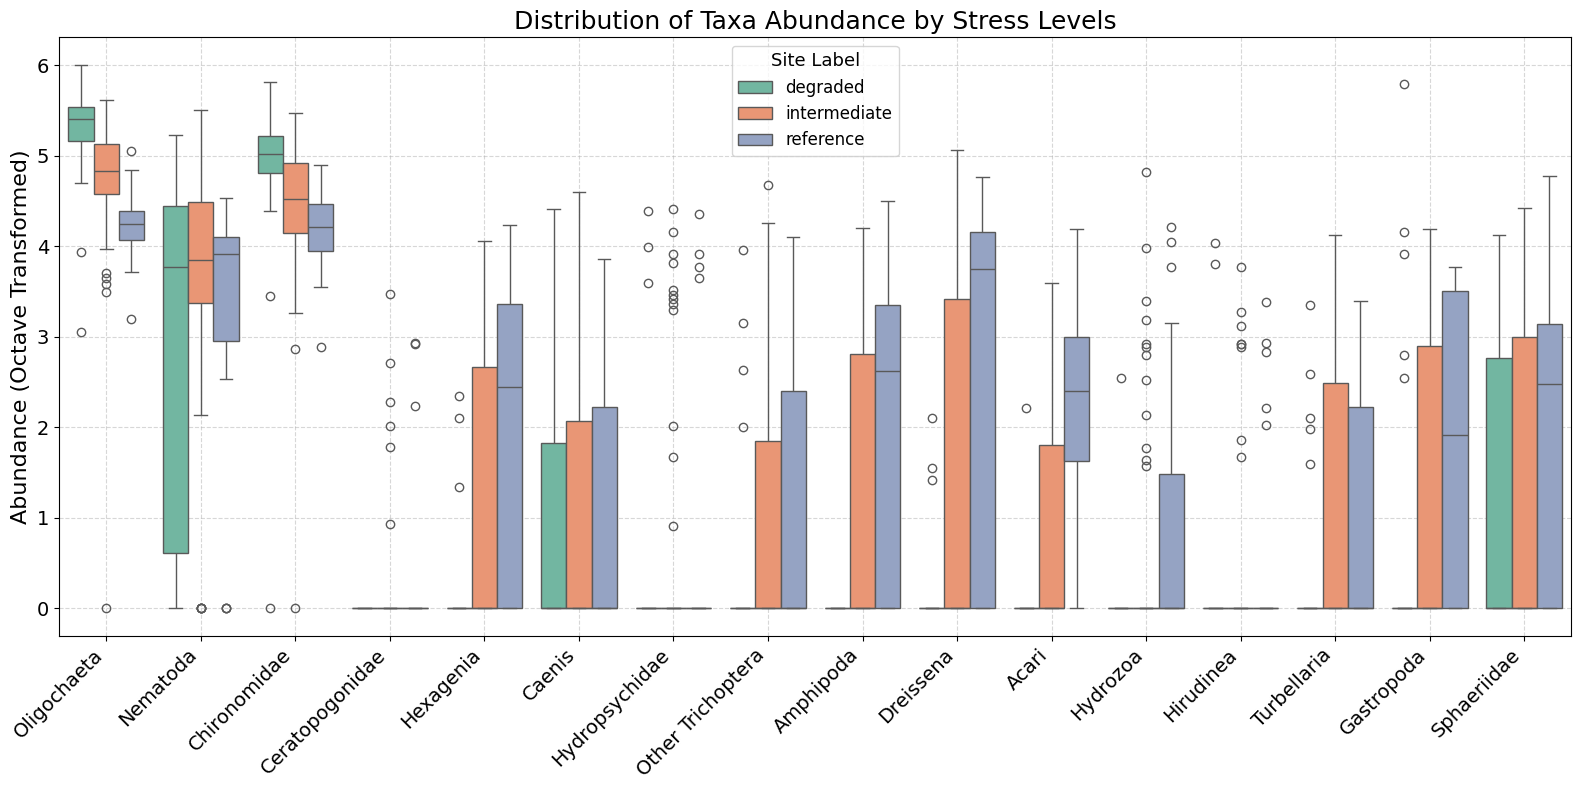

In [637]:
import seaborn as sns

import matplotlib.pyplot as plt

# Prepare the data for plotting: melt the octave_transformed_taxa and join with site labels
taxa_abundance = data["octave_transformed_taxa"].copy()
site_labels = data[("SumRel", "site_label")]
melted = taxa_abundance[taxa_cols].copy()
melted["Site Label"] = site_labels.values
melted = melted.melt(id_vars="Site Label", var_name="Taxa", value_name="Abundance")

plt.figure(figsize=(16, 8))
sns.boxplot(data=melted, x="Taxa", y="Abundance", hue="Site Label", palette="Set2")
plt.xticks(rotation=45, ha='right')
plt.title("Distribution of Taxa Abundance by Stress Levels", fontdict={'fontsize': 18})
plt.xlabel("")
plt.ylabel("Abundance (Octave Transformed)", fontdict={'fontsize': 16})
plt.tick_params(axis='both', which='major', labelsize=14)
plt.grid(True, linestyle='--', alpha=0.5)
plt.legend(title="Site Label", title_fontsize='13', fontsize='12')
plt.tight_layout()
plt.savefig("../results/preliminary_results/taxa_abundance_by_site_label.png", dpi=300)
plt.show()

In [638]:
# convert the descriptive table to latex format and copy to clipboard
import pyperclip

# Get the chemical columns (level 0: 'chemical')
chemical_df = data['chemical']

# Group by site label and describe
desc = chemical_df.groupby(data[("SumRel", "site_label")]).agg(['mean', 'std'])
desc.T

latex_table = desc.T.to_latex(float_format="%.3f", caption="Chemical Descriptive Statistics by Site Label", label="tab:chem_desc")

# Copy LaTeX table to clipboard using pycliper
pyperclip.copy(latex_table)
print("LaTeX table copied to clipboard!")

LaTeX table copied to clipboard!


Now, the sediment contamination scores have been added to the data frame, with two different ways to calculate the scores:
- directly add the PCs values to get the stress_level, the higher eigenvalue the PC has, the more weight it has in the stress_level value: **stress_level**
- map the PCs values into 0-1 by min-max normalization, then add them to get the standardized_stress_level, which makes all selected PCs have equal weight in calculating the stress_level value: **standardized_stress_level**

## Save the data at local storage

Save this data frame to a local file, easy for later access and no need to repeat the above steps again.

In [639]:
# save the data in excel format
data.to_excel('../data/processed_data/multile_indexed_transformed_full_data_with_stress_scores.xlsx')

# Cluster analysis on the reference sites

There are 20% reference sites in the assessed data. We think their taxa composition has not been disturbed by human activities.

There may be some differences in the taxa composition of the references, which can be attributed to the natural variation considering that the human impacts have been minimal.

Read the data with the stress level scores added, and then apply clustering analysis on these reference sites to find their taxa composition patterns.

In [640]:
# read the data 
import pandas as pd

data = pd.read_excel('../data/processed_data/multile_indexed_transformed_full_data_with_stress_scores.xlsx', header=[0, 1], index_col=0)
data.head()

ID              location                                           \
  StationID stress_level Location Latitude Longitude       geo_coordinates   
0        S1    -2.446806      SCR    43.01    -82.41  POINT (-82.41 43.01)   
1        S3     0.505028      SCR    42.95    -82.43  POINT (-82.43 42.95)   
2        S4    -2.047317      SCR    42.92    -82.45  POINT (-82.45 42.92)   
3        A5    -1.810714      SCR    42.88    -82.46  POINT (-82.46 42.88)   
4        S5     0.943809      SCR    42.87    -82.46  POINT (-82.46 42.87)   

  chemical                        ... octave_transformed_taxa                \
        Al     As      Bi     Ca  ...              Gastropoda   Sphaeriidae   
0     1501  2.096  25.800  43640  ...            3.203427e-15  3.203427e-15   
1     4491  0.000   2.143  33160  ...            2.804993e+00  3.523769e-15   
2     2666  2.188  31.790  40140  ...            1.922056e-15  2.550633e+00   
3     2283  2.233  20.110  41360  ...            2.242399e-15  2.242399e-15   
4     6711  4.298  27.480  43960  ...            3.269402e+00  3.269402e+00   

                 environmental                                          \
  Total Organic Carbon (LOI %) Water Depth (m) Water Temperature (¬∞C)   
0                         0.41             4.6                   20.77   
1                         1.19             3.0                   20.33   
2                         1.46             4.6                   20.03   
3                         1.10             5.0                   19.78   
4                         2.76             1.5                   19.86   

                                                                    \
  Dissolved Oxygen Concentration (mg/L) Median Particle Size (Phi)   
0                                 10.03                       1.43   
1                                 10.26                       1.20   
2                                  9.97                       1.10   
3                                  9.03                      -1.30   
4                                  8.50                       1.68   

        SumRel                                          
  stress_level standardized_stress_level    site_label  
0    -4.127157                  2.738680      degraded  
1    -1.440226                  3.093926  intermediate  
2     7.029481                  4.308701     reference  
3     0.627823                  3.281353  intermediate  
4    -0.339393                  3.171043  intermediate  

[5 rows x 138 columns]

## Apply the Ward's hierarchical cluster analysis using Manhattan distance

Not knowing the reason to take this specific clustering linkage and distance metric, only copy-paste from the dissertation.

In [641]:
from scipy.spatial.distance import pdist
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import fcluster

def ward_manhattan_clustering(
    df,
    figure_kwargs=None,
    dendro_kwargs=None,
    n_clusters=None
):
    """
    Perform Ward’s hierarchical clustering using Manhattan distances,
    optionally plot the dendrogram, and return cluster assignments.

    Parameters
    ----------
    df : pandas.DataFrame
        Your full DataFrame to cluster.
    figure_kwargs : dict, optional
        Passed to plt.figure(...) for the dendrogram.
    dendro_kwargs : dict, optional
        Passed to dendrogram(...).
    n_clusters : int, optional
        If provided, cut the tree into exactly this many clusters and return
        an array of cluster labels.

    Returns
    -------
    Z : ndarray
        The linkage matrix.
    labels : ndarray (only if n_clusters is not None)
        Integer cluster label (1..n_clusters) for each row of `df`, in order.
    """
    # 1) compute condensed distances
    D = pdist(df.values, metric='cityblock')

    # 2) linkage
    Z = linkage(D, method='ward') # method: ward

    # 3) plot if desired
    plt.figure(**(figure_kwargs or {}))
    dendrogram(
        Z,
        labels=df.index.astype(str).tolist(),
        **(dendro_kwargs or {})
    )
    plt.title("Ward linkage (Manhattan distances)")
    plt.xlabel("Sample")
    plt.ylabel("Distance")
    plt.tight_layout()
    plt.show()

    # 4) cut into n_clusters if requested
    if n_clusters is not None:
        # criterion='maxclust' ensures exactly n_clusters
        cluster_assignments = fcluster(Z, t=n_clusters, criterion='maxclust')
        return Z, cluster_assignments

    return Z

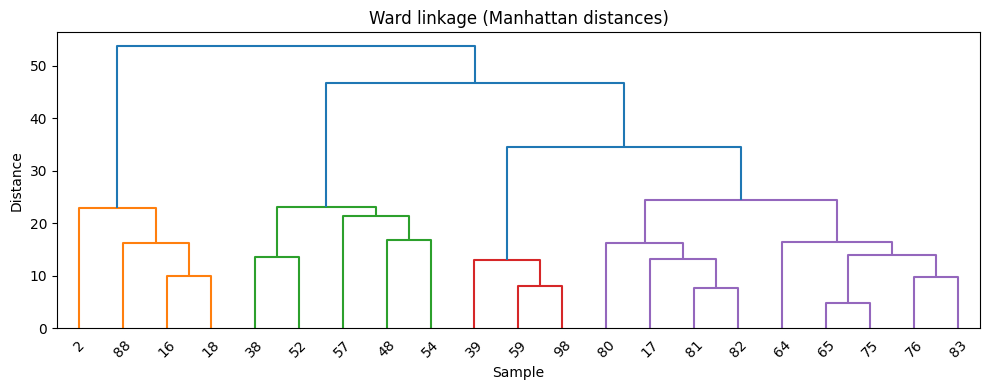

In [642]:
# select only the references in the data
reference_data = data[data[("SumRel", "site_label")] == "reference"]
# take out the octave-transformed taxa columns for clustering
octave_transformed_taxa_references = reference_data['octave_transformed_taxa'].copy()
# do the clustering
lingkage_matrix, cluster_labels = ward_manhattan_clustering(octave_transformed_taxa_references,
                          figure_kwargs={'figsize': (10, 4)},
                          dendro_kwargs={'color_threshold': 25}, n_clusters = 3)

In [643]:
# label the references with different cluster labels
octave_transformed_taxa_references["cluster_labels"] = cluster_labels
octave_transformed_taxa_references.head()

Oligochaeta      Nematoda  Chironomidae  Ceratopogonidae     Hexagenia  \
2      4.362321  1.922056e-15      4.466383     1.922056e-15  1.922056e-15   
16     3.849562  2.535334e+00      3.545988     1.601713e-15  1.601713e-15   
17     4.841972  2.957119e+00      4.782924     2.242399e-15  2.443826e+00   
18     3.200778  1.922056e-15      3.723955     1.922056e-15  1.922056e-15   
38     4.389285  4.075551e+00      4.536763     1.922056e-15  2.784080e+00   

          Caenis  Hydropsychidae  Other Trichoptera  Amphipoda     Dreissena  \
2   2.550633e+00    1.922056e-15       4.108302e+00   3.354661  3.079099e+00   
16  1.601713e-15    3.912302e+00       2.535334e+00   3.017012  4.024623e+00   
17  2.242399e-15    2.242399e-15       2.692380e+00   0.971265  3.090423e+00   
18  1.922056e-15    4.357646e+00       3.200778e+00   3.482138  3.854736e+00   
38  2.784080e+00    1.922056e-15       1.922056e-15   2.028093  1.922056e-15   

       Acari      Hydrozoa     Hirudinea   Turbellaria    Gastropoda  \
2   3.354661  3.079099e+00  1.922056e-15  1.922056e-15  1.922056e-15   
16  2.825357  3.157152e+00  1.601713e-15  1.601713e-15  3.594265e+00   
17  3.376813  1.488760e+00  2.242399e-15  9.712651e-01  1.832778e+00   
18  2.264230  4.218150e+00  1.922056e-15  1.922056e-15  2.970522e+00   
38  3.038548  1.922056e-15  2.028093e+00  2.370301e+00  3.771048e+00   

     Sphaeriidae  cluster_labels  
2   2.550633e+00               1  
16  2.535334e+00               1  
17  2.791776e+00               3  
18  1.922056e-15               1  
38  1.922056e-15               2

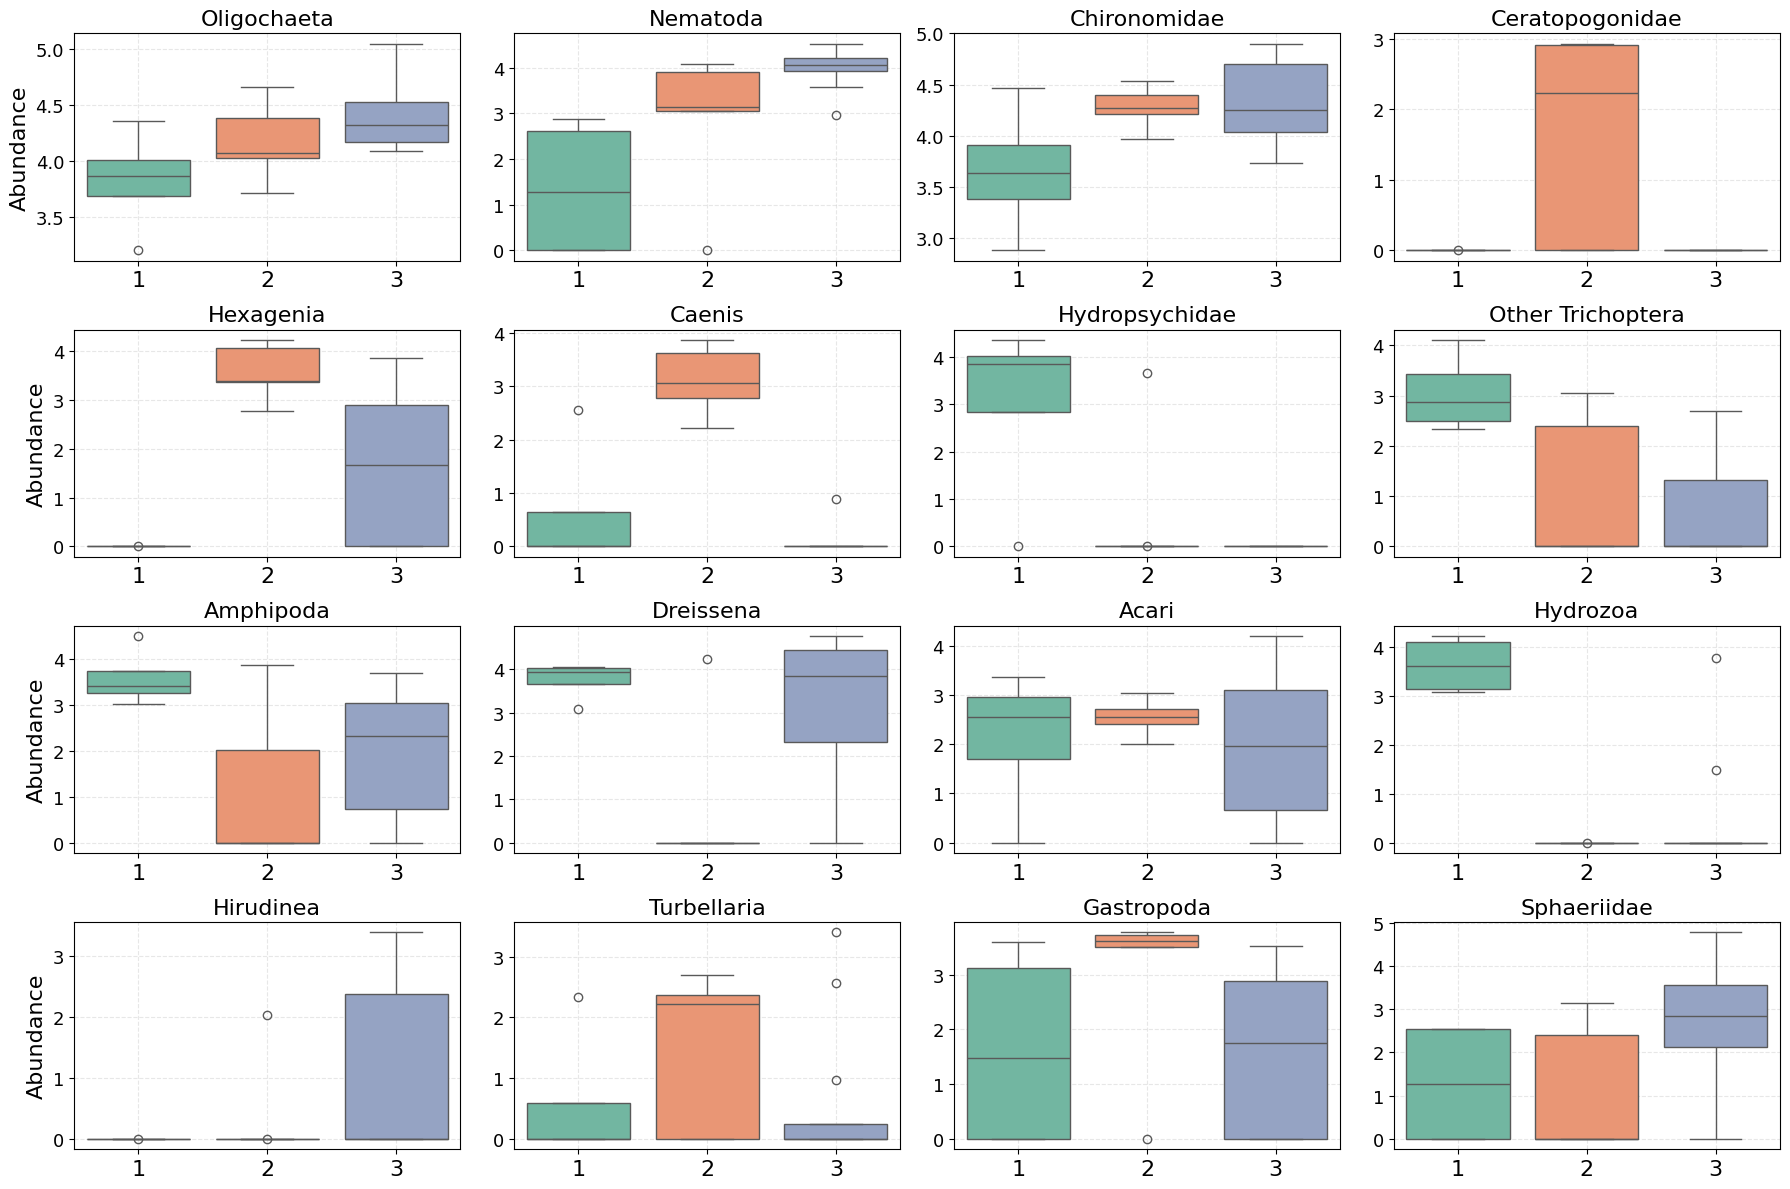

In [644]:
import seaborn as sns

import matplotlib.pyplot as plt

# Assume octave_transformed_taxa_references and cluster_labels are available from previous cells
# If not, replace with the appropriate DataFrame and cluster label array

# Add cluster labels to the main data frame for plotting
octave_transformed_taxa_references_plot = octave_transformed_taxa_references.copy()
octave_transformed_taxa_references_plot["cluster"] = cluster_labels

# Plot distribution of each taxa in each cluster using boxplots
fig, axes = plt.subplots(4, 4, figsize=(18, 12))
axes = axes.flatten()

for i, col in enumerate(taxa_cols):
    ax = axes[i]
    sns.boxplot(
        data=octave_transformed_taxa_references_plot,
        x="cluster",
        y=col,
        ax=ax,
        palette="Set2",
        hue = "cluster_labels"
    )
    ax.set_title(col, fontdict={'fontsize': 16})
    ax.set_xlabel("Cluster", fontsize=16)
    ax.set_ylabel("Abundance", fontsize=16)
    ax.grid(True, linestyle='--', alpha=0.3)
    ax.tick_params(axis='x', labelsize=16)
    ax.tick_params(axis='y', labelsize=13)
    if i % 4 != 0:
        ax.set_ylabel("")
    ax.set_xlabel("")
    ax.legend_.remove()

plt.tight_layout()
plt.savefig("../results/preliminary_results/taxa_abundance_by_cluster.png", dpi=300)
plt.show()

In the next stage: discriminant analysis will be applied to these reference sites to classify them into different taxa composition patterns, the cluster labels here, based on the environmental conditions of the sites.

Therefore, preparing the referece sites data with cluster labels is necessary, the labels will be used as response variable
in the discriminant analysis and the environmental conditions as predictor variables.

In [645]:
# set multiple column index levels for the cluster labels
octave_transformed_taxa_references.columns = pd.MultiIndex.from_product(
    [["log_transformed_taxa_clustered"], octave_transformed_taxa_references.columns]
    ) # make the multiindex for the clustered taxa data


# concatenate the cluster labels back to the original reference data
reference_data = pd.concat([reference_data, octave_transformed_taxa_references], axis=1)
reference_data.head()

ID              location                                           \
   StationID stress_level Location Latitude Longitude       geo_coordinates   
2         S4    -2.047317      SCR    42.92    -82.45  POINT (-82.45 42.92)   
16       S17    -2.972227      SCR    42.83    -82.48  POINT (-82.48 42.83)   
17       S18    -1.735681      SCR    42.82    -82.48  POINT (-82.48 42.82)   
18       S19    -1.959550      SCR    42.77    -82.47  POINT (-82.47 42.77)   
38       S46     1.309447      LSC    42.62    -82.67  POINT (-82.67 42.62)   

   chemical                       ... log_transformed_taxa_clustered  \
         Al     As     Bi     Ca  ...              Other Trichoptera   
2      2666  2.188  31.79  40140  ...                   4.108302e+00   
16     2378  2.437  29.73  35460  ...                   2.535334e+00   
17     2146  1.663  27.57  27700  ...                   2.692380e+00   
18     3255  1.980  26.07  28110  ...                   3.200778e+00   
38     6579  3.203  25.00  39960  ...                   1.922056e-15   

                                                                  \
   Amphipoda     Dreissena     Acari      Hydrozoa     Hirudinea   
2   3.354661  3.079099e+00  3.354661  3.079099e+00  1.922056e-15   
16  3.017012  4.024623e+00  2.825357  3.157152e+00  1.601713e-15   
17  0.971265  3.090423e+00  3.376813  1.488760e+00  2.242399e-15   
18  3.482138  3.854736e+00  2.264230  4.218150e+00  1.922056e-15   
38  2.028093  1.922056e-15  3.038548  1.922056e-15  2.028093e+00   

                                                             
     Turbellaria    Gastropoda   Sphaeriidae cluster_labels  
2   1.922056e-15  1.922056e-15  2.550633e+00              1  
16  1.601713e-15  3.594265e+00  2.535334e+00              1  
17  9.712651e-01  1.832778e+00  2.791776e+00              3  
18  1.922056e-15  2.970522e+00  1.922056e-15              1  
38  2.370301e+00  3.771048e+00  1.922056e-15              2  

[5 rows x 155 columns]

In [646]:
# save the reference data with cluster labels to local file
reference_data.to_excel('../data/processed_data/reference_data_with_cluster_labels.xlsx')

# Build discriminant model for habitat classification

The reference data added with cluster labels is ready for the discriminant analysis.

Fitting this discriminant model only on the reference sites makes it possible to infer what the pristine taxa composition patterns are, when there is no human impact on the sites. That is, **using the fitted discriminant model to predict the pristine taxa community cluster for other sites(not in reference data)** to classify them
into different taxa composition patterns, based on the environmental conditions of the sites.

Therefore, the process of building and applying the discriminant model is:
1) Fit the model on the reference data: to infer what the pristine taxa composition patterns are, without human impact
2) Apply the fitted model to predict the ideally pristine taxa community pattern for other sites (not in reference data) based on their environmental conditions

After the two steps, there should be much more observations within each cluster, and we will construct endpoints and compute ZCI within each of them via ordination analysis.

In [647]:
# read the reference data with cluster labels(pattern)
import pandas as pd
reference_data = pd.read_excel('../data/processed_data/reference_data_with_cluster_labels.xlsx', header=[0, 1], index_col=0)
reference_data.head()

ID              location                                           \
   StationID stress_level Location Latitude Longitude       geo_coordinates   
2         S4    -2.047317      SCR    42.92    -82.45  POINT (-82.45 42.92)   
16       S17    -2.972227      SCR    42.83    -82.48  POINT (-82.48 42.83)   
17       S18    -1.735681      SCR    42.82    -82.48  POINT (-82.48 42.82)   
18       S19    -1.959550      SCR    42.77    -82.47  POINT (-82.47 42.77)   
38       S46     1.309447      LSC    42.62    -82.67  POINT (-82.67 42.62)   

   chemical                       ... log_transformed_taxa_clustered  \
         Al     As     Bi     Ca  ...              Other Trichoptera   
2      2666  2.188  31.79  40140  ...                   4.108302e+00   
16     2378  2.437  29.73  35460  ...                   2.535334e+00   
17     2146  1.663  27.57  27700  ...                   2.692380e+00   
18     3255  1.980  26.07  28110  ...                   3.200778e+00   
38     6579  3.203  25.00  39960  ...                   1.922056e-15   

                                                                  \
   Amphipoda     Dreissena     Acari      Hydrozoa     Hirudinea   
2   3.354661  3.079099e+00  3.354661  3.079099e+00  1.922056e-15   
16  3.017012  4.024623e+00  2.825357  3.157152e+00  1.601713e-15   
17  0.971265  3.090423e+00  3.376813  1.488760e+00  2.242399e-15   
18  3.482138  3.854736e+00  2.264230  4.218150e+00  1.922056e-15   
38  2.028093  1.922056e-15  3.038548  1.922056e-15  2.028093e+00   

                                                             
     Turbellaria    Gastropoda   Sphaeriidae cluster_labels  
2   1.922056e-15  1.922056e-15  2.550633e+00              1  
16  1.601713e-15  3.594265e+00  2.535334e+00              1  
17  9.712651e-01  1.832778e+00  2.791776e+00              3  
18  1.922056e-15  2.970522e+00  1.922056e-15              1  
38  2.370301e+00  3.771048e+00  1.922056e-15              2  

[5 rows x 155 columns]

In [648]:
# prepare the discriminant analysis function
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

def run_discriminant_analysis(df, predictor_cols, response_col,
                              test_size=0.2, random_state=42):
    """
    Perform Linear Discriminant Analysis (LDA) on a DataFrame.

    Parameters
    ----------
    df : pandas.DataFrame
        DataFrame containing predictor variables and a discrete response.
    predictor_cols : list of str
        Column names to use as continuous predictors.
    response_col : str
        Column name of the discrete response variable.
    test_size : float, default 0.2
        Proportion of the dataset to include in the test split.
    random_state : int, default 42
        Random seed for reproducibility.

    Returns
    -------
    lda : LinearDiscriminantAnalysis
        The fitted LDA model.
    coefficients : pandas.DataFrame
        Discriminant coefficients for each predictor and class.
    intercepts : pandas.Series
        Intercepts for each class.
    report : str
        Classification report on the test set.
    cm : ndarray
        Confusion matrix on the test set.
    """
    # 1) Prepare X and y
    X = df[predictor_cols]
    y = df[response_col]
    
    # 2) Train/test split
    X_train, X_test, y_train, y_test = train_test_split(
        X, y,
        test_size=test_size,
        stratify=y,
        random_state=random_state
    )
    
    # 3) Fit LDA
    lda = LinearDiscriminantAnalysis()
    lda.fit(X_train, y_train)
    
    # 4) Predict & evaluate
    y_pred = lda.predict(X_test)
    report = classification_report(y_test, y_pred)
    cm = confusion_matrix(y_test, y_pred)
    
    # 5) Extract coefficients & intercepts
    coeffs = pd.DataFrame(
        lda.coef_.T,
        index=predictor_cols,
        columns=[f"Class_{cls}" for cls in lda.classes_]
    )
    intercepts = pd.Series(
        lda.intercept_,
        index=[f"Class_{cls}" for cls in lda.classes_]
    )
    
    return lda, coeffs, intercepts, report, cm

In [649]:
env_taxa_data = reference_data[['environmental', 'log_transformed_taxa_clustered']].copy()
# Flatten the MultiIndex columns for the discriminant analysis function
env_taxa_data.columns = env_taxa_data.columns.get_level_values(-1)
env_taxa_data.head()

Total Organic Carbon (LOI %)  Water Depth (m)  Water Temperature (¬∞C)  \
2                           1.46              4.6                    20.03   
16                          1.95              3.0                    19.33   
17                          1.50              4.0                    19.57   
18                          1.64              2.4                    20.56   
38                          3.47              0.9                    21.56   

    Dissolved Oxygen Concentration (mg/L)  Median Particle Size (Phi)  \
2                                    9.97                        1.10   
16                                  10.10                       -1.09   
17                                  10.40                        1.63   
18                                   9.78                       -1.32   
38                                  10.15                        2.33   

    Oligochaeta      Nematoda  Chironomidae  Ceratopogonidae     Hexagenia  \
2      4.362321  1.922056e-15      4.466383     1.922056e-15  1.922056e-15   
16     3.849562  2.535334e+00      3.545988     1.601713e-15  1.601713e-15   
17     4.841972  2.957119e+00      4.782924     2.242399e-15  2.443826e+00   
18     3.200778  1.922056e-15      3.723955     1.922056e-15  1.922056e-15   
38     4.389285  4.075551e+00      4.536763     1.922056e-15  2.784080e+00   

    ...  Other Trichoptera  Amphipoda     Dreissena     Acari      Hydrozoa  \
2   ...       4.108302e+00   3.354661  3.079099e+00  3.354661  3.079099e+00   
16  ...       2.535334e+00   3.017012  4.024623e+00  2.825357  3.157152e+00   
17  ...       2.692380e+00   0.971265  3.090423e+00  3.376813  1.488760e+00   
18  ...       3.200778e+00   3.482138  3.854736e+00  2.264230  4.218150e+00   
38  ...       1.922056e-15   2.028093  1.922056e-15  3.038548  1.922056e-15   

       Hirudinea   Turbellaria    Gastropoda   Sphaeriidae  cluster_labels  
2   1.922056e-15  1.922056e-15  1.922056e-15  2.550633e+00               1  
16  1.601713e-15  1.601713e-15  3.594265e+00  2.535334e+00               1  
17  2.242399e-15  9.712651e-01  1.832778e+00  2.791776e+00               3  
18  1.922056e-15  1.922056e-15  2.970522e+00  1.922056e-15               1  
38  2.028093e+00  2.370301e+00  3.771048e+00  1.922056e-15               2  

[5 rows x 22 columns]

In [650]:
# fit the discriminant analysis model
lda_model, coeffs, intercepts, report, cm = run_discriminant_analysis(
    env_taxa_data,
    predictor_cols=env_taxa_data.columns[:5],
    response_col="cluster_labels",
    test_size=5,
)

In [651]:
# transform the fitting results into Latex format tables and copy to clipboard
import pandas as pd
from io import StringIO
import numpy as np
import pyperclip

def copy_to_clipboard(text):
    try:
        pyperclip.copy(text)
        print("Copied to clipboard!")
    except Exception as e:
        print(f"Failed to copy: {e}")

# Format the outputs as LaTeX tables

# 1. Discriminant coefficients
latex_coeffs = coeffs.to_latex(float_format="%.3f", caption="Discriminant Coefficients", label="tab:lda_coeffs")

# 2. Intercepts
latex_intercepts = intercepts.to_frame("Intercept").to_latex(float_format="%.3f", caption="Intercepts", label="tab:lda_intercepts")

# 3. Classification report (convert string to table)

# Parse the classification report string into a DataFrame
report_df = pd.read_fwf(StringIO(report), index_col=0)
latex_report = report_df.to_latex(float_format="%.2f", caption="Classification Report", label="tab:lda_report")

# 4. Confusion matrix

# Get class labels from the classification report
class_labels = report_df.index[:-3]  # Exclude avg rows
cm_df = pd.DataFrame(cm, index=class_labels, columns=class_labels)
latex_cm = cm_df.to_latex(caption="Confusion Matrix", label="tab:lda_cm")
copy_to_clipboard(latex_coeffs + "\n\n" +
                  latex_intercepts + "\n\n" +
                  latex_report + "\n\n" +
                  latex_cm)

Copied to clipboard!


In [652]:
# Print all LaTeX tables
print(lda_model)
print(coeffs)
print(intercepts)
print(report)

LinearDiscriminantAnalysis()
                                        Class_1   Class_2   Class_3
Total Organic Carbon (LOI %)          -0.710564  3.679893 -1.398653
Water Depth (m)                        0.354164 -0.744854  0.212991
Water Temperature (¬∞C)               -1.509977  2.741586 -0.715157
Dissolved Oxygen Concentration (mg/L)  1.414431 -2.469669  0.626154
Median Particle Size (Phi)            -3.876467  0.262853  1.175332
Class_1    15.794033
Class_2   -44.531132
Class_3     8.074681
dtype: float64
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         1
           2       1.00      1.00      1.00         1
           3       1.00      1.00      1.00         3

    accuracy                           1.00         5
   macro avg       1.00      1.00      1.00         5
weighted avg       1.00      1.00      1.00         5



Now, we can use the fitted discriminant model **to predict the pristine taxa community cluster for other sites**(not in reference data) based on their environmental conditions.

In [653]:
data[("Predicted_Label", "taxa pattern")] = lda_model.predict(data['environmental'])
data.head()

ID              location                                           \
  StationID stress_level Location Latitude Longitude       geo_coordinates   
0        S1    -2.446806      SCR    43.01    -82.41  POINT (-82.41 43.01)   
1        S3     0.505028      SCR    42.95    -82.43  POINT (-82.43 42.95)   
2        S4    -2.047317      SCR    42.92    -82.45  POINT (-82.45 42.92)   
3        A5    -1.810714      SCR    42.88    -82.46  POINT (-82.46 42.88)   
4        S5     0.943809      SCR    42.87    -82.46  POINT (-82.46 42.87)   

  chemical                        ... octave_transformed_taxa  \
        Al     As      Bi     Ca  ...             Sphaeriidae   
0     1501  2.096  25.800  43640  ...            3.203427e-15   
1     4491  0.000   2.143  33160  ...            3.523769e-15   
2     2666  2.188  31.790  40140  ...            2.550633e+00   
3     2283  2.233  20.110  41360  ...            2.242399e-15   
4     6711  4.298  27.480  43960  ...            3.269402e+00   

                 environmental                                          \
  Total Organic Carbon (LOI %) Water Depth (m) Water Temperature (¬∞C)   
0                         0.41             4.6                   20.77   
1                         1.19             3.0                   20.33   
2                         1.46             4.6                   20.03   
3                         1.10             5.0                   19.78   
4                         2.76             1.5                   19.86   

                                                                    \
  Dissolved Oxygen Concentration (mg/L) Median Particle Size (Phi)   
0                                 10.03                       1.43   
1                                 10.26                       1.20   
2                                  9.97                       1.10   
3                                  9.03                      -1.30   
4                                  8.50                       1.68   

        SumRel                                         Predicted_Label  
  stress_level standardized_stress_level    site_label    taxa pattern  
0    -4.127157                  2.738680      degraded               3  
1    -1.440226                  3.093926  intermediate               3  
2     7.029481                  4.308701     reference               3  
3     0.627823                  3.281353  intermediate               1  
4    -0.339393                  3.171043  intermediate               2  

[5 rows x 139 columns]

In [654]:
# save the data with predicted taxa composition patterns locally
data.to_excel('../data/processed_data/multile_indexed_transformed_full_data_with_predicted_taxa_patterns.xlsx')

Now, all sites have been classified into their taxa composition patterns, in each of them, we will go in there and **extract the reference and degraded endpoints**.

# Construct endpoints for each taxa composition pattern

Within each taxa composition pattern, there are reference sites and degraded sites.

Take the mean of the best 3 or 5 sites in reference sites as the reference endpoint, and the mean of the worst 3 or 5 sites in degraded sites as the degraded endpoint.

The two endpoints secure the axis of stress level in each taxa composition pattern. 

The ideal situation is that the **closer one site is to the reference endpoint, the less disturbed it should be, and the closer one site is to the degraded endpoint, the more disturbed it should be.**

Notice, the two 'endpoints' does not mean the best or worst taxa composition patterns but means the less and most stress level within each taxa composition pattern. 
There might be no sites can have higher or less stress level than the endpoints, but they can have far different taxa composition away from these of the endpoints.

In [655]:
# read the data with predicted taxa composition patterns
import pandas as pd
data = pd.read_excel('../data/processed_data/multile_indexed_transformed_full_data_with_predicted_taxa_patterns.xlsx', header=[0, 1], index_col=0)

In [656]:
# the function to search the endpoints from reference and degraded sites in each class 
def get_reference_endpoints(df,
                            taxa_pattern_col='taxa_pattern',
                            site_label_col='site_label',
                            score_col='standardized_stress_level',
                            n=3):
    """
    For each taxa_pattern, among rows where site_label == 'reference',
    find the n lowest and n highest values of score_col, and compute
    the mean of those values to use as endpoints.

    Parameters
    ----------
    df : pandas.DataFrame
        Your full DataFrame.
    taxa_pattern_col : str
        Column name for taxa pattern grouping.
    site_label_col : str
        Column name containing 'reference' / 'intermediate' / 'degraded'.
    score_col : str
        Numeric column to rank (e.g. standardized stress level).
    n : int, default 3
        Number of lowest/highest values to select per group.

    Returns
    -------
    low_df : pandas.DataFrame
        The n lowest rows per taxa_pattern (reference sites only).
    high_df : pandas.DataFrame
        The n highest rows per taxa_pattern (reference sites only).
    endpoints : pandas.DataFrame
        For each taxa_pattern, the mean of the lowest n and highest n scores,
        with columns ['low_mean', 'high_mean'].
    """
    # 1) filter to reference sites
    ref = df[df[site_label_col] == 'reference']
    deg = df[df[site_label_col] == 'degraded']
    
    # 2) select n smallest and n largest per taxa pattern
    # n smallest per group
    low_df = (ref
            .sort_values(score_col)               # ascending
            .groupby(taxa_pattern_col, group_keys=False)
            .head(n))

    # n largest per group
    high_df = (deg
            .sort_values(score_col, ascending=False)
            .groupby(taxa_pattern_col, group_keys=False)
            .head(n))
    
    # 3) aggregate to get endpoint means
    endpoints = pd.DataFrame({
        'low_mean(references)': low_df.groupby(taxa_pattern_col)[score_col].mean(),
        'high_mean(degraded)': high_df.groupby(taxa_pattern_col)[score_col].mean(),
    })
    
    return low_df, high_df, endpoints

In [657]:
# prapare the subset of stress level and taxa composition for the function
endpoint_searching_data = data[["SumRel", "Predicted_Label"]].copy()
endpoint_searching_data.columns = endpoint_searching_data.columns.get_level_values(-1)  # flatten MultiIndex

# search the observations for constructing endpoints
low_scores_df, high_scores_df, endpoints = get_reference_endpoints(endpoint_searching_data, 
                        taxa_pattern_col = "taxa pattern",
                        site_label_col = "site_label",
                        score_col = "standardized_stress_level",
                        n = 3)

In [658]:
# check the endpoints for each taxa pattern
endpoints

low_mean(references)  high_mean(degraded)
taxa pattern                                           
1                         4.254815             2.745355
2                         3.746278             2.697528
3                         3.657598             2.902365

In [659]:
# label the cluster patterns with their endpoints
merged_predicted_labels = pd.merge(data["Predicted_Label"], endpoints, left_on="taxa pattern", right_index=True, how="left")
# drop the 'taxa pattern' column from the merged DataFrame, which will be added back from the original data
merged_predicted_labels = merged_predicted_labels.drop(columns=["taxa pattern"])

# set the multiindex for the subset and re-concatenate it back to the original data
merged_predicted_labels.columns = pd.MultiIndex.from_product([["Predicted_Label"], merged_predicted_labels.columns])
data = pd.concat([data, merged_predicted_labels], axis=1)
data.head()

ID              location                                           \
  StationID stress_level Location Latitude Longitude       geo_coordinates   
0        S1    -2.446806      SCR    43.01    -82.41  POINT (-82.41 43.01)   
1        S3     0.505028      SCR    42.95    -82.43  POINT (-82.43 42.95)   
2        S4    -2.047317      SCR    42.92    -82.45  POINT (-82.45 42.92)   
3        A5    -1.810714      SCR    42.88    -82.46  POINT (-82.46 42.88)   
4        S5     0.943809      SCR    42.87    -82.46  POINT (-82.46 42.87)   

  chemical                        ...   environmental                          \
        Al     As      Bi     Ca  ... Water Depth (m) Water Temperature (¬∞C)   
0     1501  2.096  25.800  43640  ...             4.6                   20.77   
1     4491  0.000   2.143  33160  ...             3.0                   20.33   
2     2666  2.188  31.790  40140  ...             4.6                   20.03   
3     2283  2.233  20.110  41360  ...             5.0                   19.78   
4     6711  4.298  27.480  43960  ...             1.5                   19.86   

                                                                    \
  Dissolved Oxygen Concentration (mg/L) Median Particle Size (Phi)   
0                                 10.03                       1.43   
1                                 10.26                       1.20   
2                                  9.97                       1.10   
3                                  9.03                      -1.30   
4                                  8.50                       1.68   

        SumRel                                         Predicted_Label  \
  stress_level standardized_stress_level    site_label    taxa pattern   
0    -4.127157                  2.738680      degraded               3   
1    -1.440226                  3.093926  intermediate               3   
2     7.029481                  4.308701     reference               3   
3     0.627823                  3.281353  intermediate               1   
4    -0.339393                  3.171043  intermediate               2   

                                            
  low_mean(references) high_mean(degraded)  
0             3.657598            2.902365  
1             3.657598            2.902365  
2             3.657598            2.902365  
3             4.254815            2.745355  
4             3.746278            2.697528  

[5 rows x 141 columns]

### Construct the theoretical best and worst sites for each taxa composition pattern

In [660]:
# find the sites that are in the worst taxa patterns and extract the needed columns: transformed taxa, stress level and taxa pattern
maximum_impacted_sites = data.iloc[high_scores_df.index, :].copy()[["octave_transformed_taxa", "SumRel", "Predicted_Label"]]
minimal_impacted_sites = data.iloc[low_scores_df.index, :].copy()[["octave_transformed_taxa", "SumRel", "Predicted_Label"]]

# flatten the multiindex columns and drop unnecessary columns for the two maximum and minimum impacted groups of sites
minimal_impacted_sites.columns = minimal_impacted_sites.columns.get_level_values(-1)
minimal_impacted_sites.drop(columns=["site_label", "low_mean(references)", "high_mean(degraded)"], inplace=True)
maximum_impacted_sites.columns = maximum_impacted_sites.columns.get_level_values(-1)
maximum_impacted_sites.drop(columns=["site_label", "low_mean(references)", "high_mean(degraded)"], inplace=True)

# group by the taxa pattern and calculate the mean of the transformed taxa
best_taxa_compositions = minimal_impacted_sites.groupby("taxa pattern").mean()
worst_taxa_compositions = maximum_impacted_sites.groupby("taxa pattern").mean()
worst_taxa_compositions.head()

Oligochaeta  Nematoda  Chironomidae  Ceratopogonidae  \
taxa pattern                                                         
1                5.513109  4.659158      4.871402     3.523769e-15   
2                4.883727  4.417671      4.286057     3.523769e-15   
3                5.168886  4.524350      4.826978     2.883084e-15   

                 Hexagenia        Caenis  Hydropsychidae  Other Trichoptera  \
taxa pattern                                                                  
1             3.523769e-15  3.523769e-15    3.523769e-15       3.523769e-15   
2             3.523769e-15  1.471967e+00    3.523769e-15       6.681187e-01   
3             2.883084e-15  2.883084e-15    2.883084e-15       2.883084e-15   

                 Amphipoda     Dreissena         Acari      Hydrozoa  \
taxa pattern                                                           
1             3.523769e-15  3.523769e-15  3.523769e-15  3.523769e-15   
2             3.523769e-15  4.730065e-01  3.523769e-15  3.523769e-15   
3             2.883084e-15  2.883084e-15  2.883084e-15  2.883084e-15   

                 Hirudinea   Turbellaria    Gastropoda   Sphaeriidae  \
taxa pattern                                                           
1             3.523769e-15  3.523769e-15  3.523769e-15  3.523769e-15   
2             1.268938e+00  3.523769e-15  1.385567e+00  3.523769e-15   
3             2.883084e-15  8.619894e-01  1.306557e+00  2.833005e+00   

              stress_level  standardized_stress_level  
taxa pattern                                           
1                -4.219897                   2.745355  
2                -3.659740                   2.697528  
3                -2.900618                   2.902365

# Use Compute Bray–Curtis ordination to compute the ZCI

In [661]:
# 1) Build taxa matrix (sites × taxa) in octave scale
M = data[["octave_transformed_taxa", "Predicted_Label"]].copy()
# Flatten MultiIndex columns
M.columns = M.columns.get_level_values(-1)
# take out the subses of different taxa patterns
M_pattern1 = M[M["taxa pattern"] == 1].drop(columns=["taxa pattern", "low_mean(references)", "high_mean(degraded)"])
M_pattern2 = M[M["taxa pattern"] == 2].drop(columns=["taxa pattern", "low_mean(references)", "high_mean(degraded)"])
M_pattern3 = M[M["taxa pattern"] == 3].drop(columns=["taxa pattern", "low_mean(references)", "high_mean(degraded)"])

# add the taxa compositions under best and worst stress coditions of each taxa pattern to the subsets
M_pattern1.loc["Best"] = best_taxa_compositions.loc[1]
M_pattern1.loc["Worst"] = worst_taxa_compositions.loc[1]
M_pattern2.loc["Best"] = best_taxa_compositions.loc[2]
M_pattern2.loc["Worst"] = worst_taxa_compositions.loc[2]
M_pattern3.loc["Best"] = best_taxa_compositions.loc[3]
M_pattern3.loc["Worst"] = worst_taxa_compositions.loc[3]

Within each pattern, calculate the ZCI based on the Bray-Curtis ordination of the taxa composition data, using the best and worst endpoints as the two extremes of the ZCI axis.

In [662]:
# define the function to compute the ZCI (Z-scores of Condition Index) via Bray-Curties ordination for each taxa pattern
from scipy.spatial.distance import pdist, squareform
from sklearn.manifold import MDS
import pandas as pd

# Repeat ordination for each taxa pattern subset (M_pattern1, M_pattern2, M_pattern3)
def compute_zci(M_pattern):
    # Compute Bray–Curtis distance matrix
    D = pdist(M_pattern.values, metric='braycurtis')
    D_sq = squareform(D)
    # Classical (metric) MDS in 1D
    mds = MDS(n_components=1, dissimilarity='precomputed', random_state=0)
    coords_1d = mds.fit_transform(D_sq).flatten()
    ord_scores = pd.Series(coords_1d, index=M_pattern.index)
    # Extract scores
    s = ord_scores.loc[M_pattern.index]
    s_b = ord_scores.loc['Best']
    s_w = ord_scores.loc['Worst']
    ZCI = (s - s_w) / (s_b - s_w)
    return ZCI, ord_scores

# Compute ZCI for each taxa pattern
ZCI1, ord_scores1 = compute_zci(M_pattern1)
ZCI2, ord_scores2 = compute_zci(M_pattern2)
ZCI3, ord_scores3 = compute_zci(M_pattern3)

# Optionally, display or store the results
print("ZCI for pattern 1:")
print(ZCI1)
print("\nZCI for pattern 2:")
print(ZCI2)
print("\nZCI for pattern 3:")
print(ZCI3)

ZCI for pattern 1:
3        0.691977
11       0.796090
12       0.851699
16       0.817421
18       1.135527
73      -0.010720
86       0.093231
88       0.620697
91       1.118404
93       0.325165
94       0.836701
96       0.516605
100      0.008888
103     -0.246131
Best     1.000000
Worst    0.000000
dtype: float64

ZCI for pattern 2:
4        0.223587
5        0.256910
27      -0.095761
34       1.443408
38       1.101377
44       1.242426
46       0.155021
48       1.066624
49       0.486343
50       0.564144
51       1.411186
52       1.619109
53       0.029318
54       1.264255
55       1.225518
56       0.499651
57      -0.786615
58       0.665612
61      -0.307954
79       1.835182
89      -0.064608
95       0.348952
99      -0.404105
Best     1.000000
Worst   -0.000000
dtype: float64

ZCI for pattern 3:
0       -0.964801
1        2.263257
2        3.771715
6        1.811712
7        3.176602
           ...   
98      -0.182413
101     -0.374874
102      4.635950
Best     1.

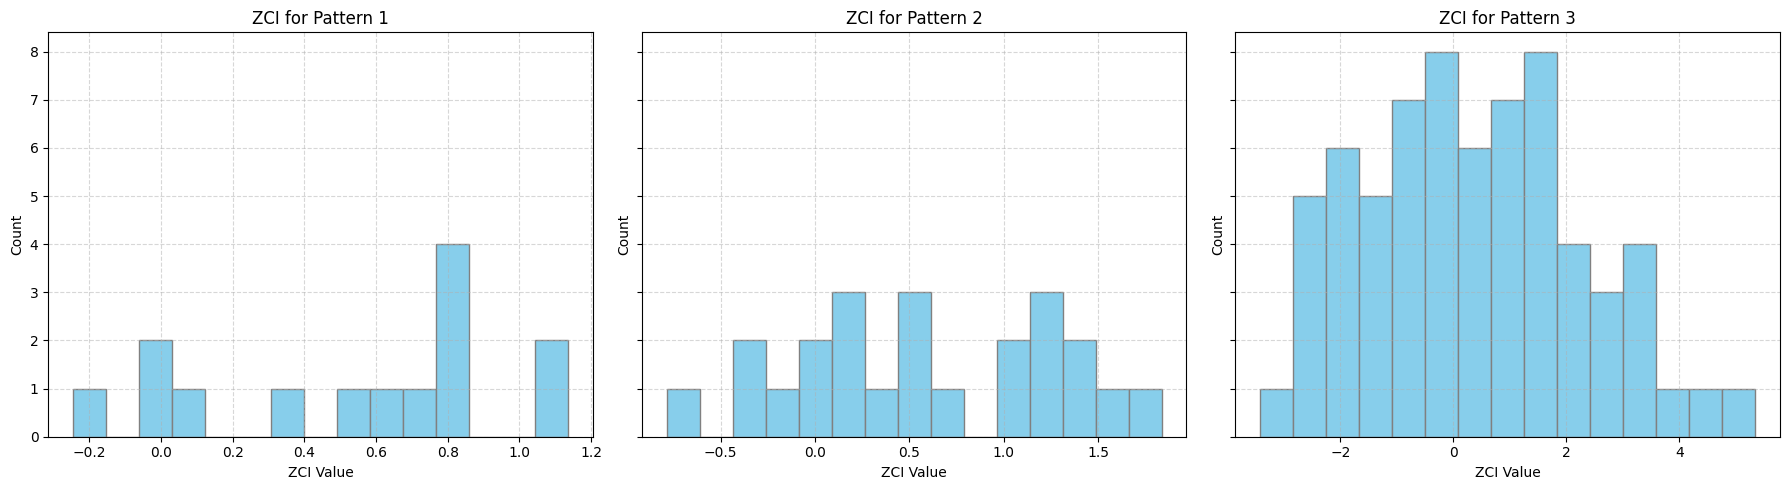

In [663]:
# visualize the ZCI results using histograms
import matplotlib.pyplot as plt

# Plot histograms for ZCI1, ZCI2, ZCI3
fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

zci_list = [ZCI1, ZCI2, ZCI3]
titles = ['ZCI for Pattern 1', 'ZCI for Pattern 2', 'ZCI for Pattern 3']

for i, (zci, title) in enumerate(zip(zci_list, titles)):
    # Exclude 'Best' and 'Worst' endpoints from the histogram
    zci_plot = zci.drop(['Best', 'Worst'], errors='ignore')
    axes[i].hist(zci_plot, bins=15, color='skyblue', edgecolor='gray')
    axes[i].set_title(title)
    axes[i].set_xlabel('ZCI Value')
    axes[i].set_ylabel('Count')
    axes[i].grid(True, linestyle='--', alpha=0.5)

plt.tight_layout()
plt.show()

Now, put these ZCI score back to the original data frame, which has the stress level scores. 

This merging will give a full data frame with ZCI and stress level scores, which are the predictor and response variables for the quantile regression analysis.

In [664]:
# first, stack the ZCI results vertically to create a single series
ZCIs = pd.concat([ZCI1, ZCI2, ZCI3], axis=0)
# temporarily remove the three pairs of 'Best' and 'Worst' from the ZCI series
ZCIs = ZCIs[~ZCIs.index.isin(['Best', 'Worst'])]
# merge the ZCI scores to a flattened subset of the data first
predicted_label_subset = data[["Predicted_Label"]].copy()
predicted_label_subset.columns = predicted_label_subset.columns.get_level_values(-1)  # flatten
predicted_label_subset = predicted_label_subset.loc[ZCIs.index]  # align indices
# insert the ZCI scores into the predicted label subset
predicted_label_subset['ZCI'] = ZCIs.values
# remove the duplicate columns 
predicted_label_subset = predicted_label_subset.loc[:,["ZCI"]]
# resort the index to match the original data
predicted_label_subset = predicted_label_subset.reindex(data.index)
predicted_label_subset
# set the multiindex for the predicted label subset
predicted_label_subset.columns = pd.MultiIndex.from_product([["Predicted_Label"], predicted_label_subset.columns])
# concatenate the predicted label subset with the original data
data = pd.concat([data, predicted_label_subset], axis=1)

In [665]:
# finally, add the best and worst endpoints back to the ZCI series
best_taxa_compositions["ZCI"] = 1.0
worst_taxa_compositions["ZCI"] = 0
best_taxa_compositions["taxa pattern"] = best_taxa_compositions.index
worst_taxa_compositions["taxa pattern"] = worst_taxa_compositions.index

In [666]:
data.head()

ID              location                                           \
  StationID stress_level Location Latitude Longitude       geo_coordinates   
0        S1    -2.446806      SCR    43.01    -82.41  POINT (-82.41 43.01)   
1        S3     0.505028      SCR    42.95    -82.43  POINT (-82.43 42.95)   
2        S4    -2.047317      SCR    42.92    -82.45  POINT (-82.45 42.92)   
3        A5    -1.810714      SCR    42.88    -82.46  POINT (-82.46 42.88)   
4        S5     0.943809      SCR    42.87    -82.46  POINT (-82.46 42.87)   

  chemical                        ...           environmental  \
        Al     As      Bi     Ca  ... Water Temperature (¬∞C)   
0     1501  2.096  25.800  43640  ...                   20.77   
1     4491  0.000   2.143  33160  ...                   20.33   
2     2666  2.188  31.790  40140  ...                   20.03   
3     2283  2.233  20.110  41360  ...                   19.78   
4     6711  4.298  27.480  43960  ...                   19.86   

                                                                    \
  Dissolved Oxygen Concentration (mg/L) Median Particle Size (Phi)   
0                                 10.03                       1.43   
1                                 10.26                       1.20   
2                                  9.97                       1.10   
3                                  9.03                      -1.30   
4                                  8.50                       1.68   

        SumRel                                         Predicted_Label  \
  stress_level standardized_stress_level    site_label    taxa pattern   
0    -4.127157                  2.738680      degraded               3   
1    -1.440226                  3.093926  intermediate               3   
2     7.029481                  4.308701     reference               3   
3     0.627823                  3.281353  intermediate               1   
4    -0.339393                  3.171043  intermediate               2   

                                                      
  low_mean(references) high_mean(degraded)       ZCI  
0             3.657598            2.902365 -0.964801  
1             3.657598            2.902365  2.263257  
2             3.657598            2.902365  3.771715  
3             4.254815            2.745355  0.691977  
4             3.746278            2.697528  0.223587  

[5 rows x 142 columns]

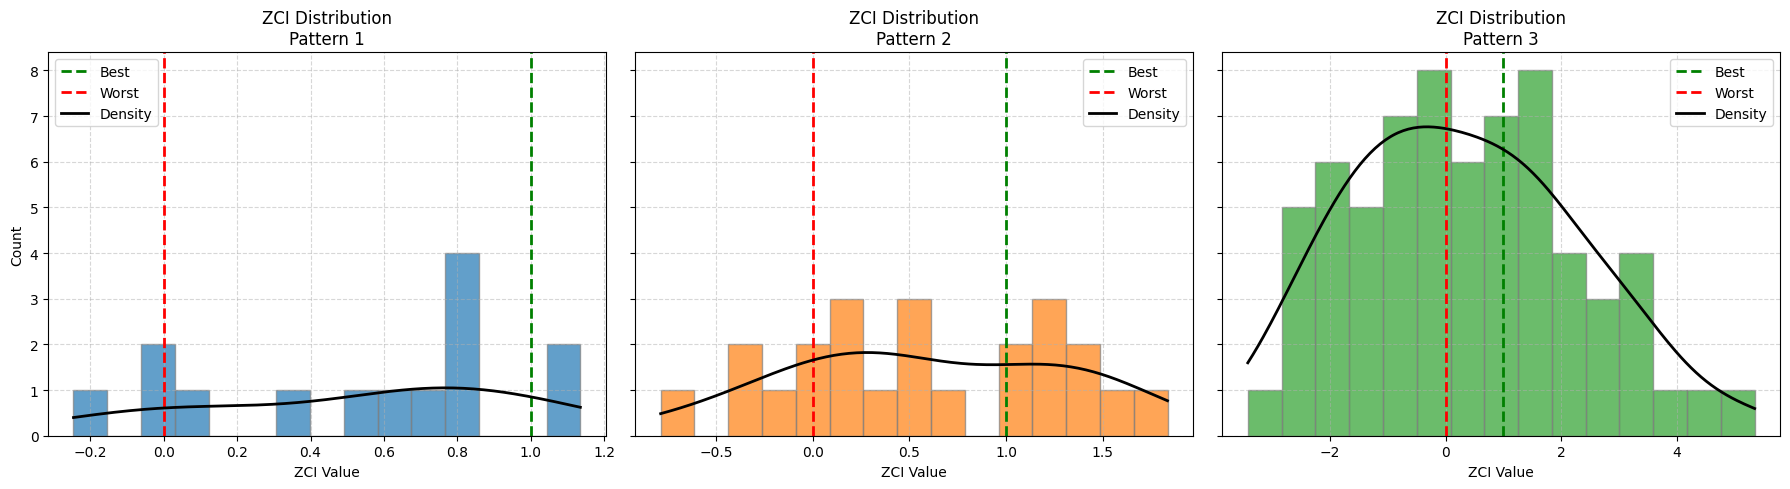

In [667]:
import numpy as np
from scipy.stats import gaussian_kde

import matplotlib.pyplot as plt

# Prepare ZCI data for each pattern, including endpoints
zci_patterns = [ZCI1, ZCI2, ZCI3]
titles = ['Pattern 1', 'Pattern 2', 'Pattern 3']
colors = ['tab:blue', 'tab:orange', 'tab:green']

fig, axes = plt.subplots(1, 3, figsize=(18, 5), sharey=True)

for i, (zci, title, color) in enumerate(zip(zci_patterns, titles, colors)):
    # Exclude 'Best' and 'Worst' for histogram, but keep for annotation
    zci_plot = zci.drop(['Best', 'Worst'], errors='ignore')
    axes[i].hist(zci_plot, bins=15, color=color, edgecolor='gray', alpha=0.7)
    axes[i].set_title(f"ZCI Distribution\n{title}")
    axes[i].set_xlabel('ZCI Value')
    if i == 0:
        axes[i].set_ylabel('Count')
    axes[i].grid(True, linestyle='--', alpha=0.5)
    # Annotate Best and Worst
    axes[i].axvline(zci['Best'], color='green', linestyle='--', linewidth=2, label='Best')
    axes[i].axvline(zci['Worst'], color='red', linestyle='--', linewidth=2, label='Worst')
    axes[i].legend()
    
    # Density estimation
    zci_vals = zci_plot.values
    if len(zci_vals) > 1 and np.std(zci_vals) > 0:
        kde = gaussian_kde(zci_vals)
        x_grid = np.linspace(zci_vals.min(), zci_vals.max(), 200)
        axes[i].plot(x_grid, kde(x_grid) * len(zci_vals) * (zci_vals.max() - zci_vals.min()) / 15, color='black', lw=2, label='Density')
        axes[i].legend()

plt.tight_layout()
plt.show()

In [668]:
# Combine best_taxa_compositions and worst_taxa_compositions into one longer DataFrame
combined_endpoints = pd.concat([best_taxa_compositions, worst_taxa_compositions], keys=['Best', 'Worst'])
combined_endpoints.index.names = ['Endpoint', 'taxa pattern']
combined_endpoints = combined_endpoints.T
# Convert to LaTeX format
latex_table = combined_endpoints.to_latex(float_format="%.3f", caption="Best and Worst Taxa Compositions by Pattern", label="tab:endpoints")
print(latex_table)

\begin{table}
\caption{Best and Worst Taxa Compositions by Pattern}
\label{tab:endpoints}
\begin{tabular}{lrrrrrr}
\toprule
Endpoint & \multicolumn{3}{r}{Best} & \multicolumn{3}{r}{Worst} \\
taxa pattern & 1 & 2 & 3 & 1 & 2 & 3 \\
\midrule
Oligochaeta & 3.645 & 4.376 & 4.448 & 5.513 & 4.884 & 5.169 \\
Nematoda & 1.807 & 2.664 & 4.224 & 4.659 & 4.418 & 4.524 \\
Chironomidae & 3.385 & 4.382 & 4.244 & 4.871 & 4.286 & 4.827 \\
Ceratopogonidae & 0.000 & 1.723 & 0.000 & 0.000 & 0.000 & 0.000 \\
Hexagenia & 0.000 & 3.411 & 0.850 & 0.000 & 0.000 & 0.000 \\
Caenis & 0.000 & 3.423 & 0.000 & 0.000 & 1.472 & 0.000 \\
Hydropsychidae & 4.013 & 1.217 & 0.000 & 0.000 & 0.000 & 0.000 \\
Other Trichoptera & 2.691 & 0.802 & 0.965 & 0.000 & 0.668 & 0.000 \\
Amphipoda & 3.666 & 0.676 & 2.363 & 0.000 & 0.000 & 0.000 \\
Dreissena & 3.976 & 0.000 & 3.034 & 0.000 & 0.473 & 0.000 \\
Acari & 1.697 & 2.716 & 1.000 & 0.000 & 0.000 & 0.000 \\
Hydrozoa & 3.808 & 0.000 & 0.000 & 0.000 & 0.000 & 0.000 \\
Hirudinea & 0

Now, we have a fully completed data frame that has the following columns:

stress level, cluster labels, and ZCI scores for each taxa composition pattern.

The stress level is a general measure of human impact, not specific to any taxa composition pattern.

The cluster labels and ZCI scores are specific to each taxa composition pattern, which split the completed data frame into 3 subsets,

the quantile regression analysis will be applied to each of them separately.

Finally, the best and worst endpoints can be added back to the ZCI ~ stress level relationship to show the "theoretical ideal" situation of the ZCI and stress level relationship.

# Quantile regression analysis between ZCI and stress level

/var/folders/s5/r1s56_ps46lbbv1370hjn_vr0000gn/T/ipykernel_1507/3026489336.py:49: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax_box.set_xticklabels(ax_box.get_xticklabels(), rotation=45, ha='right')


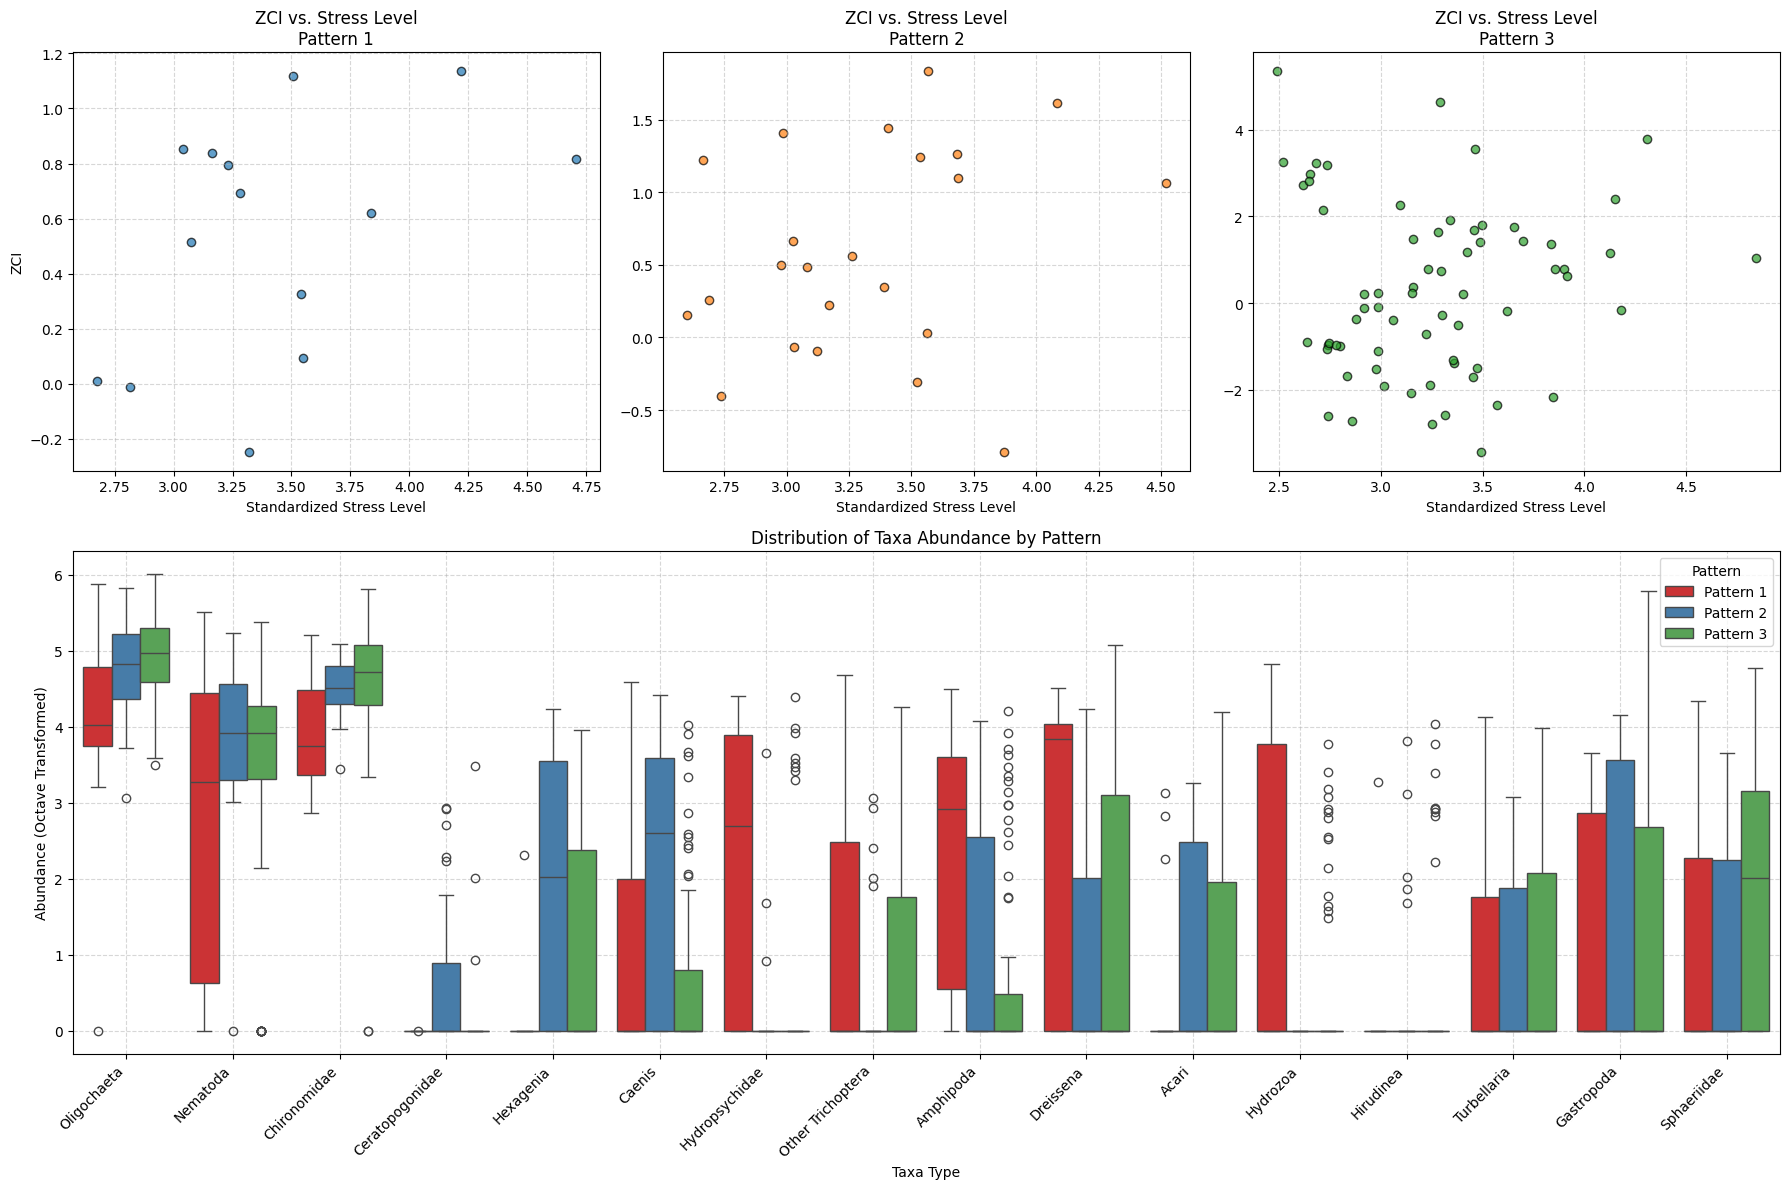

In [669]:

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Prepare data for ZCI vs. Stress Level scatter plots
patterns = [1, 2, 3]
pattern_names = ['Pattern 1', 'Pattern 2', 'Pattern 3']
colors = ['tab:blue', 'tab:orange', 'tab:green']

# Prepare data for taxa abundance boxplots
plot_df = []
for pattern, pattern_name in zip(patterns, pattern_names):
    mask = (data[("Predicted_Label", "taxa pattern")] == pattern)
    taxa_data = data.loc[mask, "octave_transformed_taxa"]
    melted = taxa_data[taxa_cols].melt(var_name="Taxa", value_name="Abundance")
    melted["Pattern"] = pattern_name
    plot_df.append(melted)
plot_df = pd.concat(plot_df, ignore_index=True)

# Create a bigger figure with two rows: first row for scatter plots, second row for boxplot
fig = plt.figure(figsize=(18, 12))
gs = fig.add_gridspec(2, 3, height_ratios=[1, 1.2])

# First row: ZCI vs. Stress Level scatter plots
for i, pattern in enumerate(patterns):
    ax = fig.add_subplot(gs[0, i])
    mask = (data[("Predicted_Label", "taxa pattern")] == pattern)
    y = data.loc[mask, ("SumRel", "standardized_stress_level")]
    x = data.loc[mask, ("Predicted_Label", "ZCI")]
    ax.scatter(y, x, color=colors[i], alpha=0.7, edgecolor='k')
    ax.set_title(f'ZCI vs. Stress Level\n{pattern_names[i]}')
    ax.set_xlabel('Standardized Stress Level')
    if i == 0:
        ax.set_ylabel('ZCI')
    else:
        ax.set_ylabel('')
    ax.grid(True, linestyle='--', alpha=0.5)

# Second row: taxa abundance boxplot (spans all columns)
ax_box = fig.add_subplot(gs[1, :])
sns.boxplot(
    data=plot_df,
    x="Taxa",
    y="Abundance",
    hue="Pattern",
    palette="Set1",
    ax=ax_box
)
ax_box.set_xticklabels(ax_box.get_xticklabels(), rotation=45, ha='right')
ax_box.set_xlabel("Taxa Type")
ax_box.set_ylabel("Abundance (Octave Transformed)")
ax_box.set_title("Distribution of Taxa Abundance by Pattern")
ax_box.grid(True, linestyle='--', alpha=0.5)
ax_box.legend(title="Pattern", loc='upper right')

plt.tight_layout()
plt.savefig("../results/preliminary_results/zci_vs_stress_and_taxa_abundance.png", dpi=300)
plt.show()

## Use the customized quantile regression function to fit the model

In [670]:
# take the predictor and response columns for the ZCI vs. stress level analysis
ZCI_stress_pattern1 = data.loc[data[("Predicted_Label", "taxa pattern")] == 1, 
                               [("Predicted_Label", "ZCI"), 
                                ("SumRel", "standardized_stress_level"),
                                (("Predicted_Label", "taxa pattern"))]]
ZCI_stress_pattern2 = data.loc[data[("Predicted_Label", "taxa pattern")] == 2, 
                               [("Predicted_Label", "ZCI"), 
                                ("SumRel", "standardized_stress_level"),
                                (("Predicted_Label", "taxa pattern"))]]
ZCI_stress_pattern3 = data.loc[data[("Predicted_Label", "taxa pattern")] == 3, 
                               [("Predicted_Label", "ZCI"),
                                ("SumRel", "standardized_stress_level"),
                                (("Predicted_Label", "taxa pattern"))]]

# flatten the multiindex columns for the three patterns
ZCI_stress_pattern1.columns = ZCI_stress_pattern1.columns.get_level_values(-1)
ZCI_stress_pattern2.columns = ZCI_stress_pattern2.columns.get_level_values(-1)
ZCI_stress_pattern3.columns = ZCI_stress_pattern3.columns.get_level_values(-1)

ZCI_stress_pattern1

ZCI  standardized_stress_level  taxa pattern
3    0.691977                   3.281353             1
11   0.796090                   3.229007             1
12   0.851699                   3.041699             1
16   0.817421                   4.706489             1
18   1.135527                   4.220294             1
73  -0.010720                   2.816621             1
86   0.093231                   3.547090             1
88   0.620697                   3.837662             1
91   1.118404                   3.506755             1
93   0.325165                   3.538780             1
94   0.836701                   3.162657             1
96   0.516605                   3.075667             1
100  0.008888                   2.674089             1
103 -0.246131                   3.320867             1

In [671]:
import matplotlib.pyplot as plt

def plot_pqrm_bootstrap_results(
    data,                       # original DataFrame
    x, y,                       # column names for x and response
    base_model,                 # the first fitted PQRM model
    bootstrap_predictions_df,   # DataFrame from generate_empirical_parameters
    pred_ci,                    # (lower, upper) Series from generate_empirical_parameters
    alpha_ci,                   # (lower, upper) Series for alphas
    bootstrap_alphas_ci,        # list of (l,u) pairs – unused here but returned
    figsize=(10, 5), 
    scatter_kws=dict(s=20, alpha=.5),
    ribbon_kws=dict(color='tab:blue', alpha=.2),
    line_kws=dict(color='tab:blue', lw=1.2, alpha=.6),
    base_model_kws=dict(color='k', lw=1.8, label='Original PQRM',),
    gamma = None,
    tau = None,
    fig=None,
    axes=None
    ):
    """
    Visualise PQRM bootstrap results.
    ---------------------------------
    Parameters
    ----------
    data : DataFrame
    Original dataset (must contain columns `x` and `y`).
    x, y : str
    Names of the predictor and response columns.
    base_model : fitted PQRM object
    Should expose .predict(df) to return fitted values.
    bootstrap_predictions_df : DataFrame
    Columns = bootstrap replicates, index aligned with data.index.
    pred_ci : tuple (lower Series, upper Series)
    alpha_ci : tuple (lower Series, upper Series)
    bootstrap_alphas_ci : list of tuples – not plotted but kept if needed.
    fig, axes : matplotlib Figure and Axes (optional)
    If provided, plot into these instead of creating new ones.
    """
    lower_pred, upper_pred = pred_ci
    lower_alpha, upper_alpha = alpha_ci

    # median prediction across bootstraps
    median_pred = bootstrap_predictions_df.median(axis=1)

    # --- PLOT ------------------------------------------
    if fig is None and axes is None:
        fig, axes = plt.subplots(1, 2, figsize=figsize, gridspec_kw=dict(width_ratios=[3,1]))
    # set the two axes
    if axes is None:
        fig, axes = plt.subplots(1, 1, figsize=figsize)
    
    ax = axes

    # 1 • scatter raw data
    ax.scatter(data[x], data[y], label='Data', **scatter_kws)

    # 2 • original PQRM fit
    ax.plot(data[x].sort_values(), base_model.predict(data.sort_values(x)), **base_model_kws)

    # 3 • bootstrap median + ribbon
    order = np.argsort(data[x].values)
    ax.fill_between(
    data[x].values[order],
    lower_pred.values[order],
    upper_pred.values[order],
    **ribbon_kws,
    label=f"{int(ribbon_kws.get('alpha',0.2)*100*2+60)}% CI"
    )
    ax.plot(
    data[x].values[order],
    median_pred.values[order],
    **line_kws,
    label='Bootstrap median'
    )

    ax.set_xlabel(x)
    ax.set_ylabel(y)
    ax.set_title(f'PQRM($\\tau = {tau :.2f}$) fit with bootstrap CI ({gamma :.2f})')
    ax.legend()
    
    plt.tight_layout()
    if fig is None or axes is None:
        plt.show()
    return fig, axes

In [672]:

# set the hyperparameters for the PQRM model
from PyModules import PQRM

tau = 0.5
initial_guess = 3.5
bounds = [(3, 4)]
gamma = 0.8

/var/folders/s5/r1s56_ps46lbbv1370hjn_vr0000gn/T/ipykernel_1507/3543563251.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=8, loc='upper left')


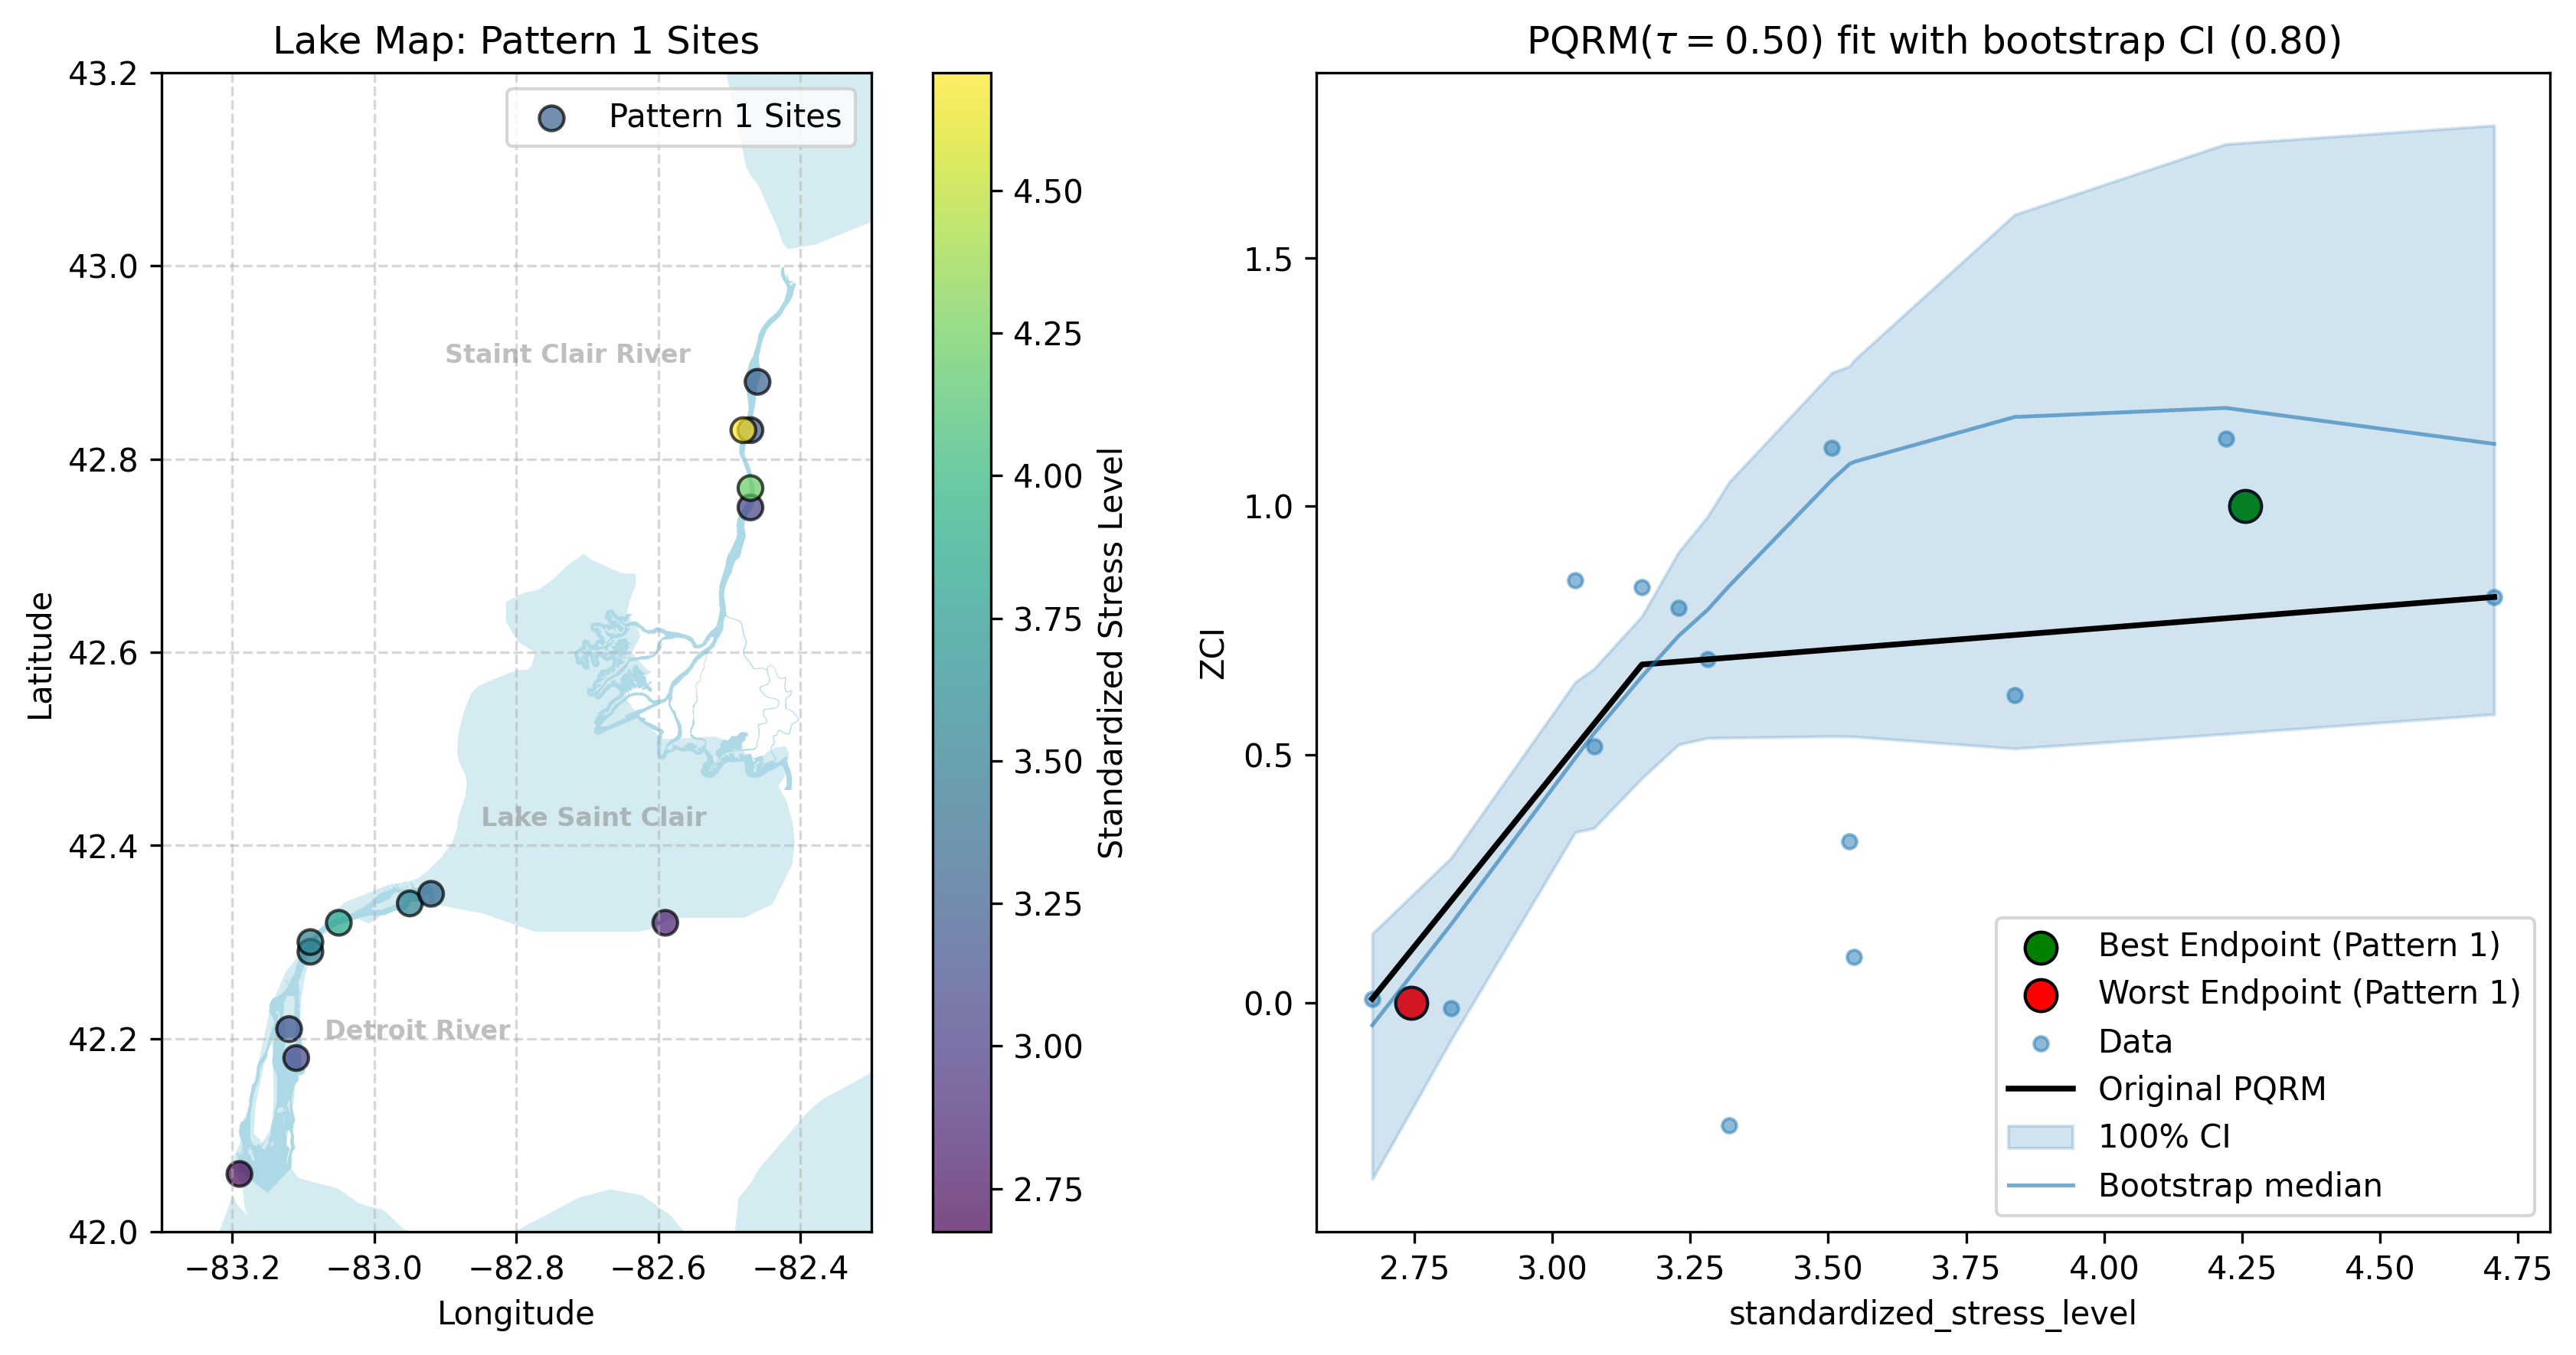

/var/folders/s5/r1s56_ps46lbbv1370hjn_vr0000gn/T/ipykernel_1507/3543563251.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=8, loc='upper left')


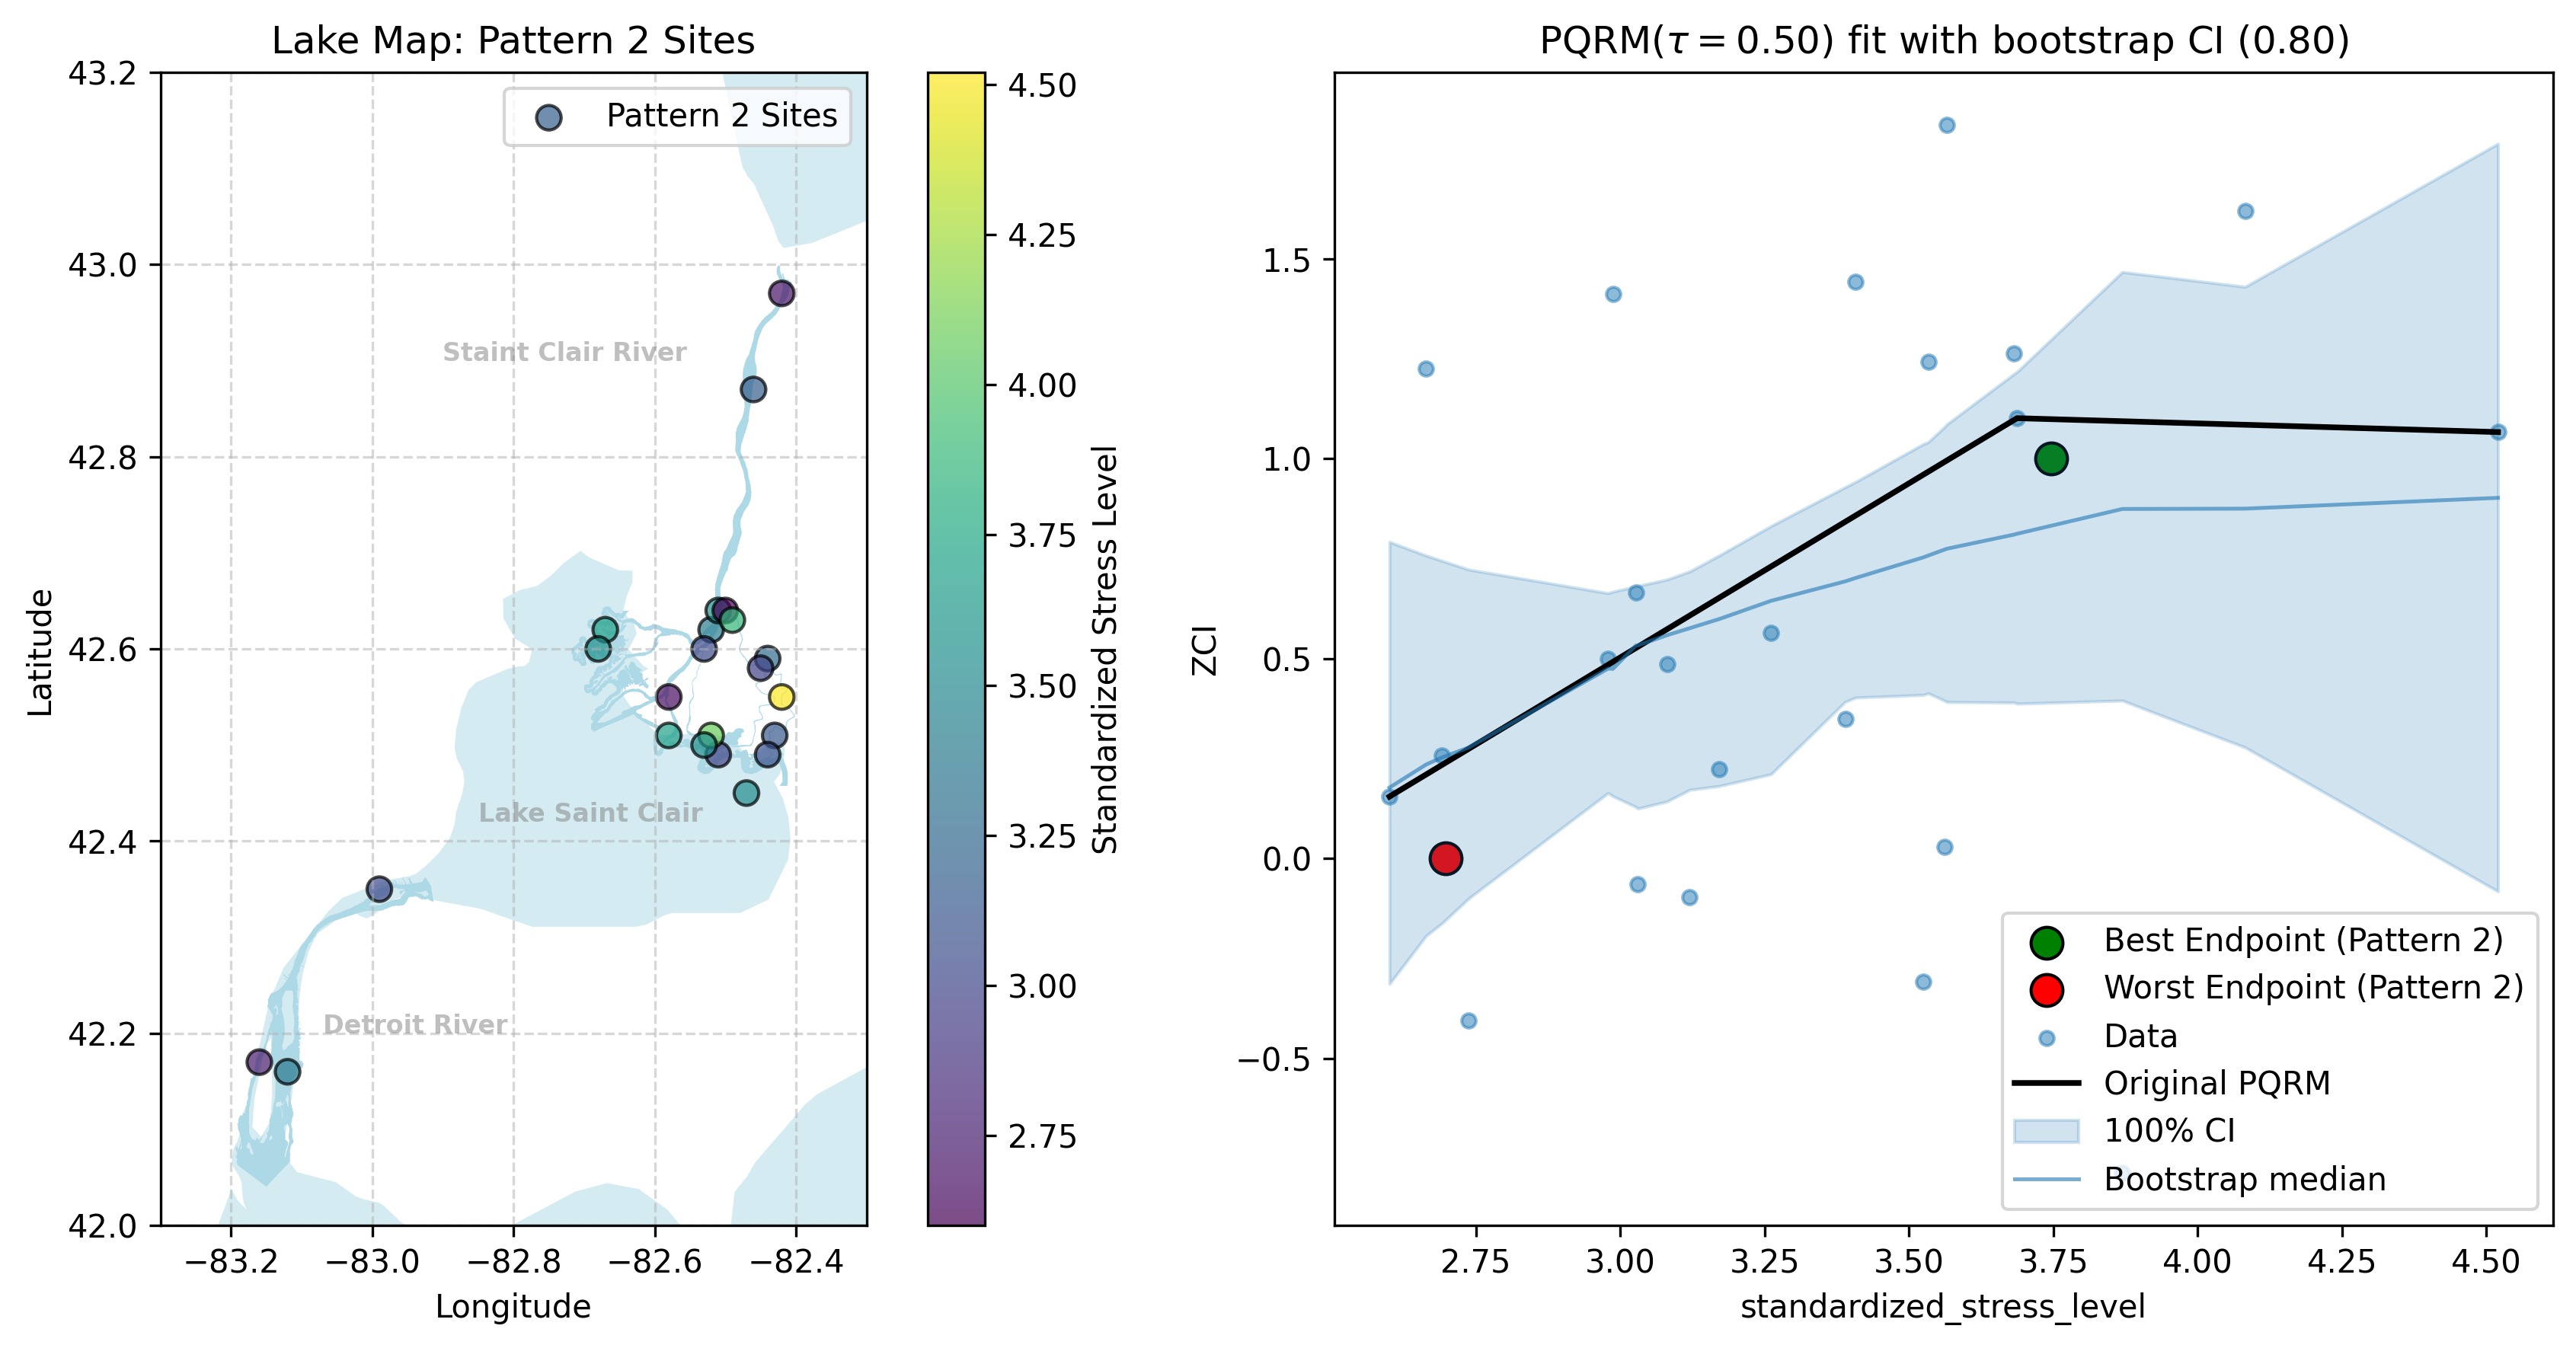

/var/folders/s5/r1s56_ps46lbbv1370hjn_vr0000gn/T/ipykernel_1507/3543563251.py:12: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(fontsize=8, loc='upper left')


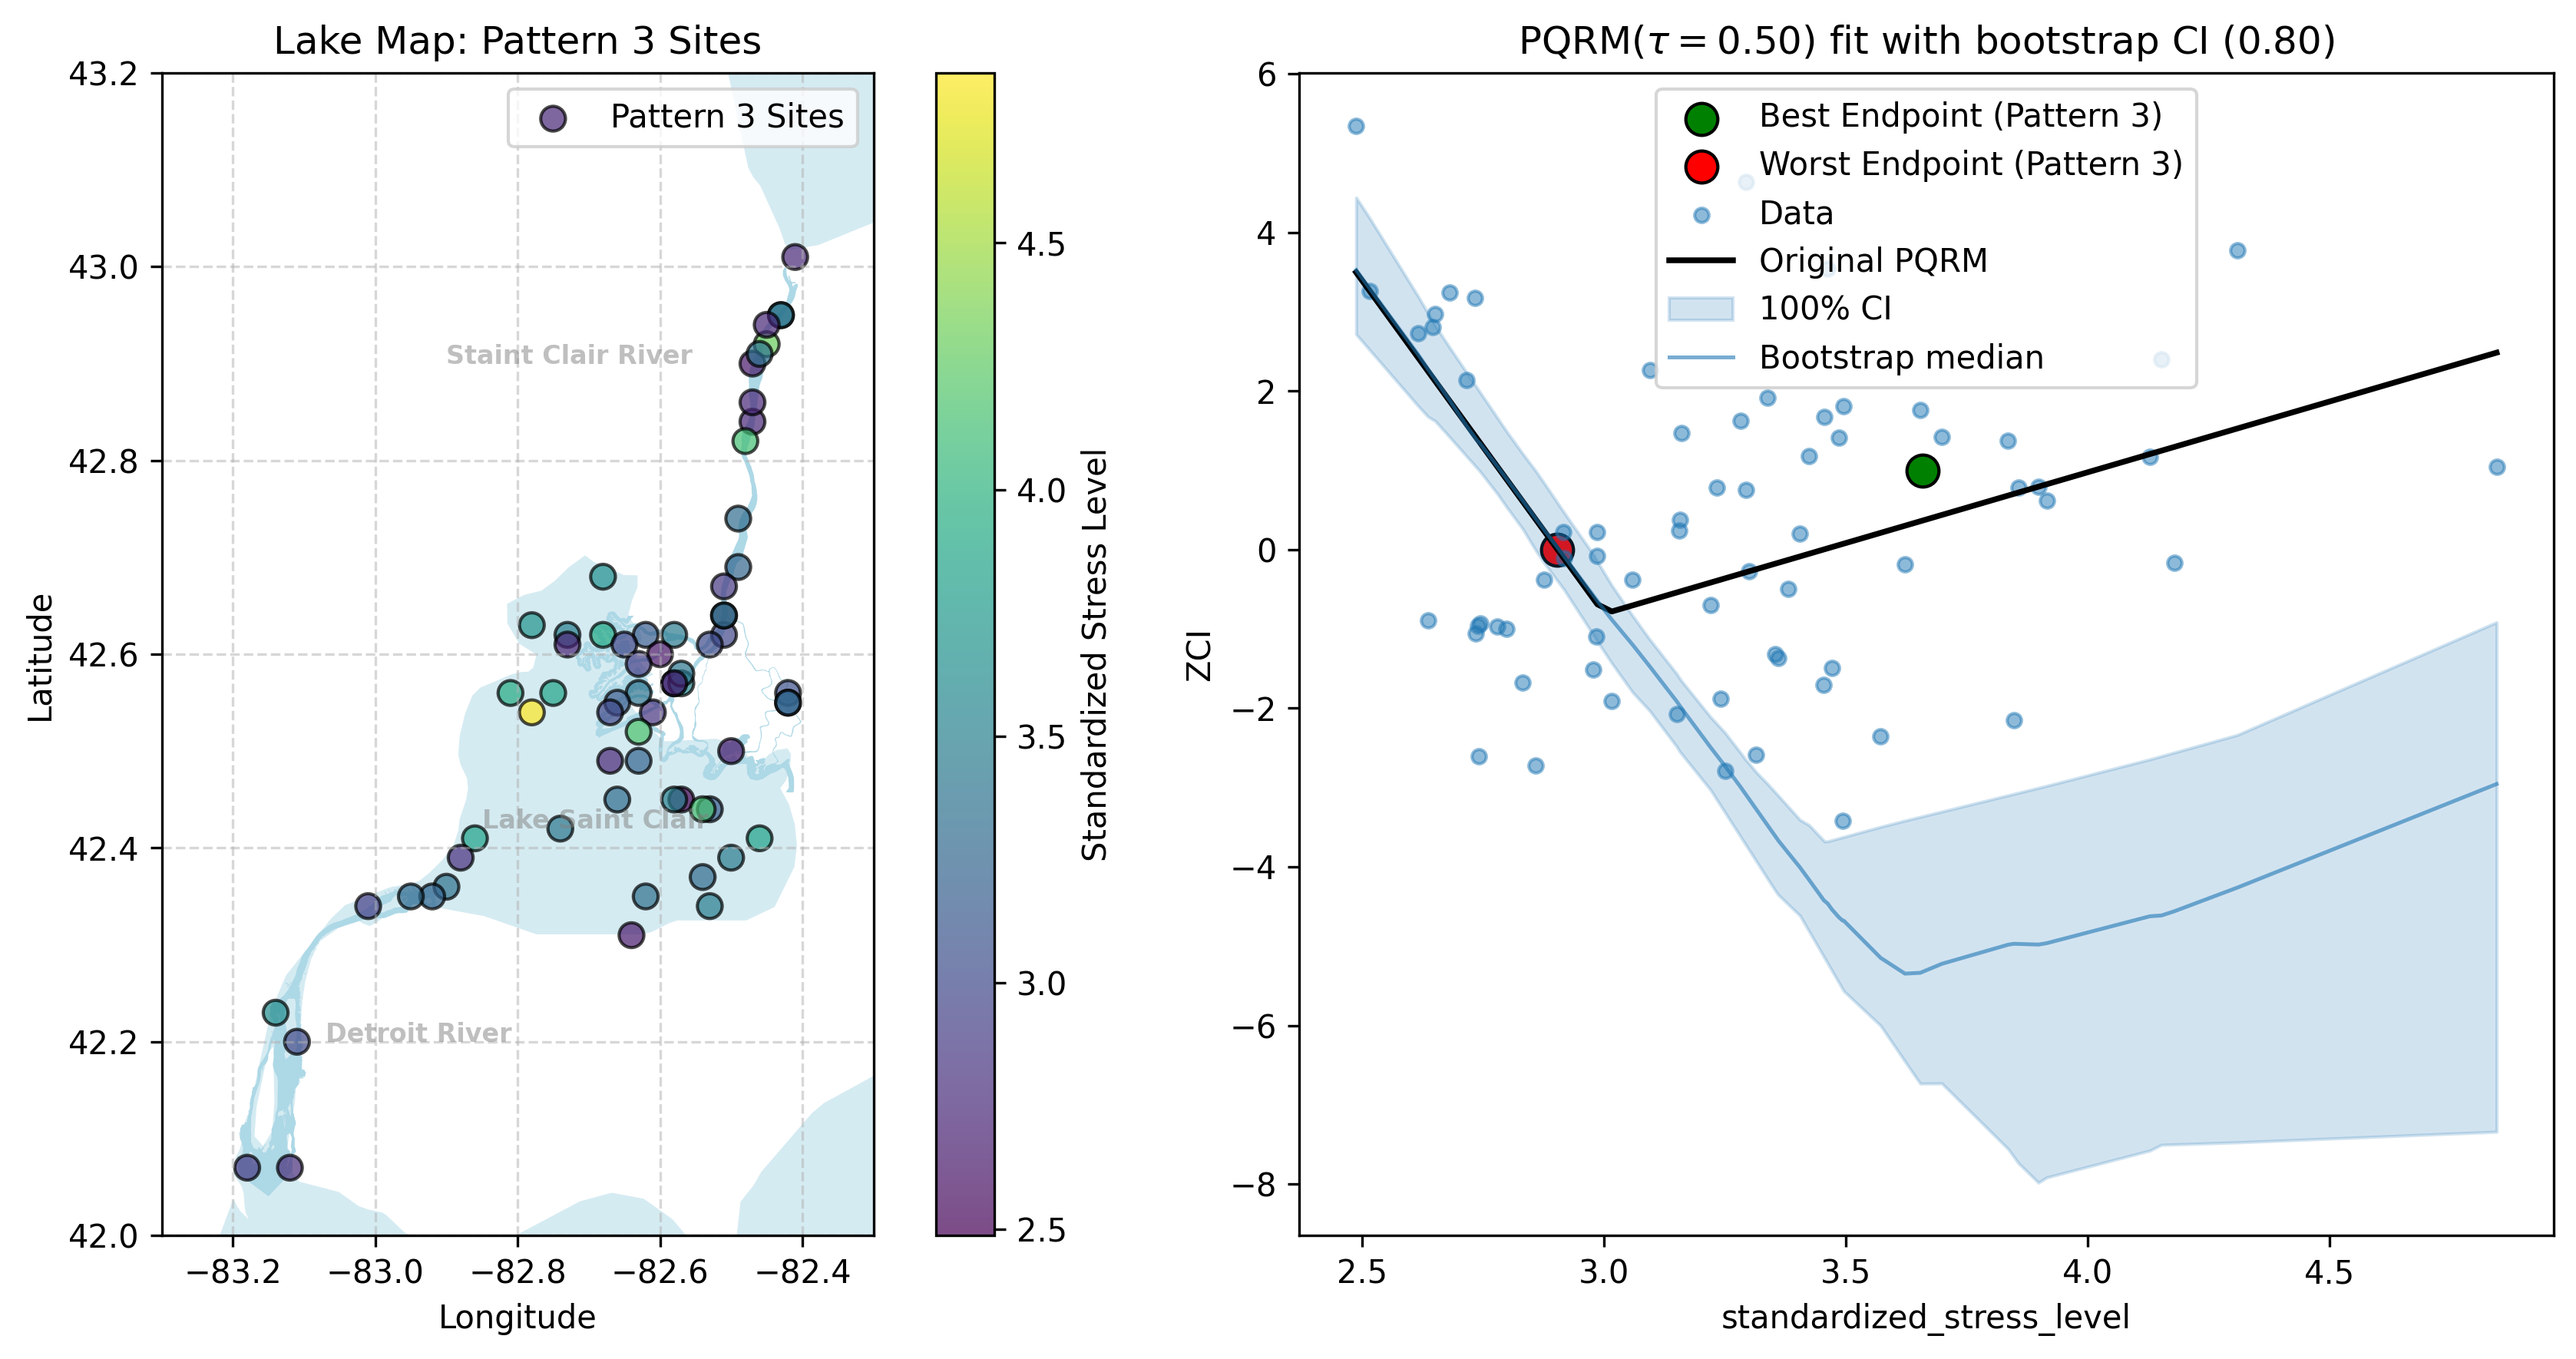

In [673]:
# fit the model across three cluster patterns
for i, ZCI_stress_pattern in enumerate([ZCI_stress_pattern1, ZCI_stress_pattern2, ZCI_stress_pattern3]):
    # fit the base PQRM model
    fitted_model, alphas, data_with_alphas = PQRM.base_model(
        data=ZCI_stress_pattern,
        tau=tau,
        initial_guess=initial_guess,
        bounds=bounds,
        x="standardized_stress_level",
        response_variable="ZCI"
    )
    # generate bootstrap predictions and confidence intervals
    boot_pred_df, pred_ci, alpha_ci, boot_alpha_ci = PQRM.generate_empirical_parameters(50,
                                                fitted_model, 
                                                data_with_alphas,
                                                tau = tau, 
                                                x="standardized_stress_level",
                                                response_variable="ZCI",
                                                initial_guess= initial_guess, 
                                                gamma = gamma,
                                                bounds = bounds,
                                                max_iter=50000)

    # visualize the results
    fig, axes = plt.subplots(1, 2, figsize=(12, 6), dpi = 300)
    axes = axes.flatten()

    # axes[0]: Visualize the sites used in ZCI_stress_pattern on the lake map
    # find the corresponding observation indices in the original data
    obs_indices = ZCI_stress_pattern.index
    # Extract the corresponding rows from the original data
    obs_locations = data.loc[obs_indices, ("location", slice(None))]
    # Flatten MultiIndex columns if needed
    if isinstance(obs_locations.columns, pd.MultiIndex):
        obs_locations.columns = obs_locations.columns.get_level_values(-1)
    # plot the lake map as background
    plot_rivers_lakes(ax=axes[0])
    # Plot the locations on the lake map (assuming columns 'Longitude' and 'Latitude' exist)
    sc = axes[0].scatter(
        obs_locations["Longitude"], obs_locations["Latitude"],
        c=data.loc[obs_indices, ("SumRel", "standardized_stress_level")],
        cmap='viridis', s=60, edgecolor='k', alpha=0.7, label=f'Pattern {i+1} Sites'
    )
    cbar = plt.colorbar(sc, ax=axes[0], orientation='vertical', label='Standardized Stress Level')
    axes[0].set_xlabel("Longitude")
    axes[0].set_ylabel("Latitude")
    axes[0].set_title(f"Lake Map: Pattern {i+1} Sites")
    axes[0].grid(True, linestyle='--', alpha=0.5)
    axes[0].legend()

    # add the best and worst endpoints to the plot
    pattern_best = best_taxa_compositions.iloc[i, [-2,-3]]
    axes[1].scatter(pattern_best["standardized_stress_level"], pattern_best["ZCI"],
                    color='green', s=100, label='Best Endpoint (Pattern {})'.format(i+1), edgecolor='k')
    pattern_worst = worst_taxa_compositions.iloc[i, [-2,-3]]
    axes[1].scatter(pattern_worst["standardized_stress_level"], pattern_worst["ZCI"],
                    color='red', s=100, label='Worst Endpoint (Pattern {})'.format(i+1), edgecolor='k')
    axes[1].legend(loc='lower left')

    plot_pqrm_bootstrap_results(
        data_with_alphas, x='standardized_stress_level', y='ZCI',
        base_model=fitted_model,
        bootstrap_predictions_df=boot_pred_df,
        pred_ci=pred_ci,
        alpha_ci=alpha_ci,
        bootstrap_alphas_ci=boot_alpha_ci,
        gamma=gamma,
        tau=tau,
        axes=axes[1],
    )
    axes[1].grid(True, linestyle='--', alpha=0.5)
    fig.savefig(f'../results/preliminary_results/pqrm_pattern_{i+1}_tau_{tau}.png', dpi=300)
    plt.show()